In [3]:
# Aquí crido l'script que t'he deixat al directori /home/anoguera/scripts/src/globalFunctionsAina.R
source("/home/anoguera/scripts/src/globalFunctionsAina.R")

phs <- fread('/home/anoguera/Data/tableGenesHtmlRefereeCorrected.tab') %>% filter(chr != 'chrX')

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ stringr 1.4.0
✔ tidyr   1.1.0     ✔ forcats 0.5.0
✔ readr   1.3.1     

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()  

In [4]:
###Gràfic per plotejar una regió concreta on es mira si l'edat estimada de les variants amb iSAFE significatiu és coherent entre les poblacions d'una mteapoblació AMB KRUSKAL-WILLIS i RELATE

diferencia_edats <- function(chr, inici, final, pop_color = popPal, 
                             AFR = AFRpops, EAS = EASpops, EUR = EURpops, SAS = SASpops, AMR = TRUE) {
    library(ggsignif)
    #Obtinc la regió necessària de la taula isafe
    isafe <- sqlToDf(chr, inici, final, 'isafe')
    #Si AMR == FALSE vol dir que s'ha d'eliminar la informació de les poblacions americanes
    if (AMR == FALSE) {
        isafe <- isafe[, -c("CLM", "MXL", "PEL", "PUR")]
    }    
    #Faig el pivot longer a isafe per tenir un registre per cada població i variant, filtro els NA i classifico per si la variant és significant o no. 
    isafe <- isafe %>%
        pivot_longer(cols = c('ACB':'YRI'), names_to = 'pop', values_to='isafe') %>%
        filter(!is.na(isafe)) %>% mutate(grup = case_when(isafe >= 0.1 ~ 'Significant', TRUE ~ 'Nonsignificant'))
    #Això serveix per conseguir un vector amb les poblacions que tenen alguna variant significatica en iSAFE per aquesta regió
    pop_significatiu <- unique(isafe %>% filter(grup == 'Significant') %>% pull(pop))
    #Si no hi ha cap població significativa, s'acaba ja i no es pot representar res
    if (length(pop_significatiu) == 0) {
        return('This region cannot be represented, as no populations have variants with a significant iSAFE value')
    }
    #Filtro la taula per quedar-me només amb la informació de poblacions amb variants significatives i afegeixo a quina metapoblació pertanyen i la columna rsid_pop
    isafe <- isafe %>% filter(pop %in% pop_significatiu) %>% mutate(metapop = case_when(pop %in% AFR ~ 'AFR',
                                                                                        pop %in% EUR ~ 'EUR',
                                                                                        pop %in% EAS ~ 'EAS',
                                                                                        pop %in% SAS ~ 'SAS',
                                                                                        TRUE ~ 'AMR'),
                                                                    rsid_pop = paste(rsid, pop, sep=':'))
    #Obro la taula de les edats del cromosoma en qüestió i filtro per la regió i perquè la població sigui a pop_significatiu
    allele_ages <- fread(paste0("/home/anoguera/Data/relate_ages/allele_ages_chr", chr, '.csv')) %>% filter(BP >= inici & BP <= final) %>% select(BP, pop, lower_age, upper_age, pvalue)
    #Ara ajunto les dues taules en el merged
    merged <- merge(isafe, allele_ages, by.x = c('physicalPos', 'pop'), by.y = c('BP', 'pop'))
    #Una vegada fet el merge, em quedo amb les 15 variants més significatives per iSAFE (no ho faig abans perquè potser perdríem les variants significatives per no estar a la taula d'edats)
    #Creo una taula on hi hagi les files corresponents als 15 valors significatius d'iSAFE més alts en cada població. SI n'hi ha menys de 15, es guarden els que hi hagi. Si hi ha empats, se'n queda > 15
    isafe15 <- merged %>% select(grup, pop, isafe, rsid_pop) %>% filter(grup == 'Significant') %>% group_by(pop) %>% slice_max(isafe, n=15)
    #Ara de la taula principal, elimino les files que siguin significants  no estiguin a isafe15 
    merged <- merged %>% filter(grup == 'Nonsignificant' | rsid_pop %in% isafe15$rsid_pop)
    #En cas que no hi hagi cap variant significativa en tota la població després de tot, diem que no es pot representar la població
    pop_significatiu <- unique(merged %>% filter(grup == 'Significant') %>% pull(pop))
    if (length(pop_significatiu) == 0) {
        return('This region cannot be represented, as no populations have an estimated allele age for variants with a significant iSAFE value')
    }
    #Em quedo només amb les poblacions que tinguin variants significatives al final i calculo l'edat estimada de la variant, que és la mitjana de les edats superior i inferior (per mutacions neutres??)
    merged <- merged %>% filter(pop %in% pop_significatiu) %>% mutate(age = 0.5*(lower_age + upper_age))
    #Faig una taula on posar (després) el resultat del test Kruskal-Wallis per metapoblació i la primera i última població de la metapop per representar-ho
    kruskal <- merged %>% filter(grup == 'Significant') %>% group_by(metapop) %>% arrange(pop) %>%
        summarise(primer = unique(pop)[1], ultim = unique(pop)[n_distinct(pop)], .groups = 'keep')
    #Aqui guardaré els p_valors de l'anàlisi kruskal-wallis de cada població que es pugui. No puc filtrar els iSAFE < 0.1 de la taula principal perquè els necessito pel gràfic
    p_vals <- c('AFR' = NA, 'EUR' = NA, 'EAS' = NA, 'SAS' = NA, 'AMR' = NA)
    for (i in 1:5) {
        merged_temp_temp <- merged  %>% filter(grup == 'Significant' & metapop == names(p_vals)[i])
        #Si no hi ha valors per aquesta metapoblació, es queda el NA
        if (nrow(merged_temp_temp) == 0) {
            next
        }
        #Si no es pot fer cap anàlisi, es posa un None
        if (n_distinct(merged_temp_temp$pop) == 1 | n_distinct(merged_temp_temp$rsid) == 1) {
            p_vals[i] <- 'None'
            next
        }
        #Per poder fer el test de Kruskal-Wallis, fa falta fer un test d'homogeneitat i que no hi hagin diferències significatives entre les variàncies de les diferents poblacions
        #Faig un test de Levene amb la mediana perquè és no paramètric i no passa res perquè no segueixi una distribució normal i accedeixo al seu p-valor
        p_valor_levene <- levene.test(y = merged_temp_temp$age, group = merged_temp_temp$pop, location = "median")[["p.value"]]
        if (is.na(p_valor_levene)) {
            p_vals[i] <- 'None'
            next
        } else if (p_valor_levene < 0.05) {
            p_vals[i] <- 'Non-homogeneous'
            next
        }
        #Si es fa l'anàlisi, es guarda el p_valor al vector
        p_vals[i] <- round(kruskal.test(age ~ pop, data = merged_temp_temp)[['p.value']], digits = 5)
    }
    #Afegeixo els p_valors a la taula kruskal
    kruskal <- kruskal %>% mutate(p_valor = p_vals[metapop])
    #Faig la llista de comparacions que s'ha de donar al geom_signiff
    comparisons_list <- list()
    for (n in 1:nrow(kruskal)) {
        comparisons_list[[n]] <- c(kruskal$primer[n], kruskal$ultim[n])
    }
    annotations_vector <- kruskal$p_valor
    #Faig això per tenir a pop_color només les poblacions que es representaran, i ordenades per metapoblació
    pops <- unique(merged %>% arrange(metapop) %>% pull(pop))
    pop_color <- pop_color[pops]
    #Faig el gràfic. onvertir la x en factor després d'ordenar per pop i per metapop serveix per tenir les poblacions ordenades per metapoblació
    #i per la representació de geom_signif, perquè tenim la primer i última població de cada metapop alfabèticament
    #print(merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% summarise(n = n(), .groups = 'keep'))
    options(repr.plot.width = 20, repr.plot.height = 10, warn = 1)
    grafic <- merged %>% arrange(pop) %>% arrange(metapop) %>%
        ggplot(mapping = aes(x=factor(pop, levels=unique(pop)), y=age/1000, fill=pop, color = grup, alpha = grup, by = metapop)) +
        geom_boxplot() + scale_color_manual(values = c('grey','#6b0000'), name= 'iSAFE') + scale_alpha_manual(values = c(0.35, 1), name= 'iSAFE') +
        scale_fill_manual(values = pop_color, breaks = names(pop_color), name = 'Population') +
        labs(x='', y='Estimated variant age (thousands of generations)', title = paste0('Chr ', chr, ': ', inici, '-', final)) +
        geom_signif(comparisons = comparisons_list, annotations = annotations_vector, textsize = 7, color = 'black', alpha = 1) + theme(text = element_text(size = 20))
    return(grafic)
}

Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


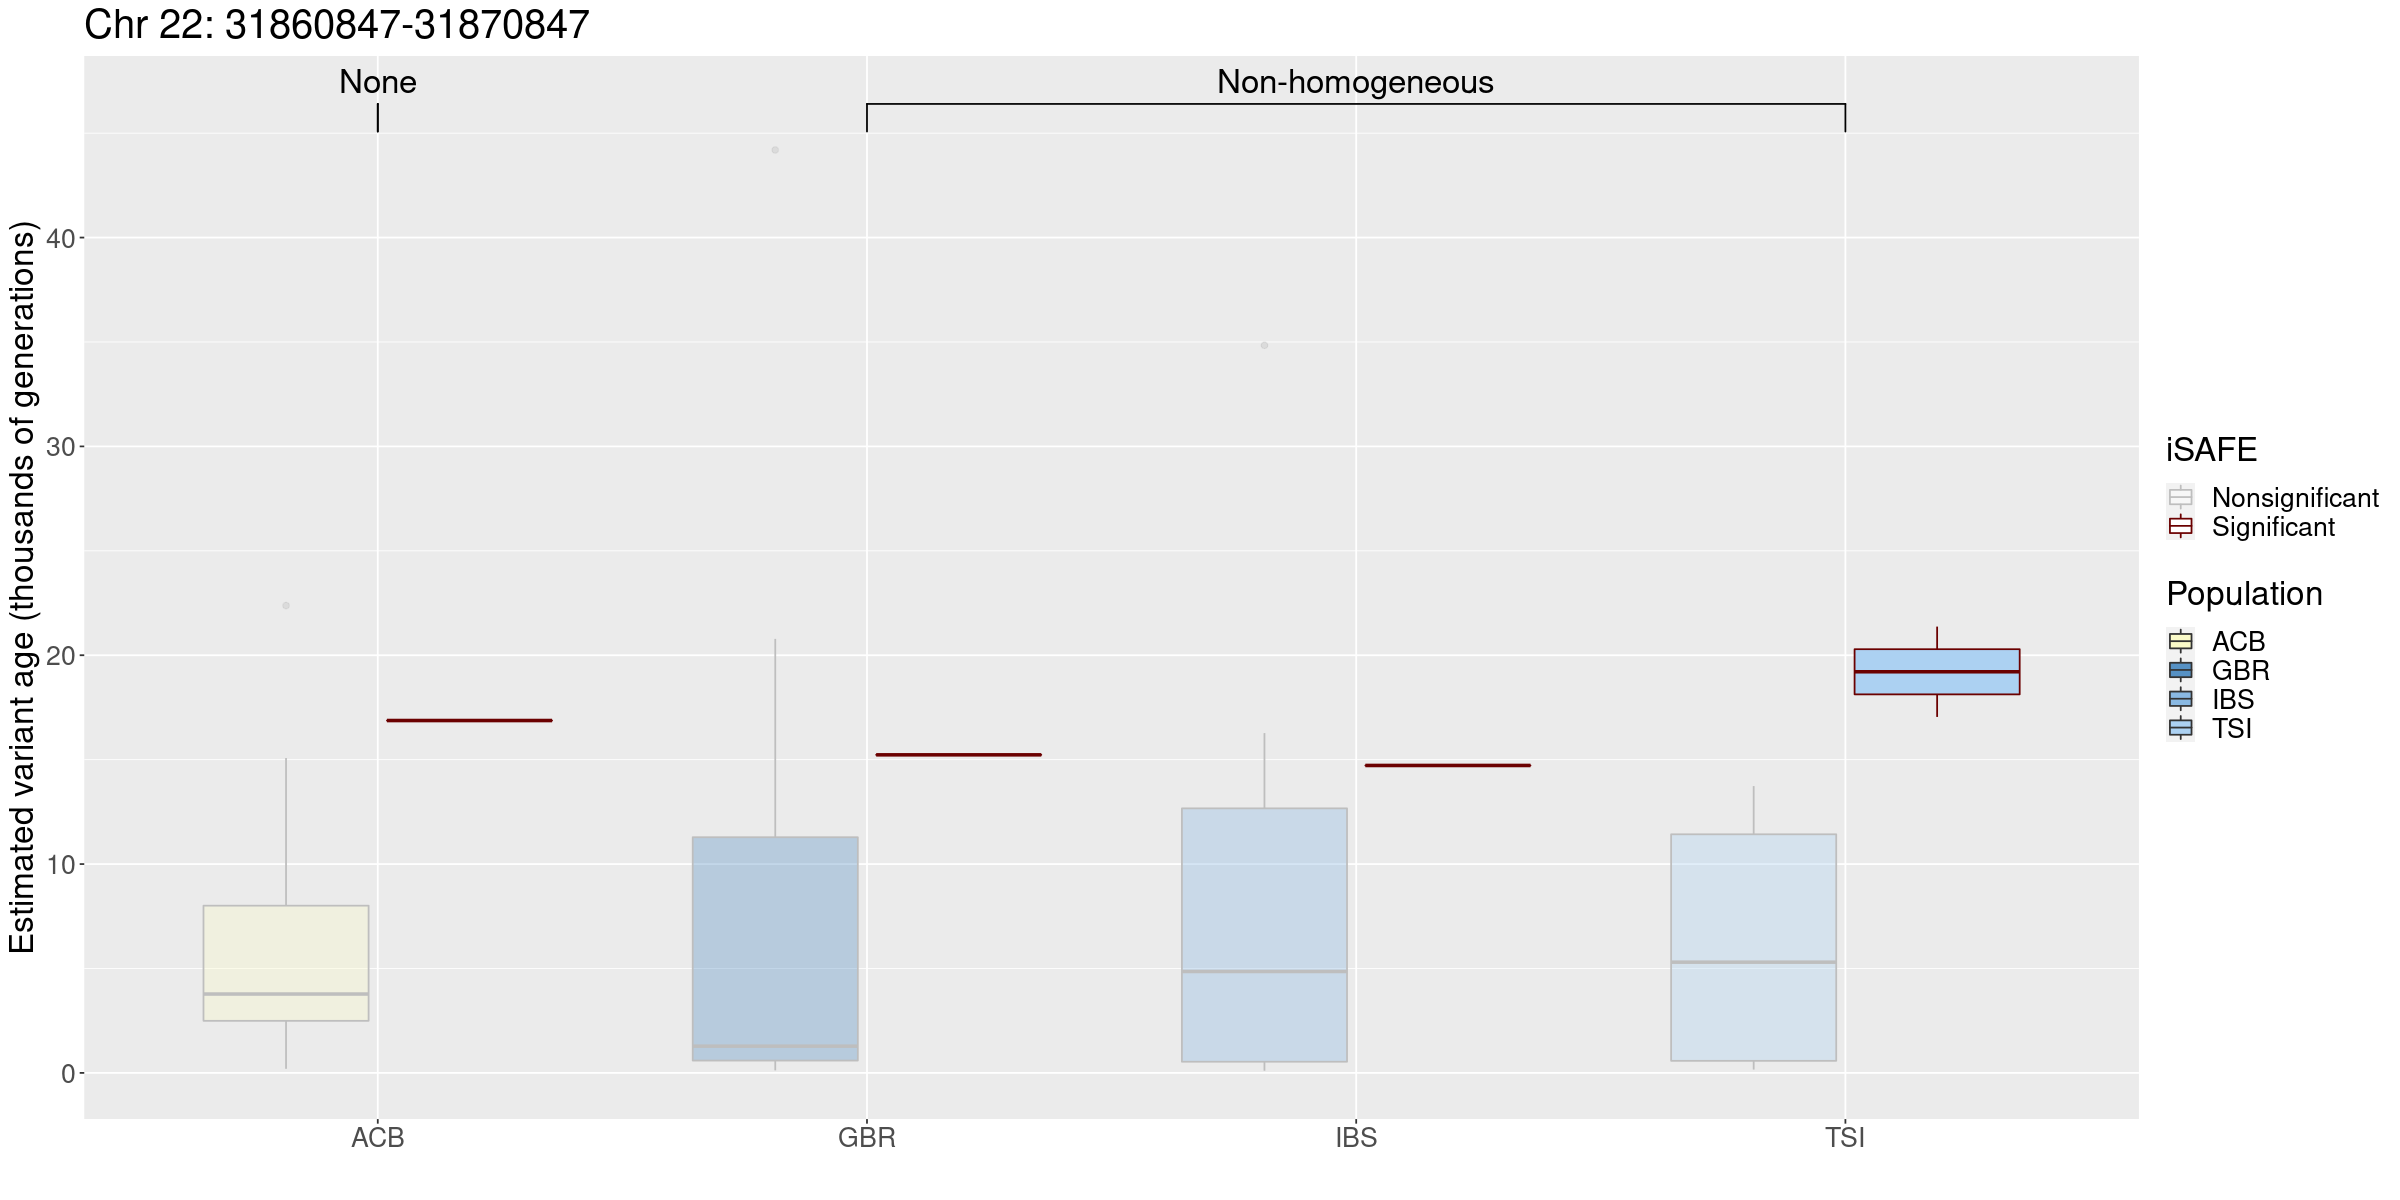

In [6]:
diferencia_edats(22, 31860847, 31870847) #EIF4ENIF1,DRG1

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


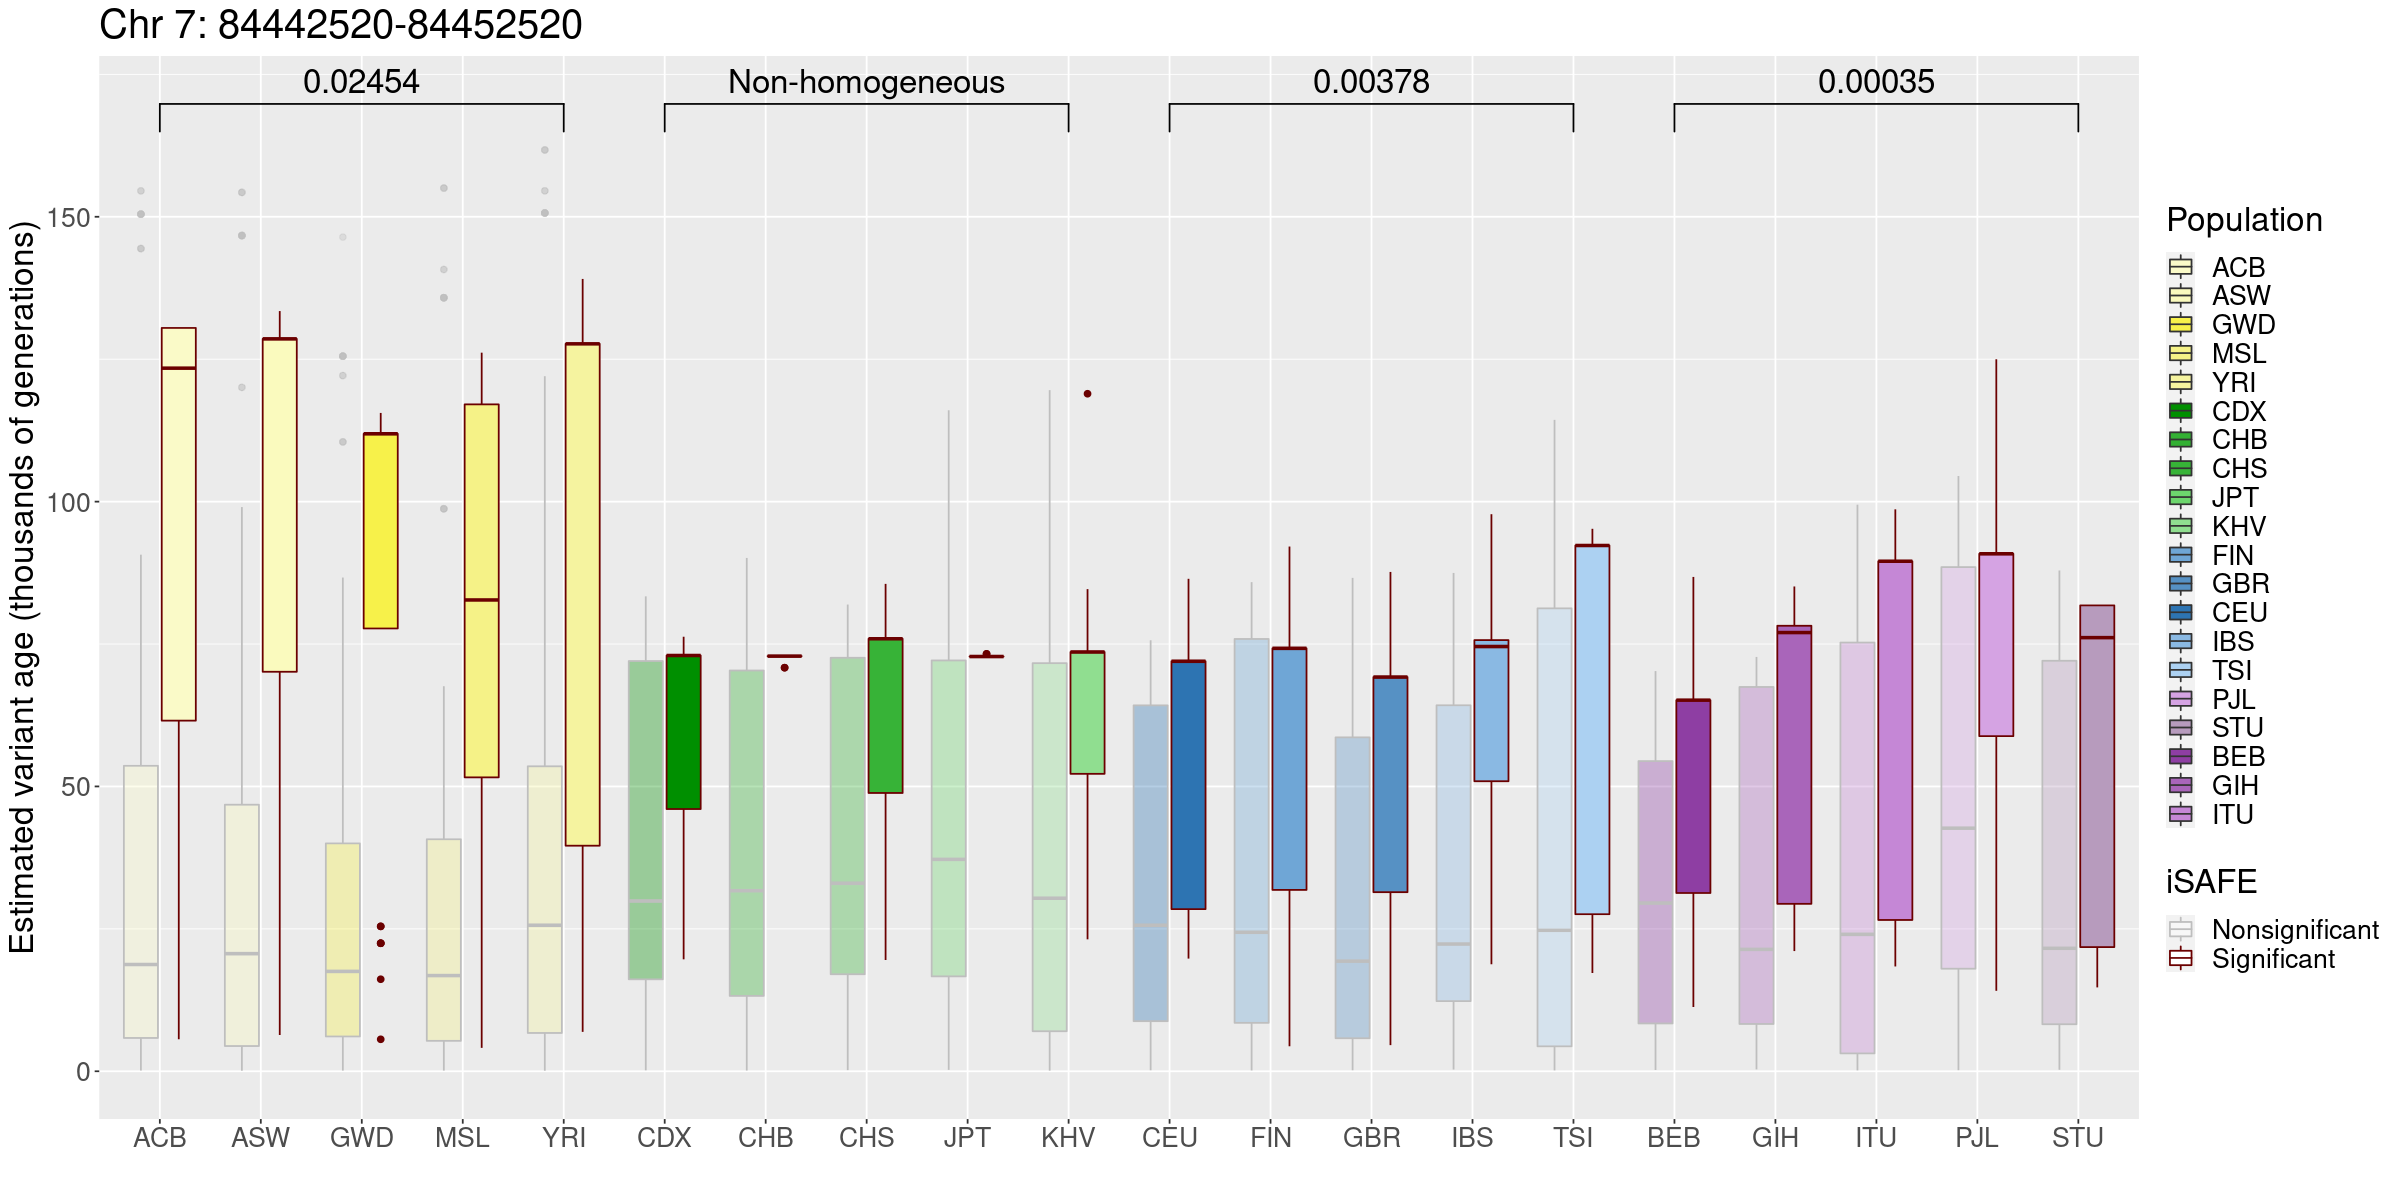

In [7]:
diferencia_edats(7, 84442520, 84452520, AMR = FALSE) #nonCoding43263

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


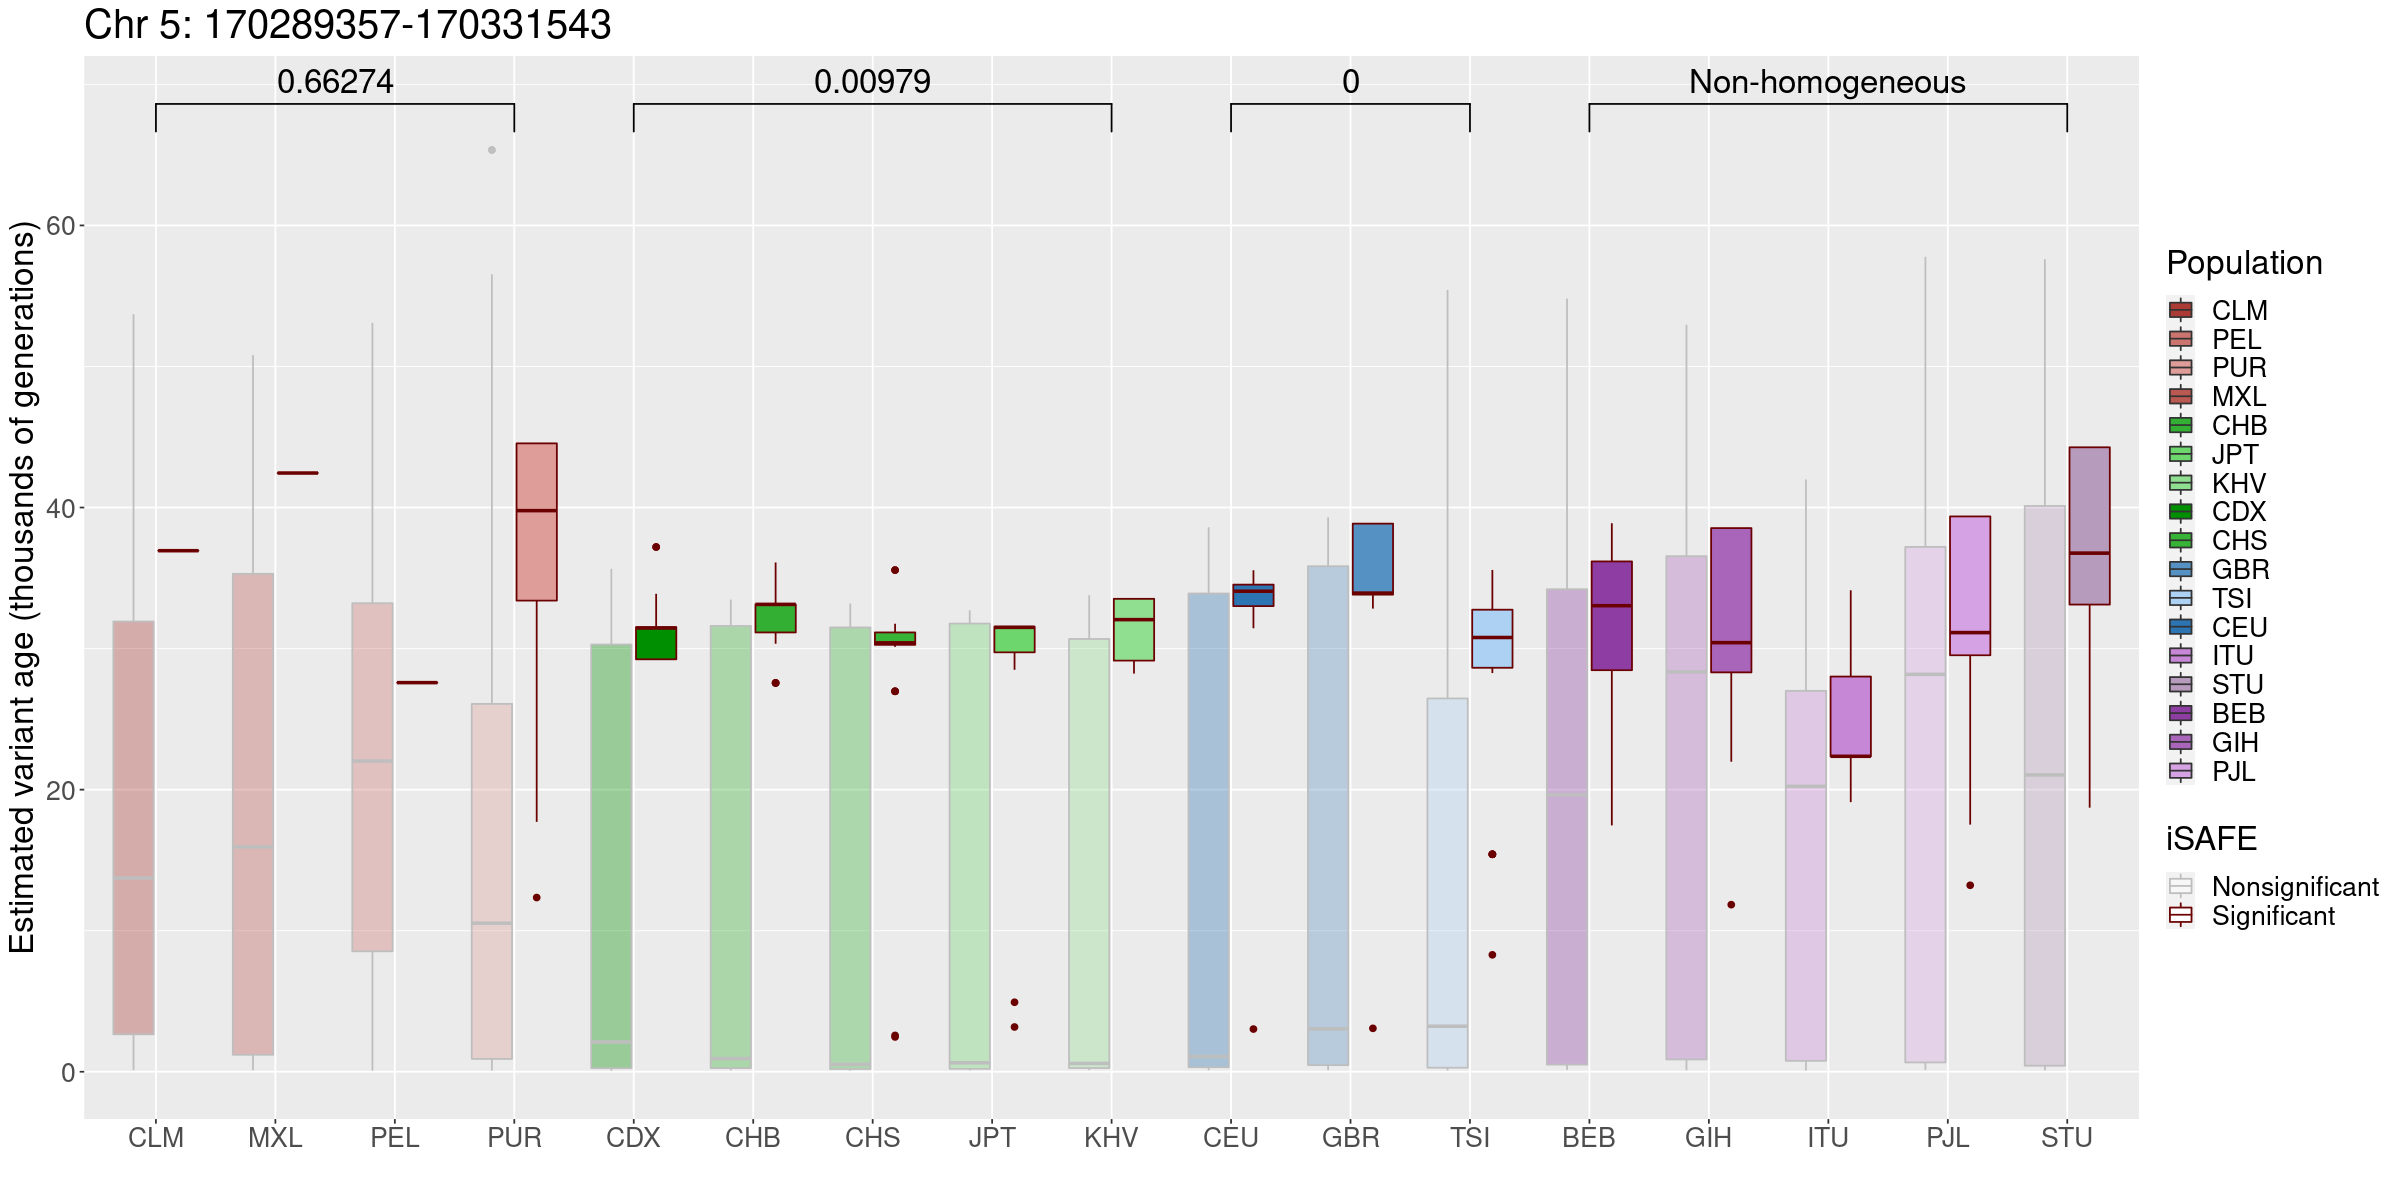

In [8]:
diferencia_edats(5, 170289357, 170331543) #RANBP17

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


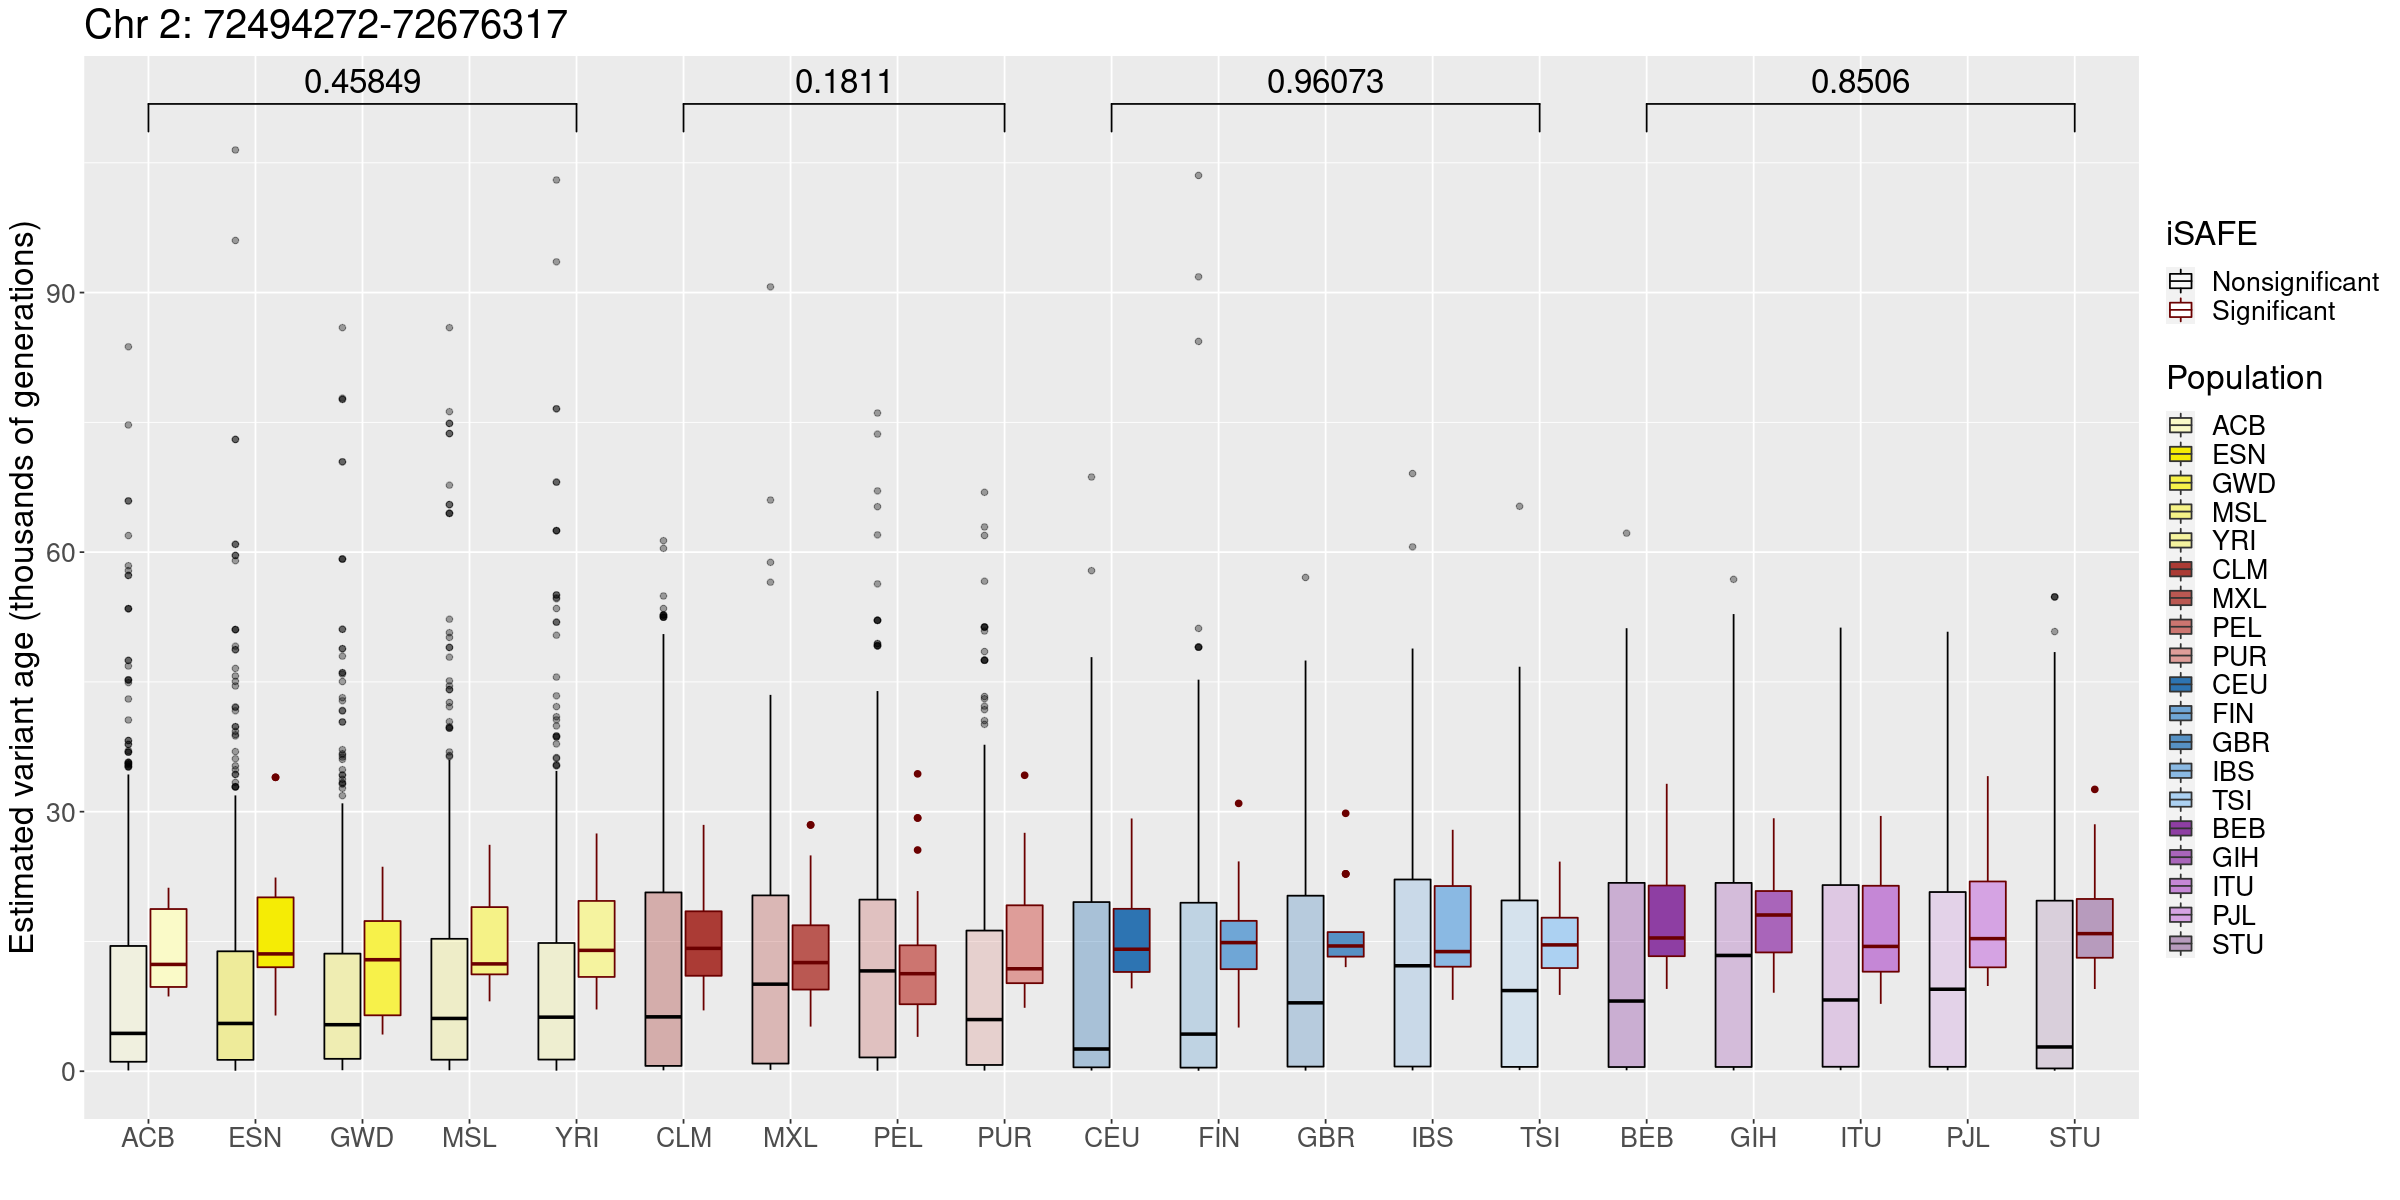

In [57]:
diferencia_edats(2, 72494272, 72676317) #EXOC6B

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


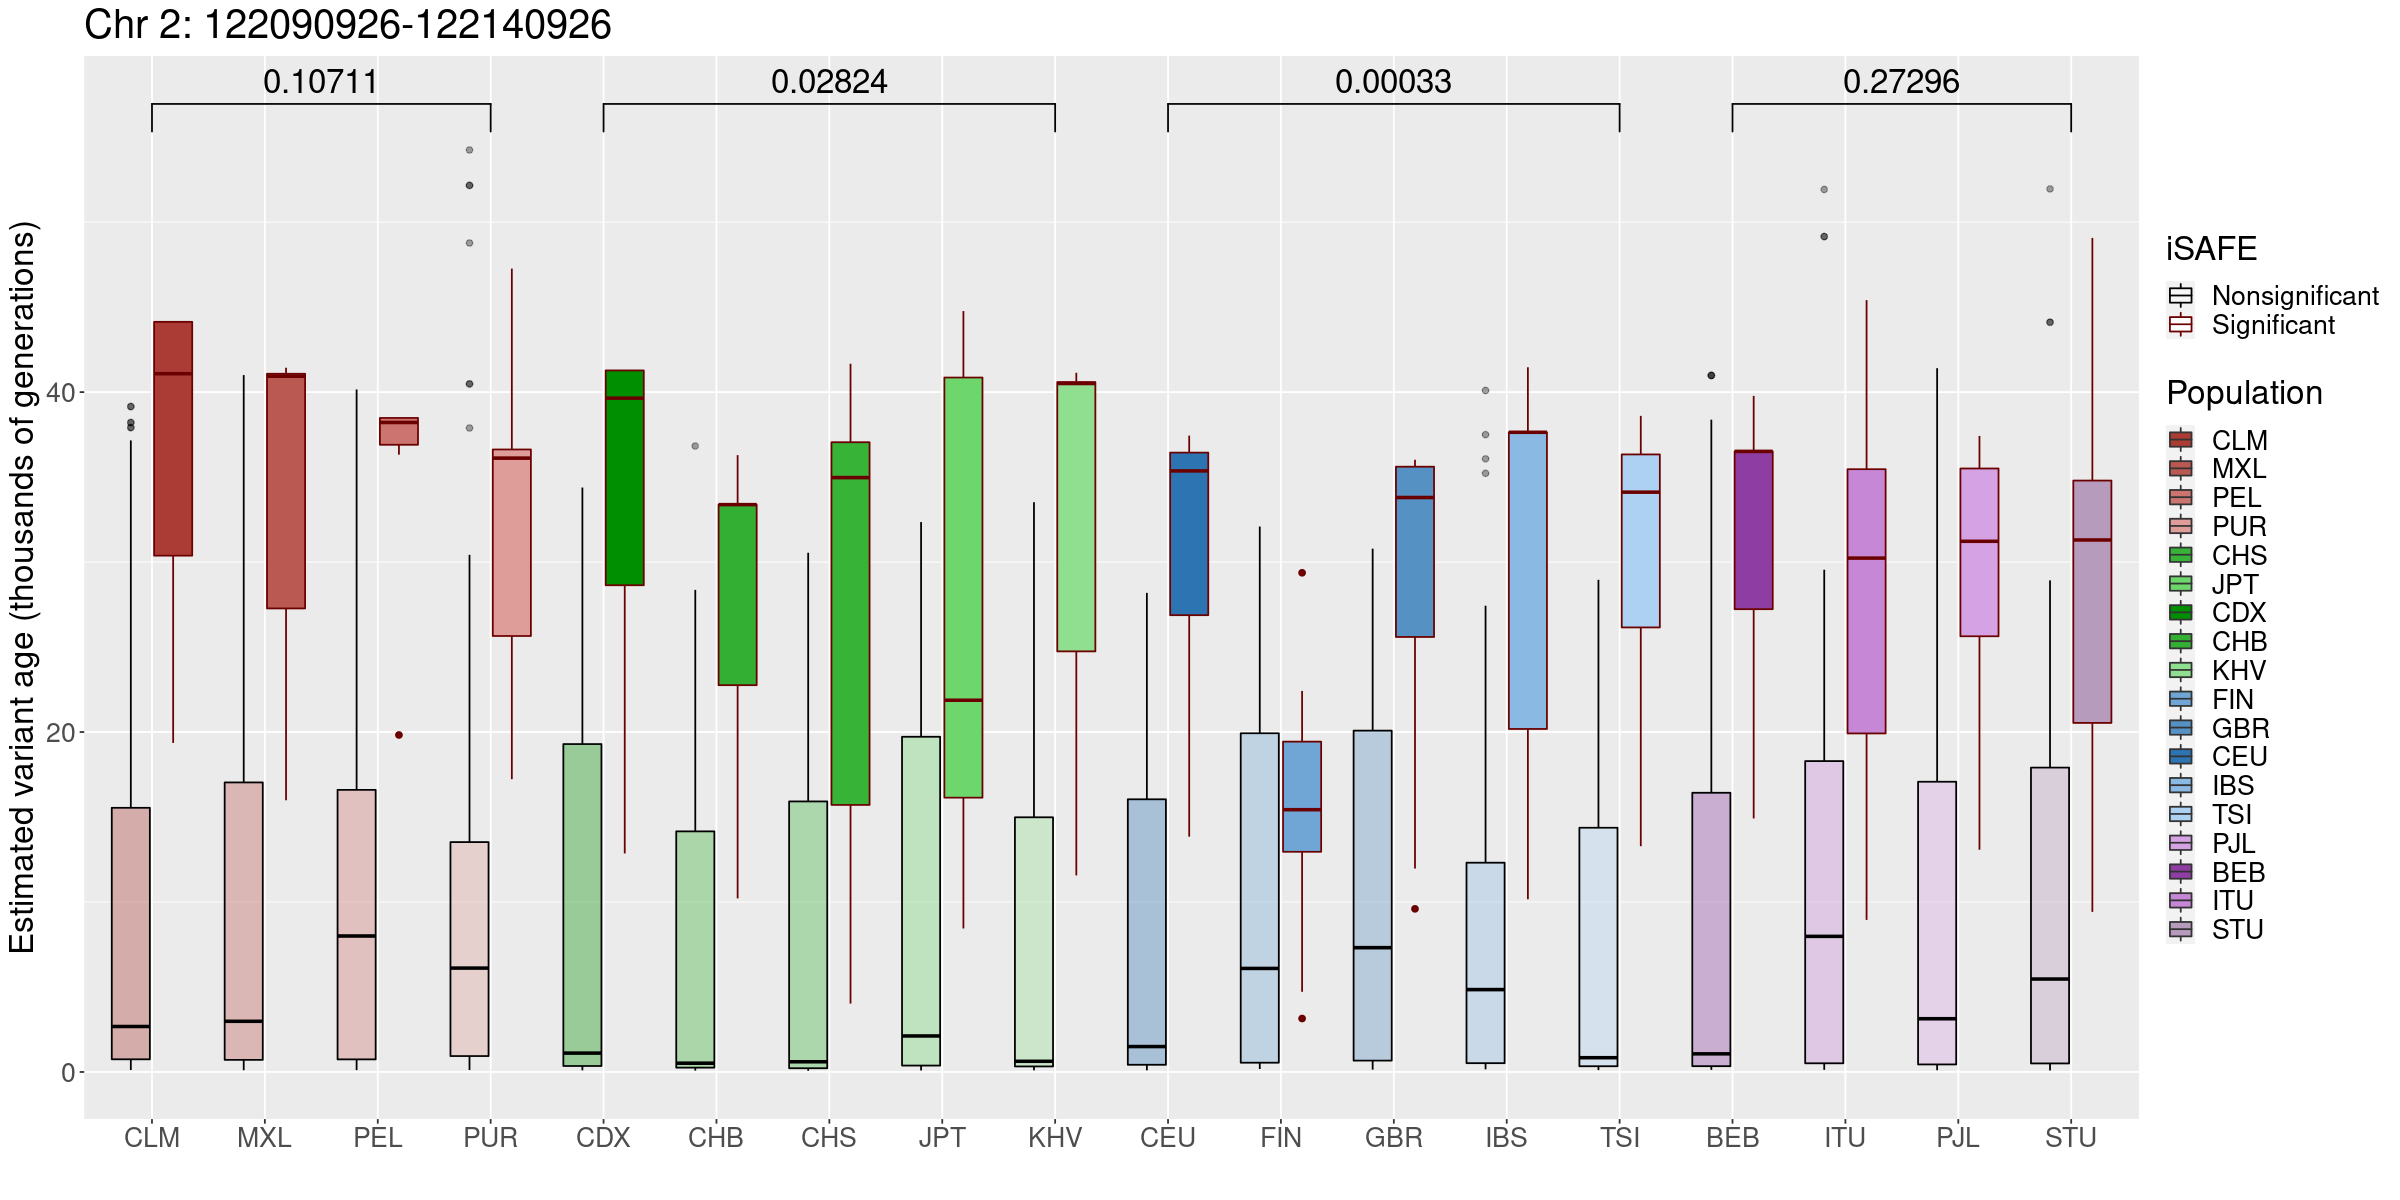

In [58]:
diferencia_edats(2, 122090926, 122140926) #CLASP1

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


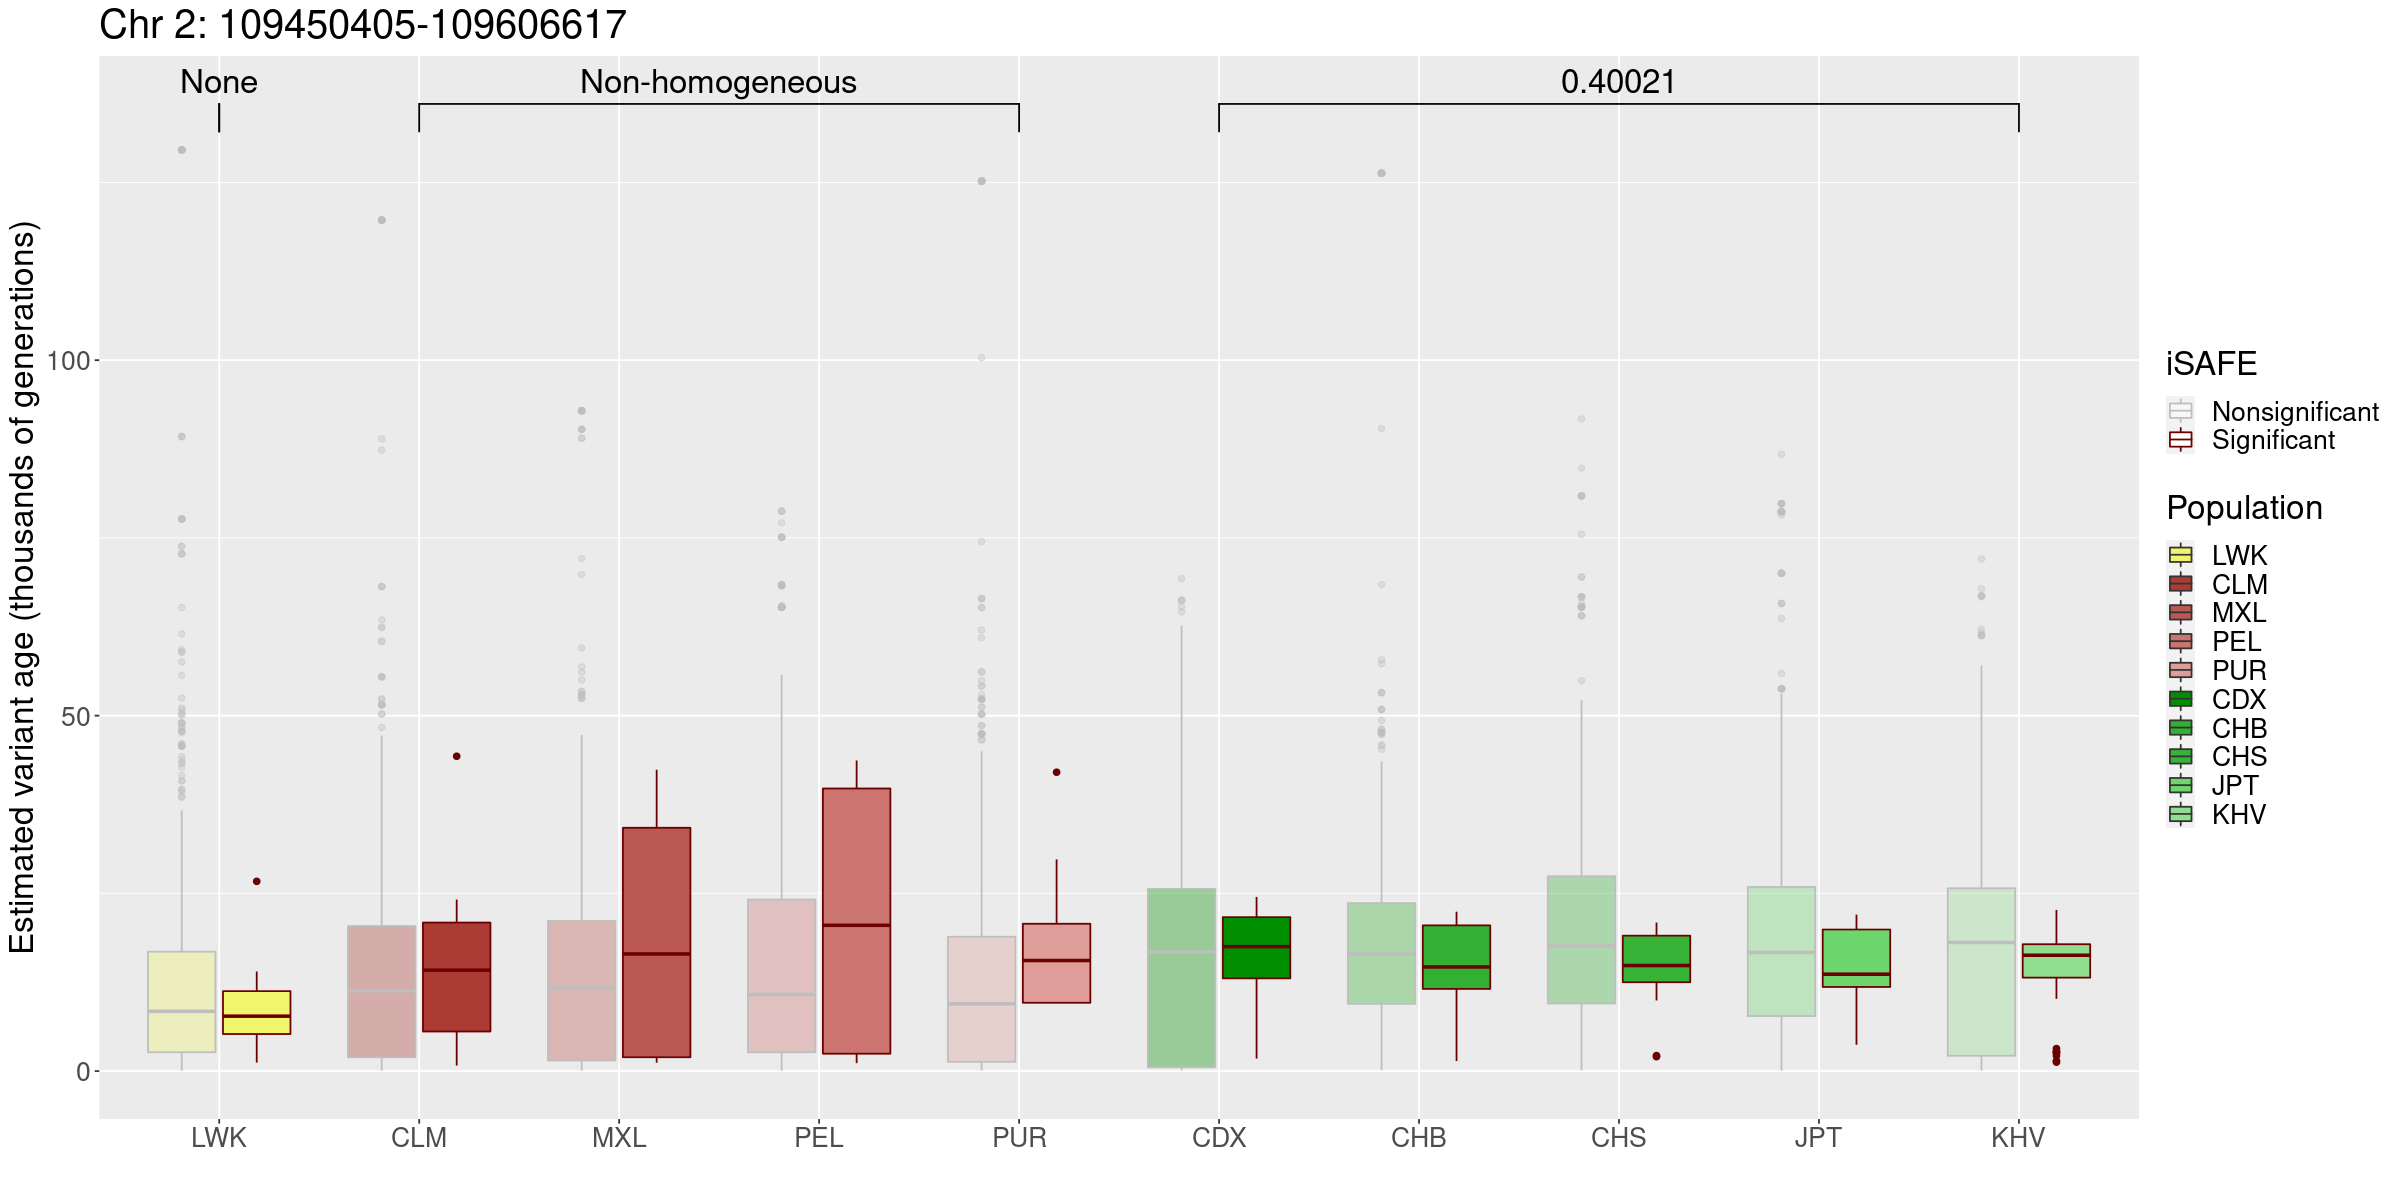

In [5]:
diferencia_edats(2, 109450405, 109606617) #EDAR,CCDC138

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


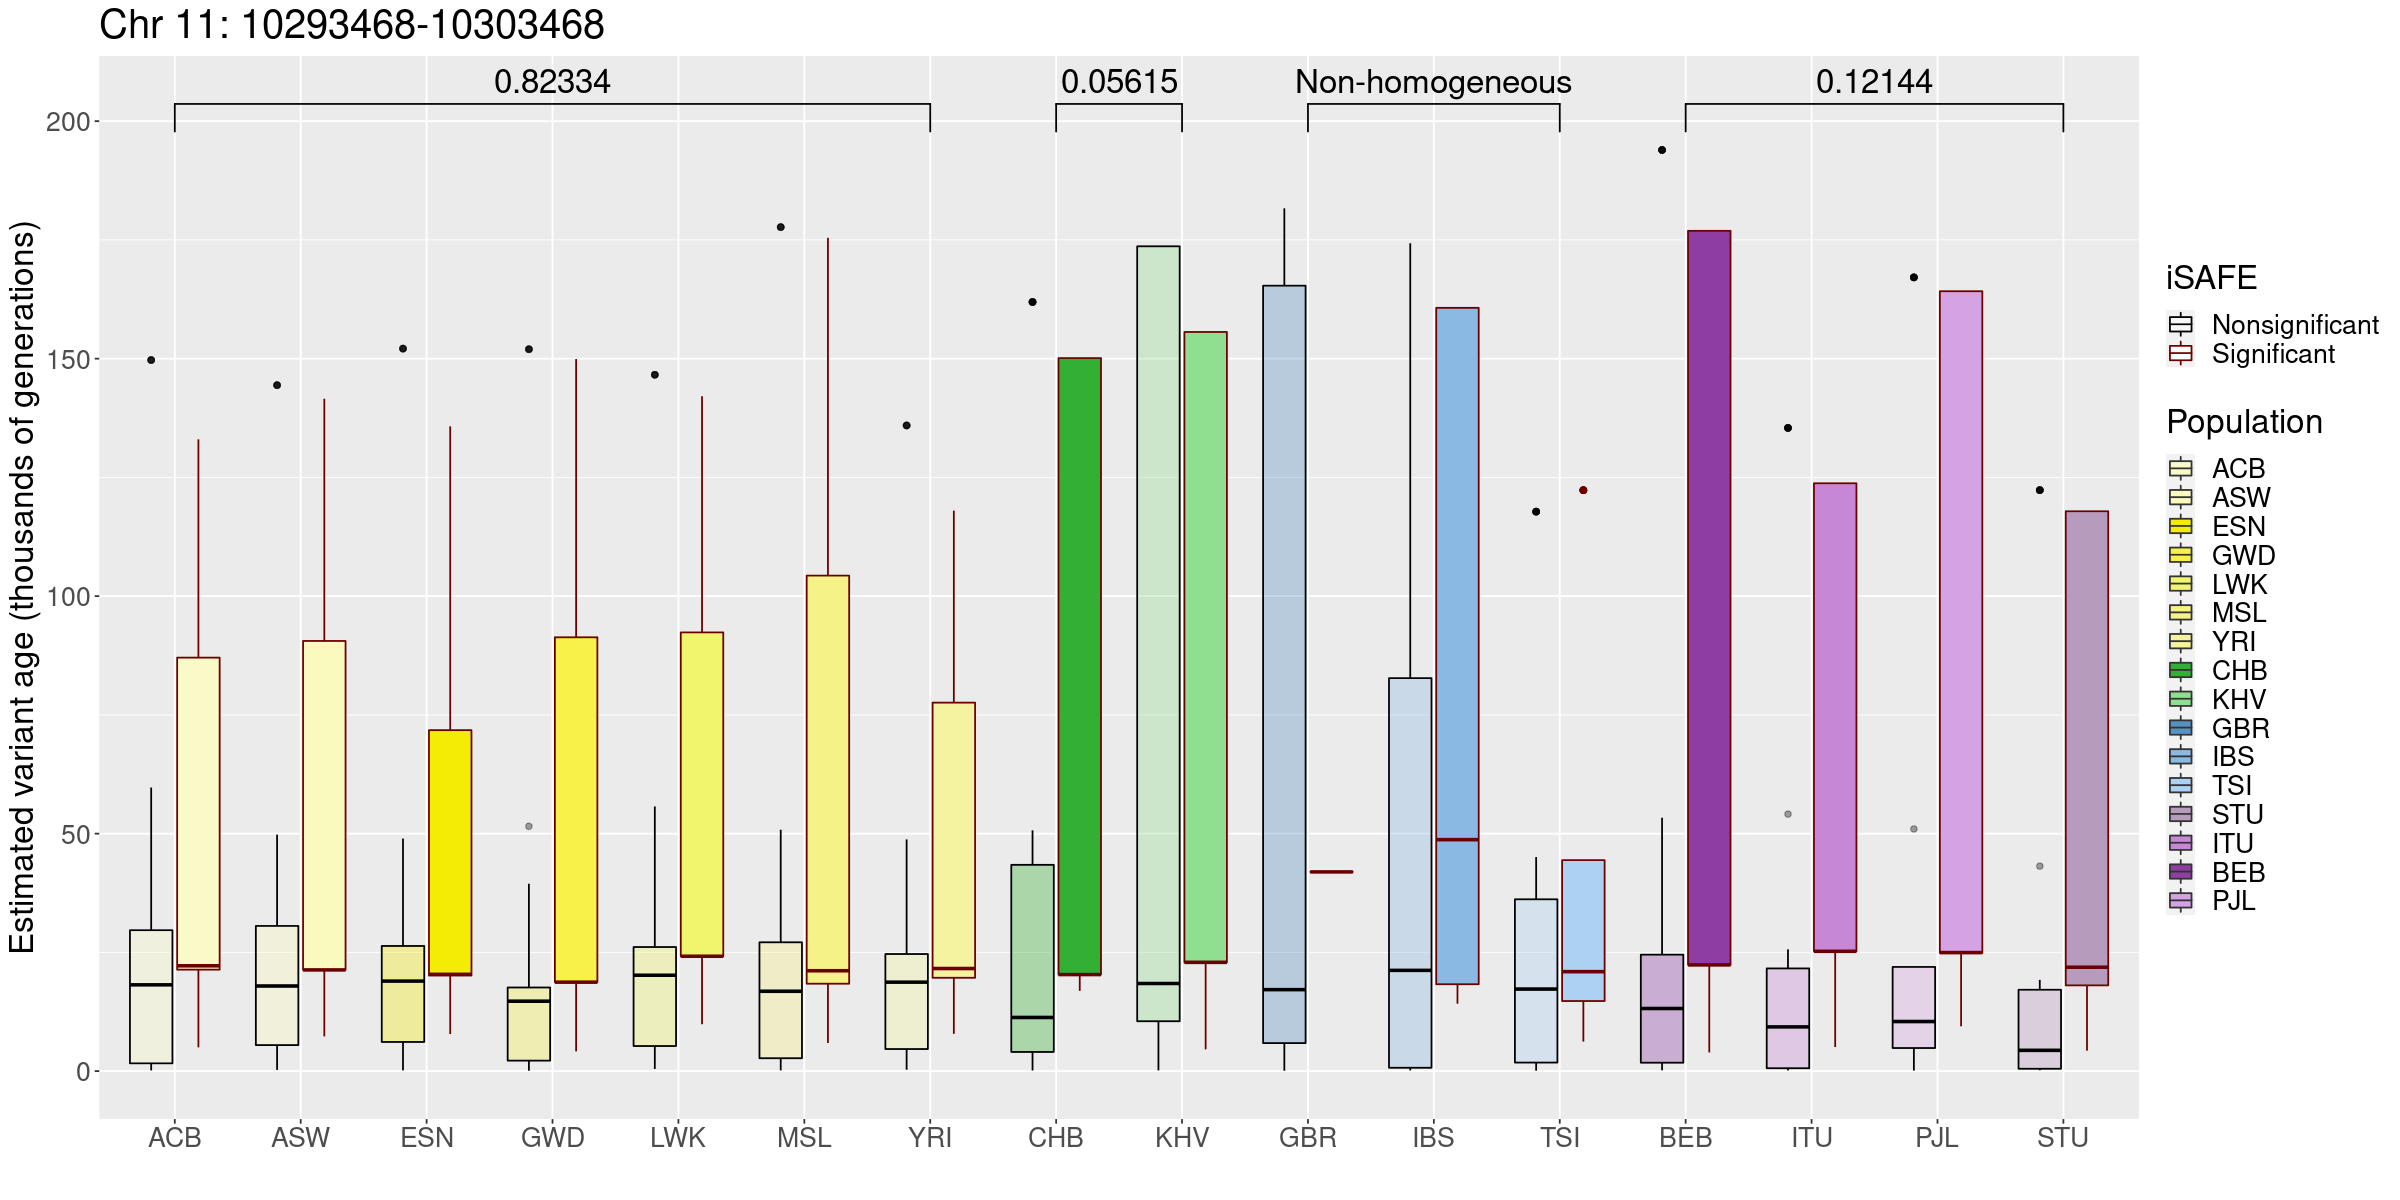

In [47]:
diferencia_edats(11, 10293468, 10303468, AMR = FALSE) #SBF2

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


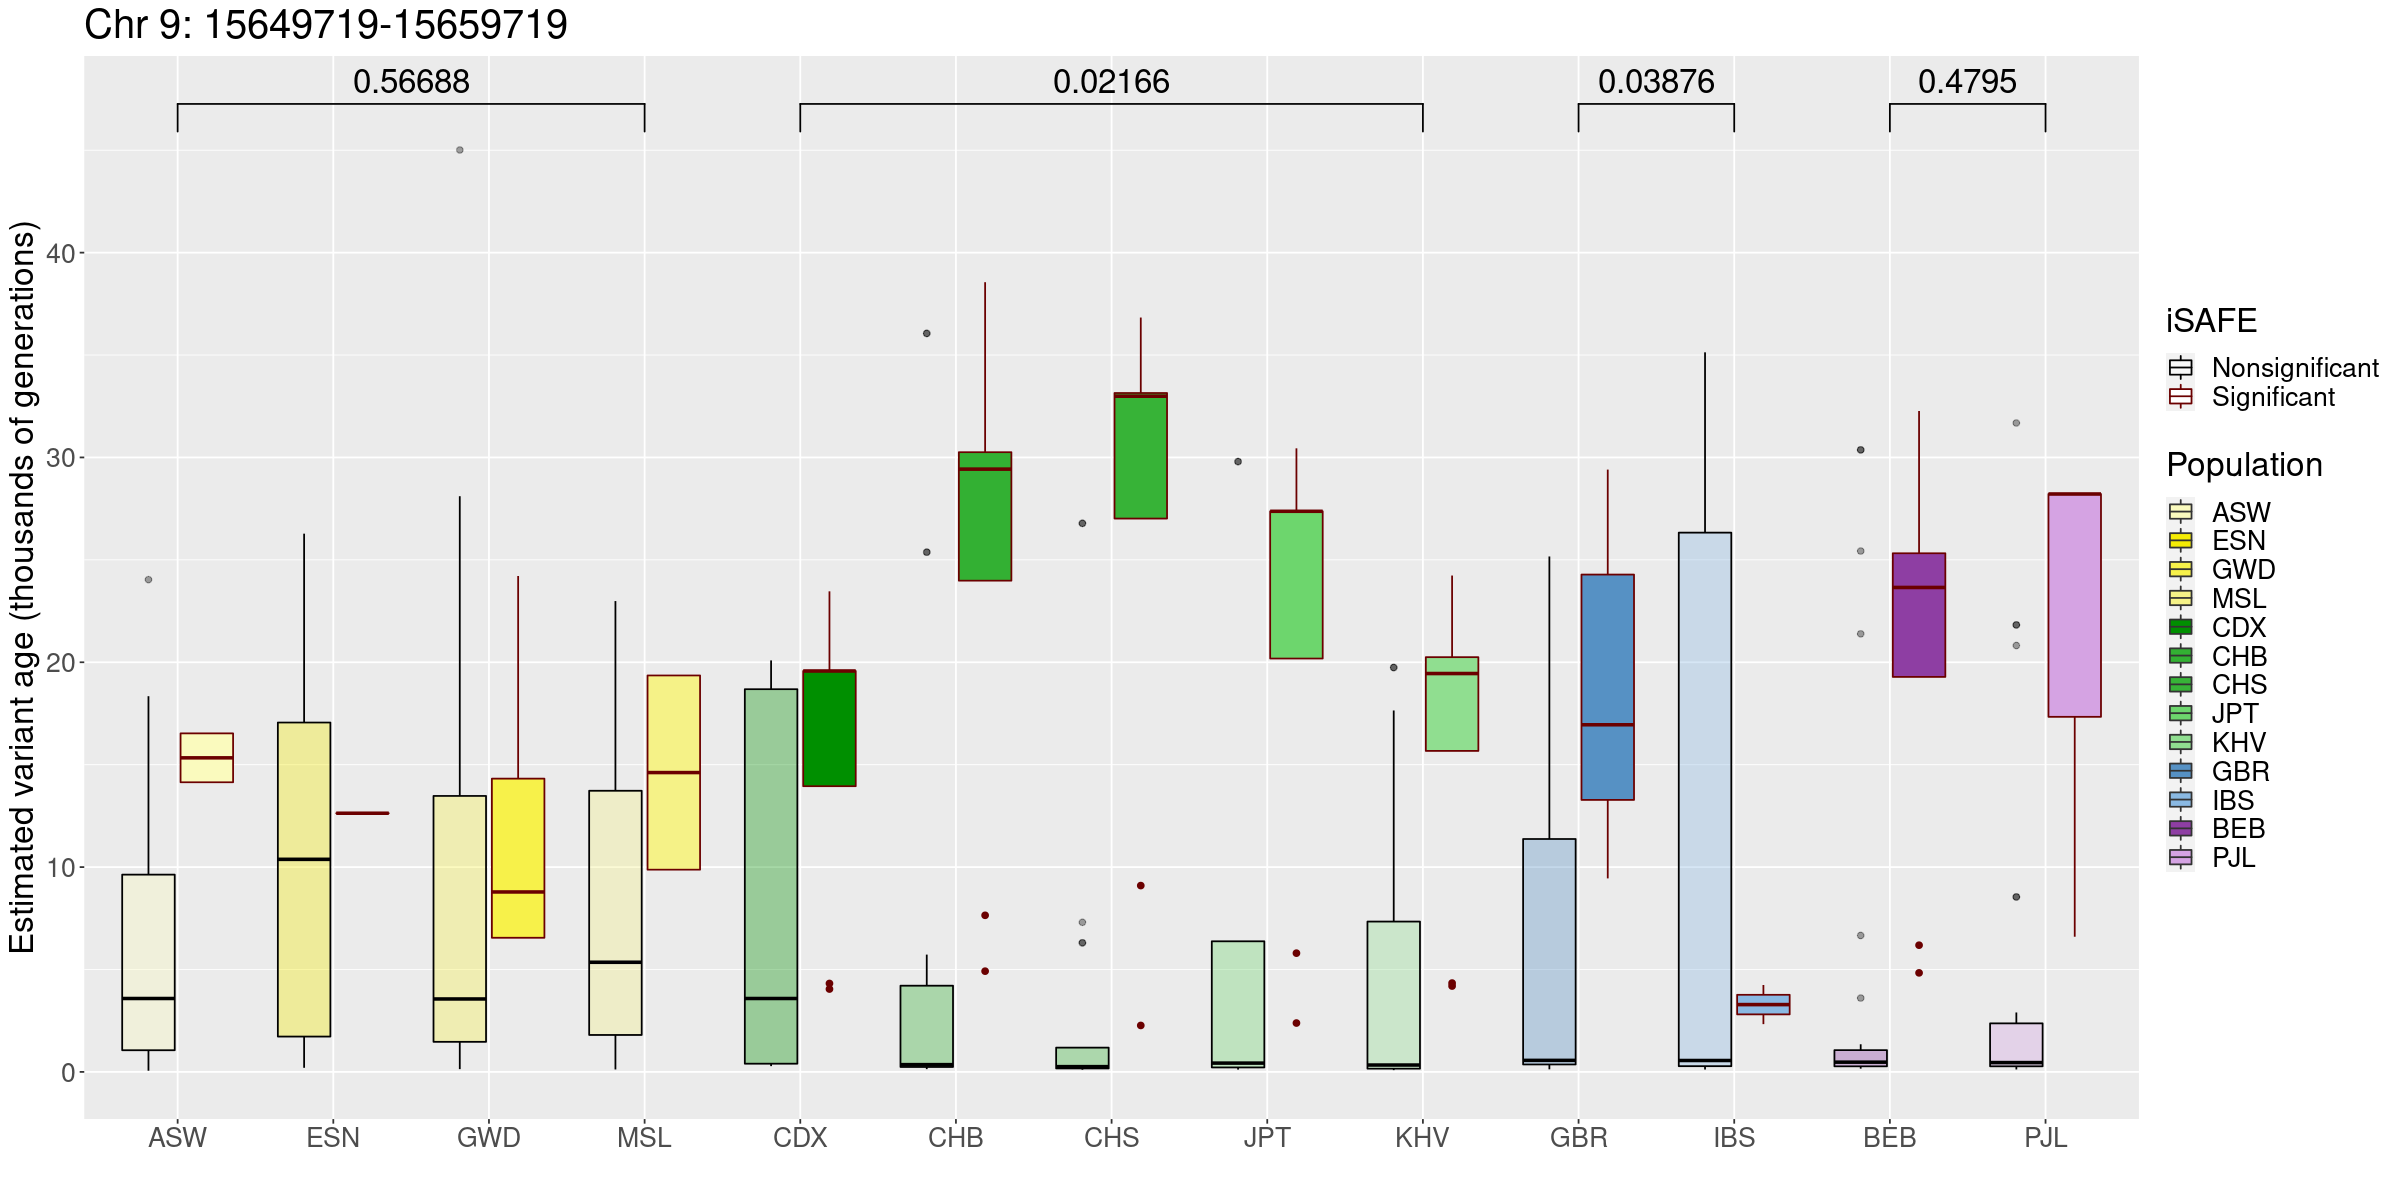

In [61]:
diferencia_edats(9, 15649719, 15659719, AMR = FALSE) #CCDC171

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


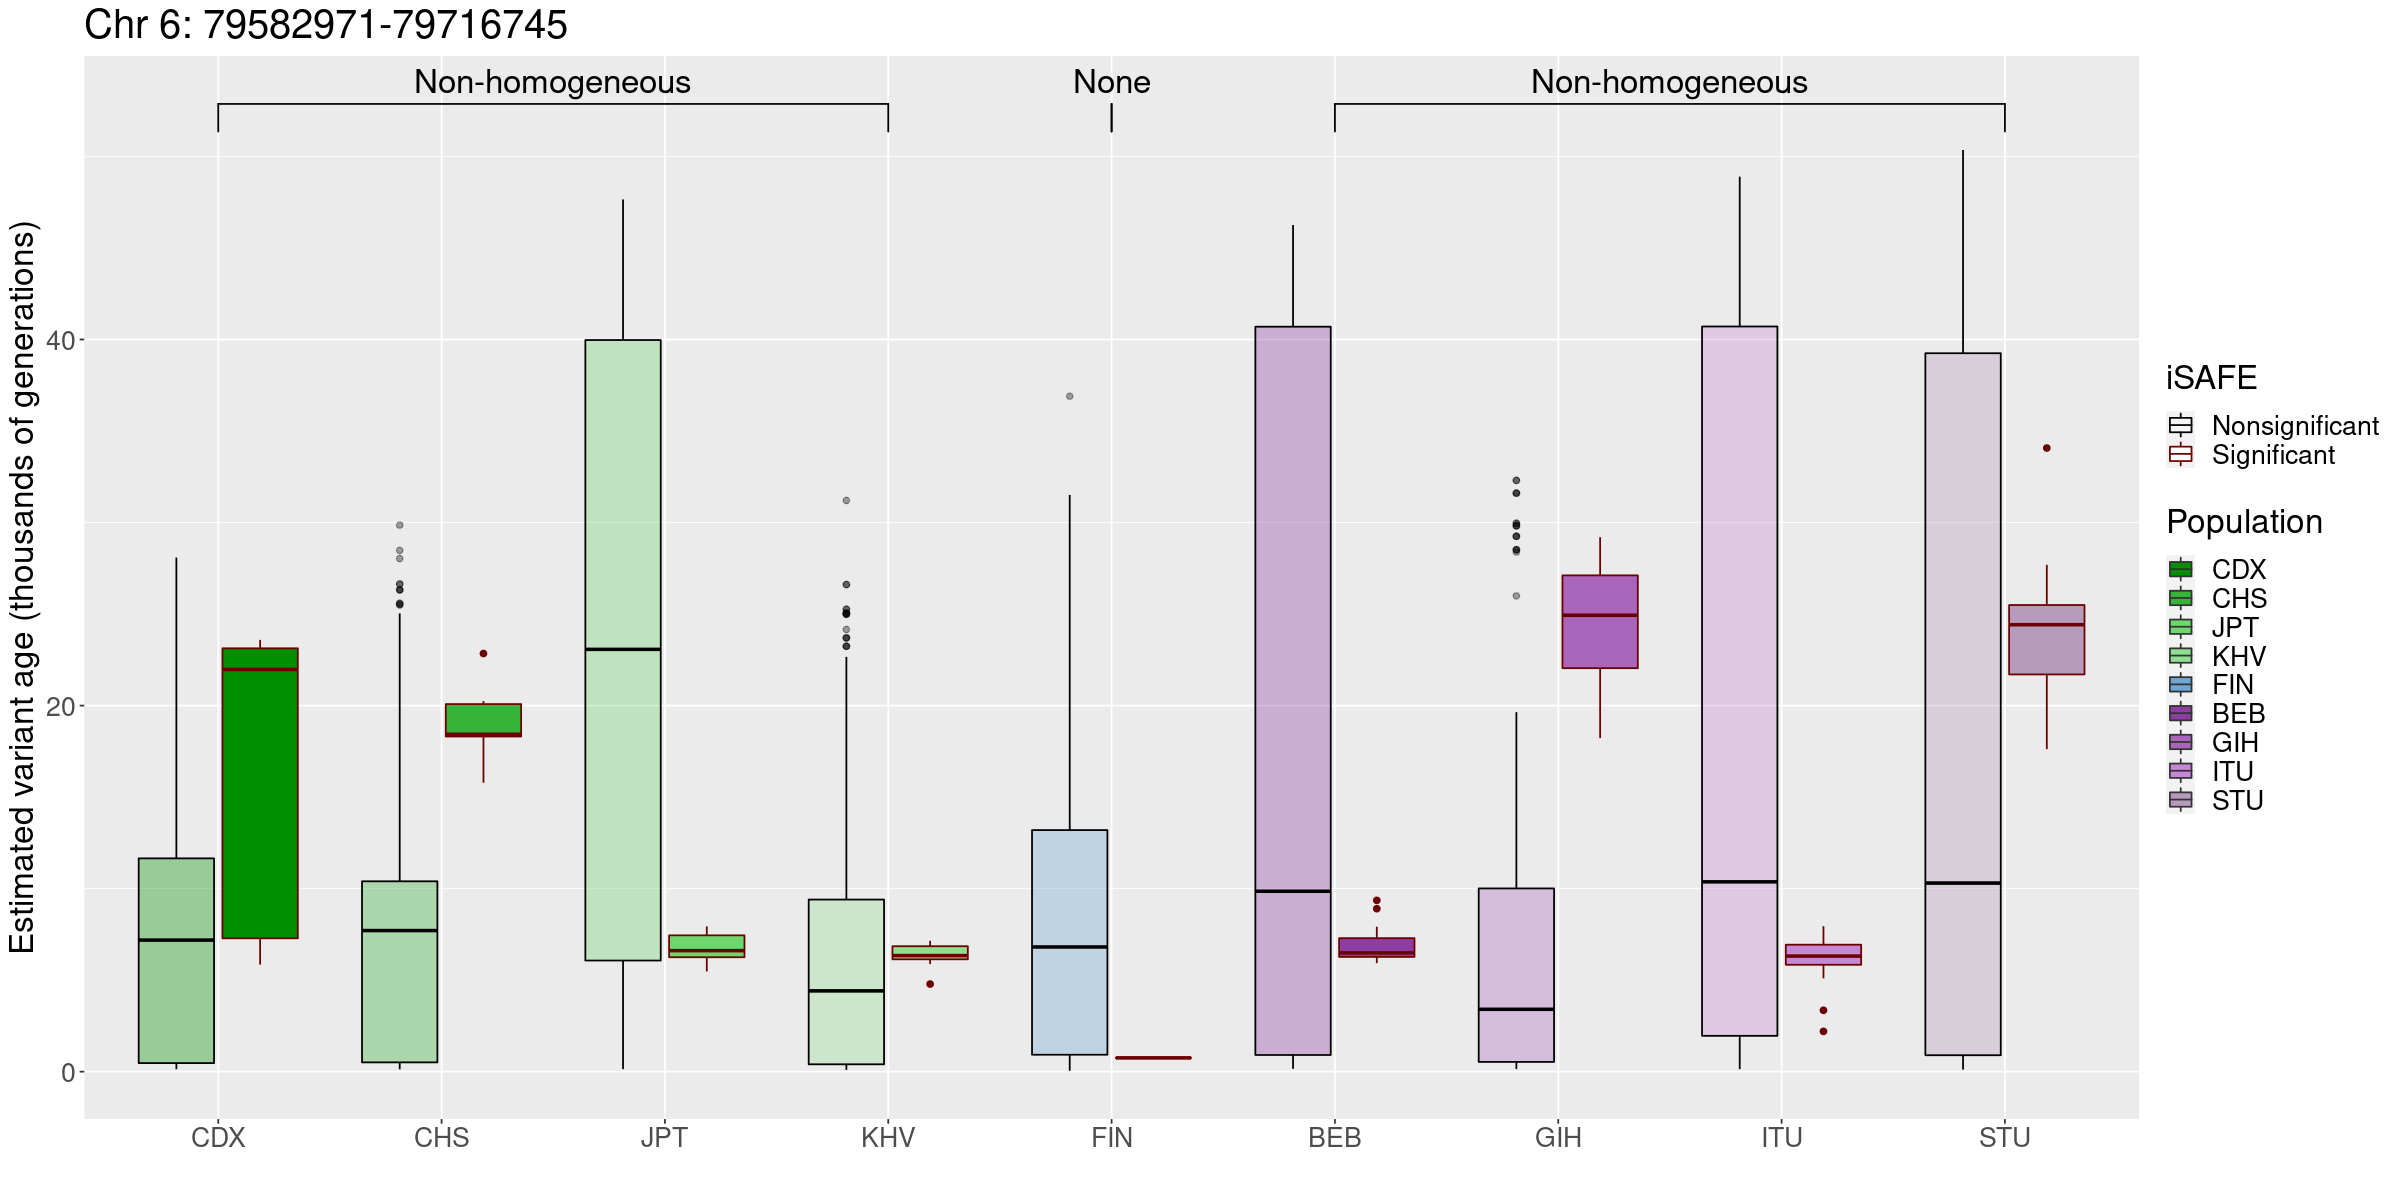

In [62]:
diferencia_edats(6, 79582971, 79716745, AMR = FALSE) #IRAK1BP1 Dona la sensació de que hi hagin hagut 2 sweeps selectius?

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


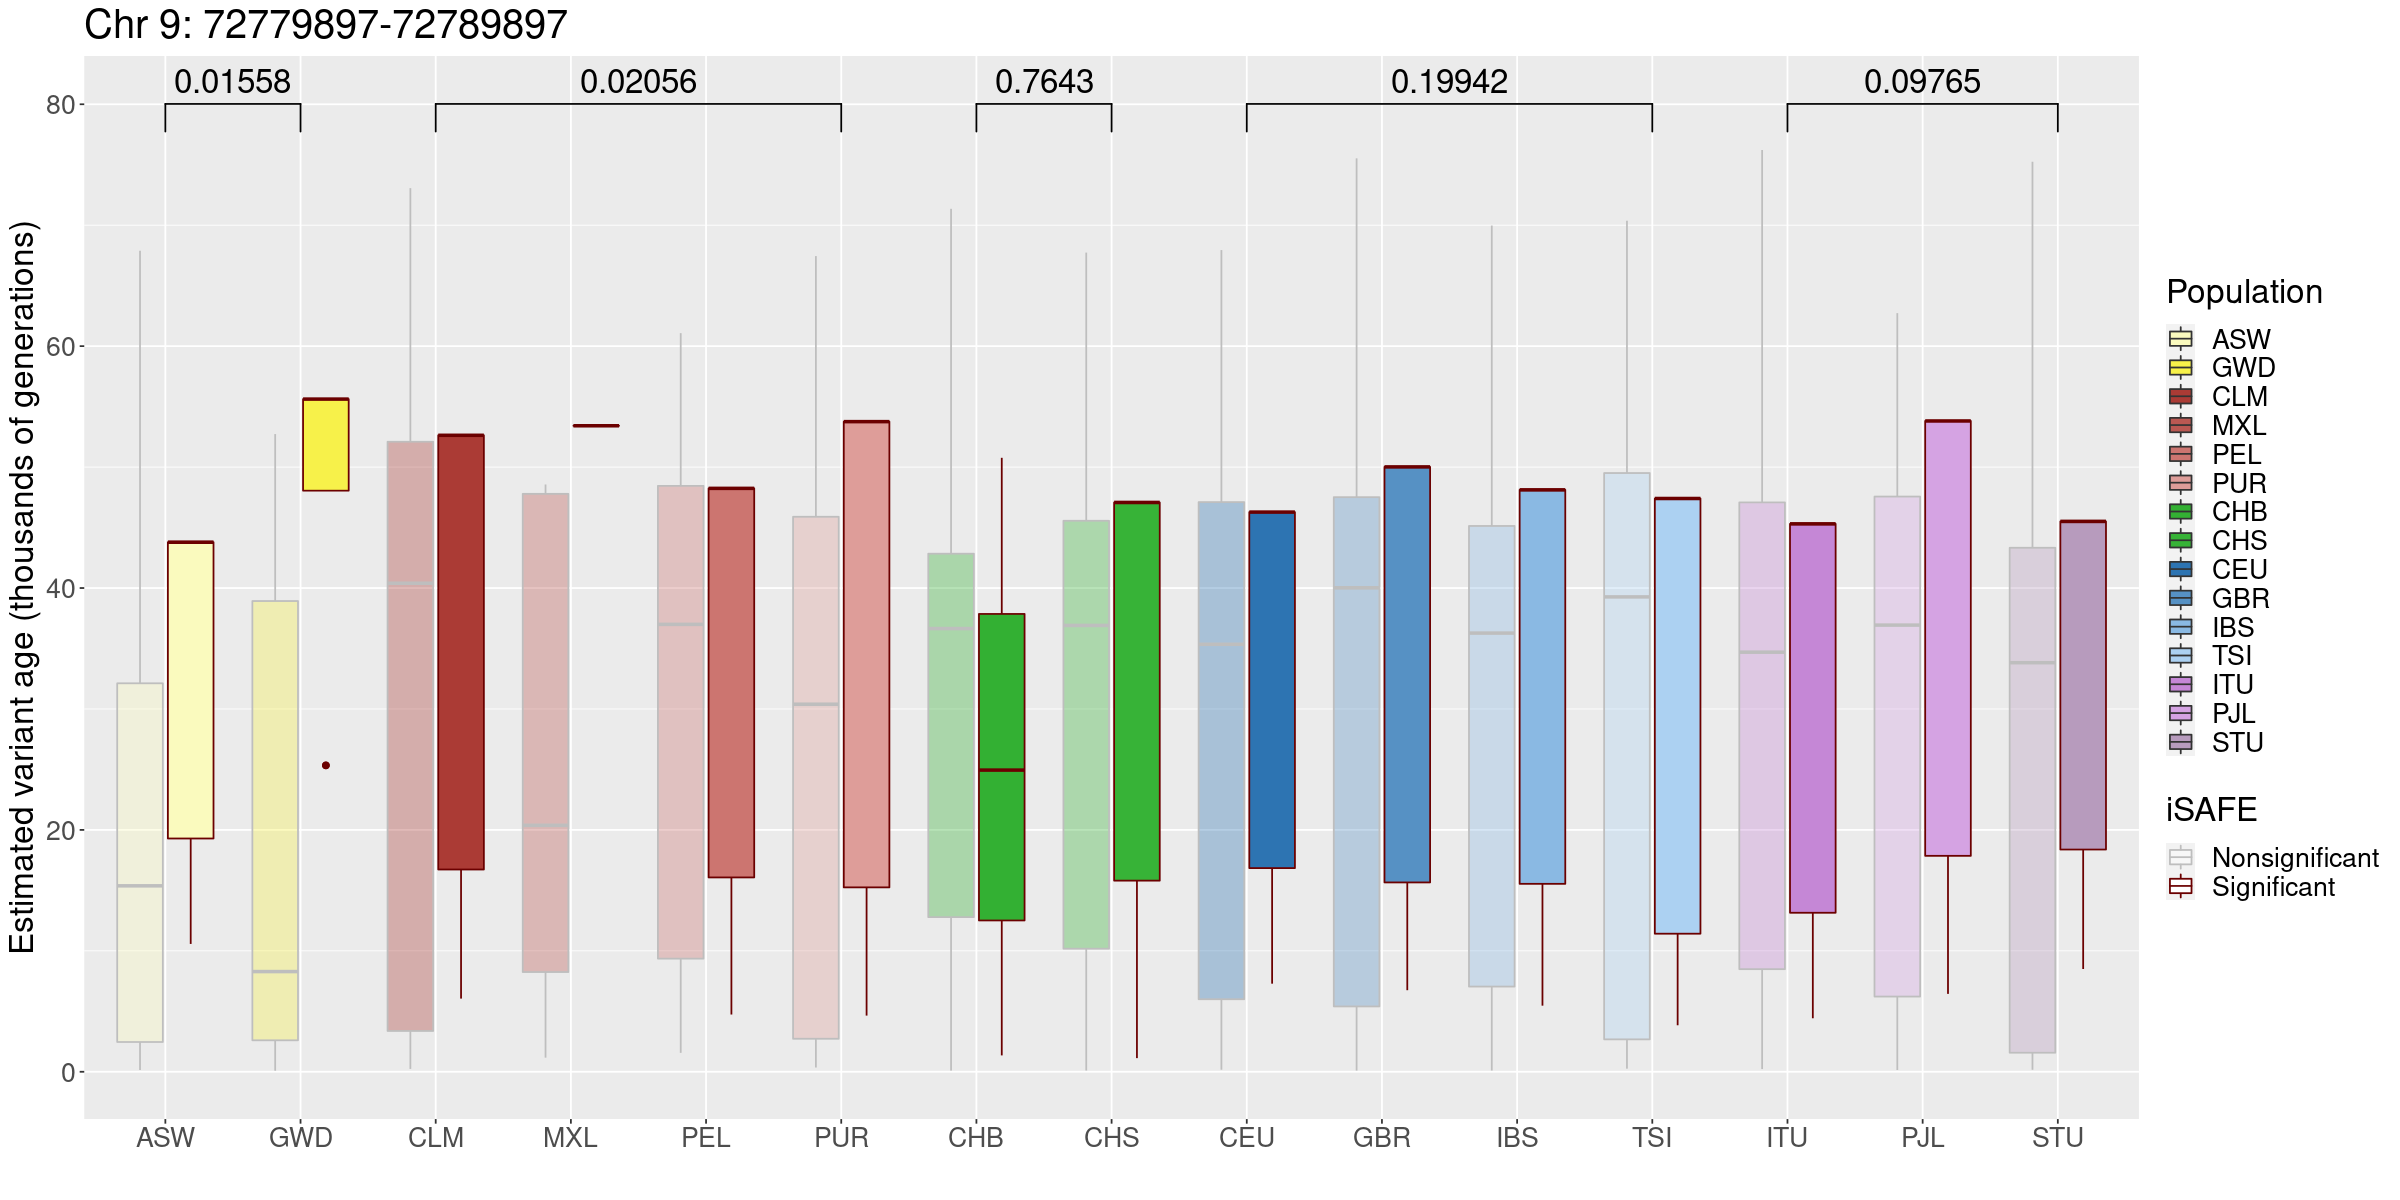

In [45]:
diferencia_edats(9, 72779897, 72789897) #MAMDC2

Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in anova.lm(lm(resp.mean ~ d)):
“ANOVA F-tests on an essentially perfect fit are unreliable”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


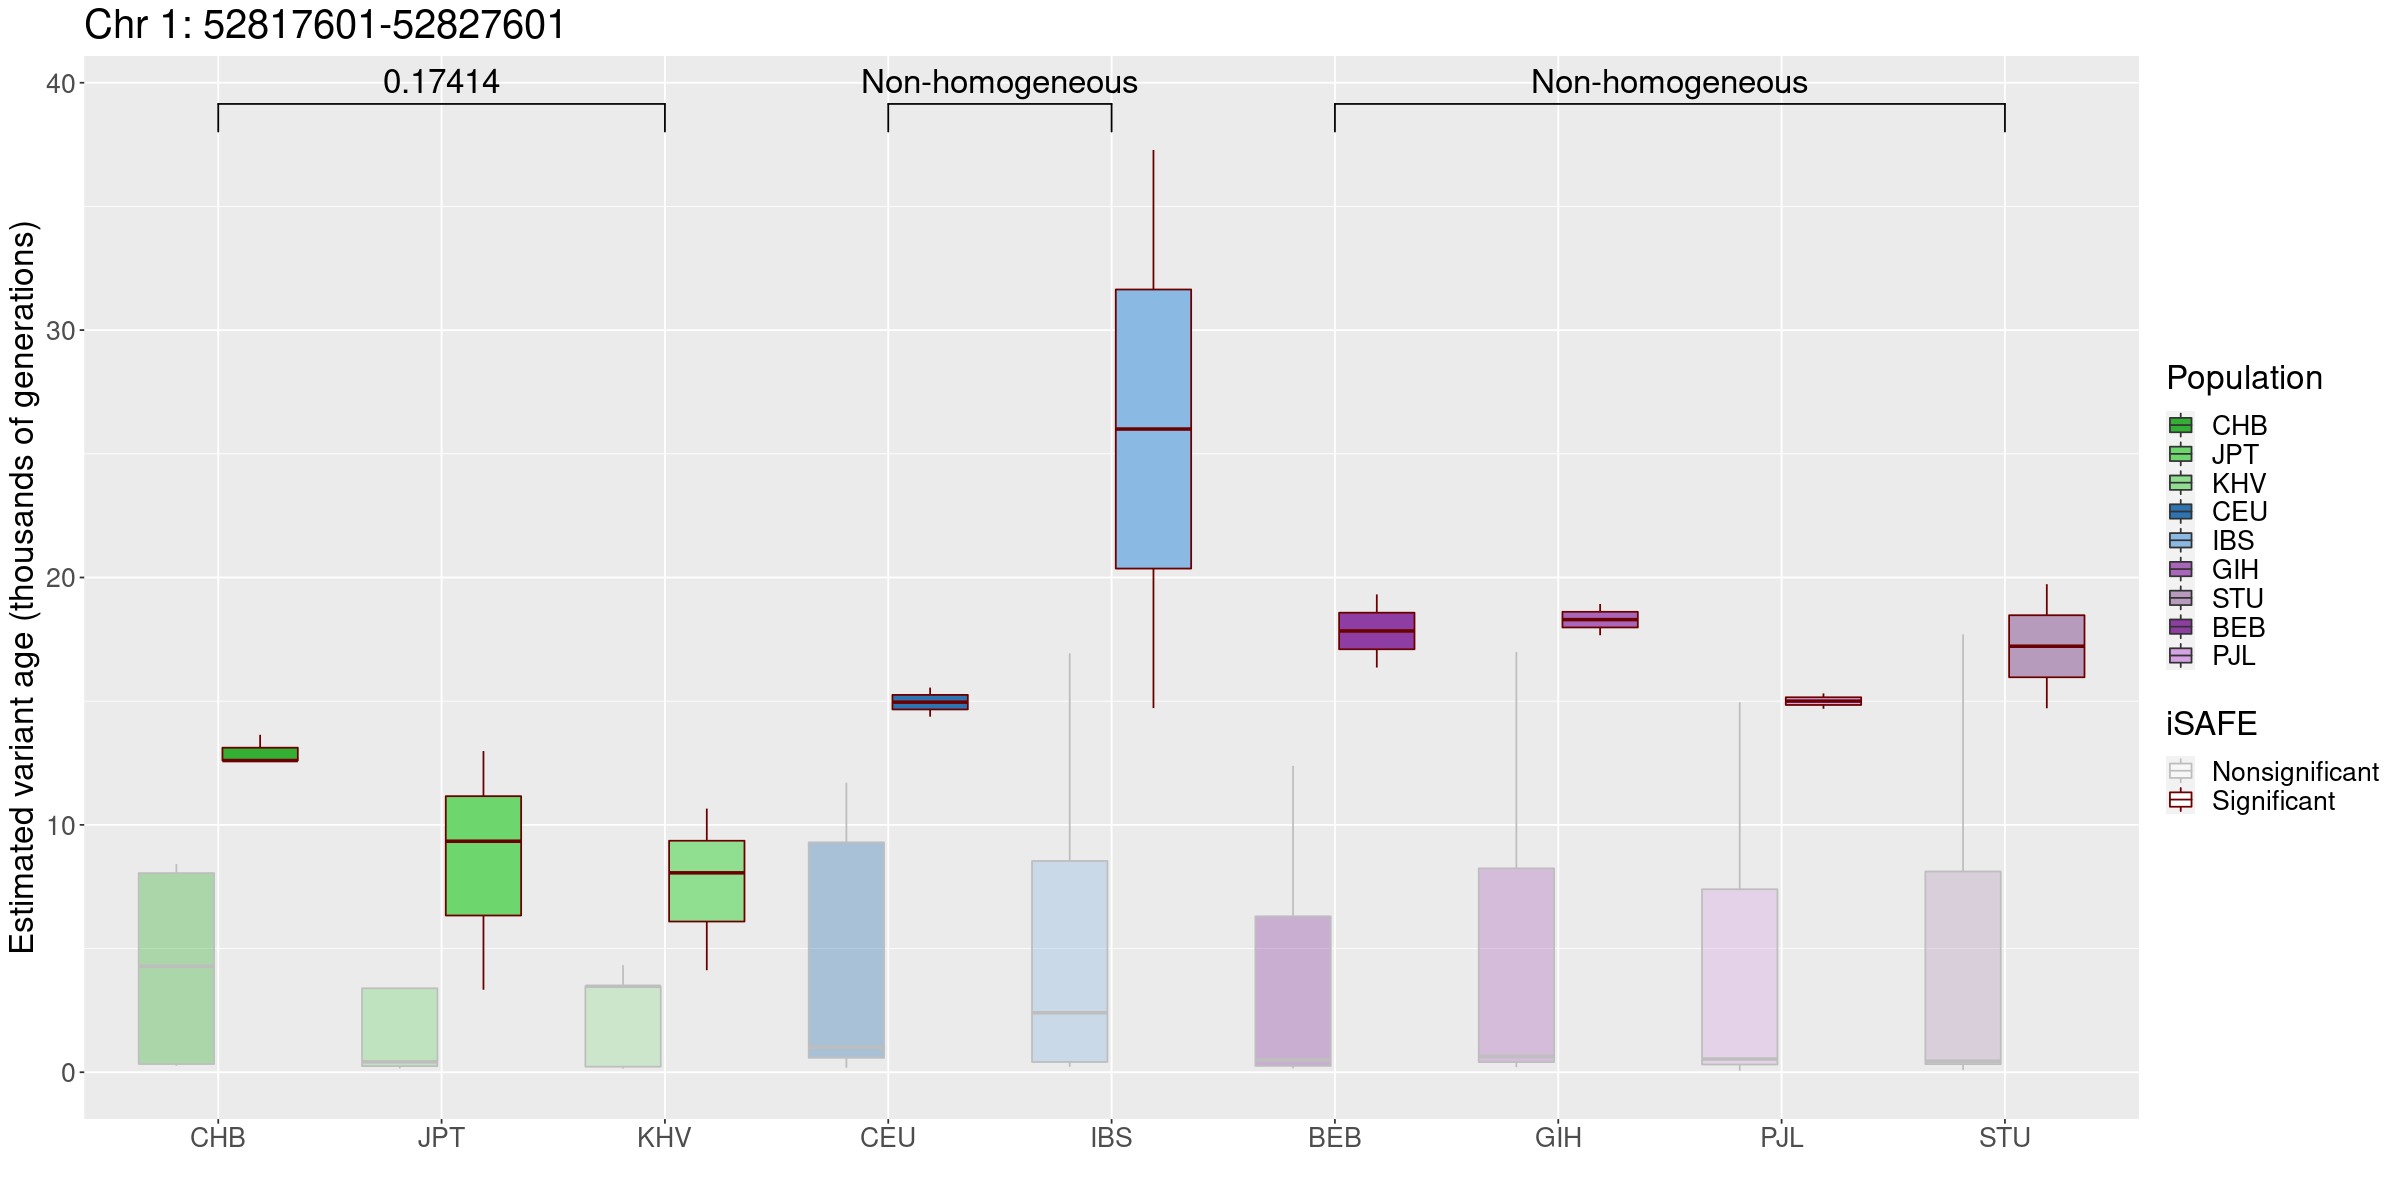

In [44]:
diferencia_edats(1, 52817601, 52827601, AMR = FALSE)  #CC2D1B

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


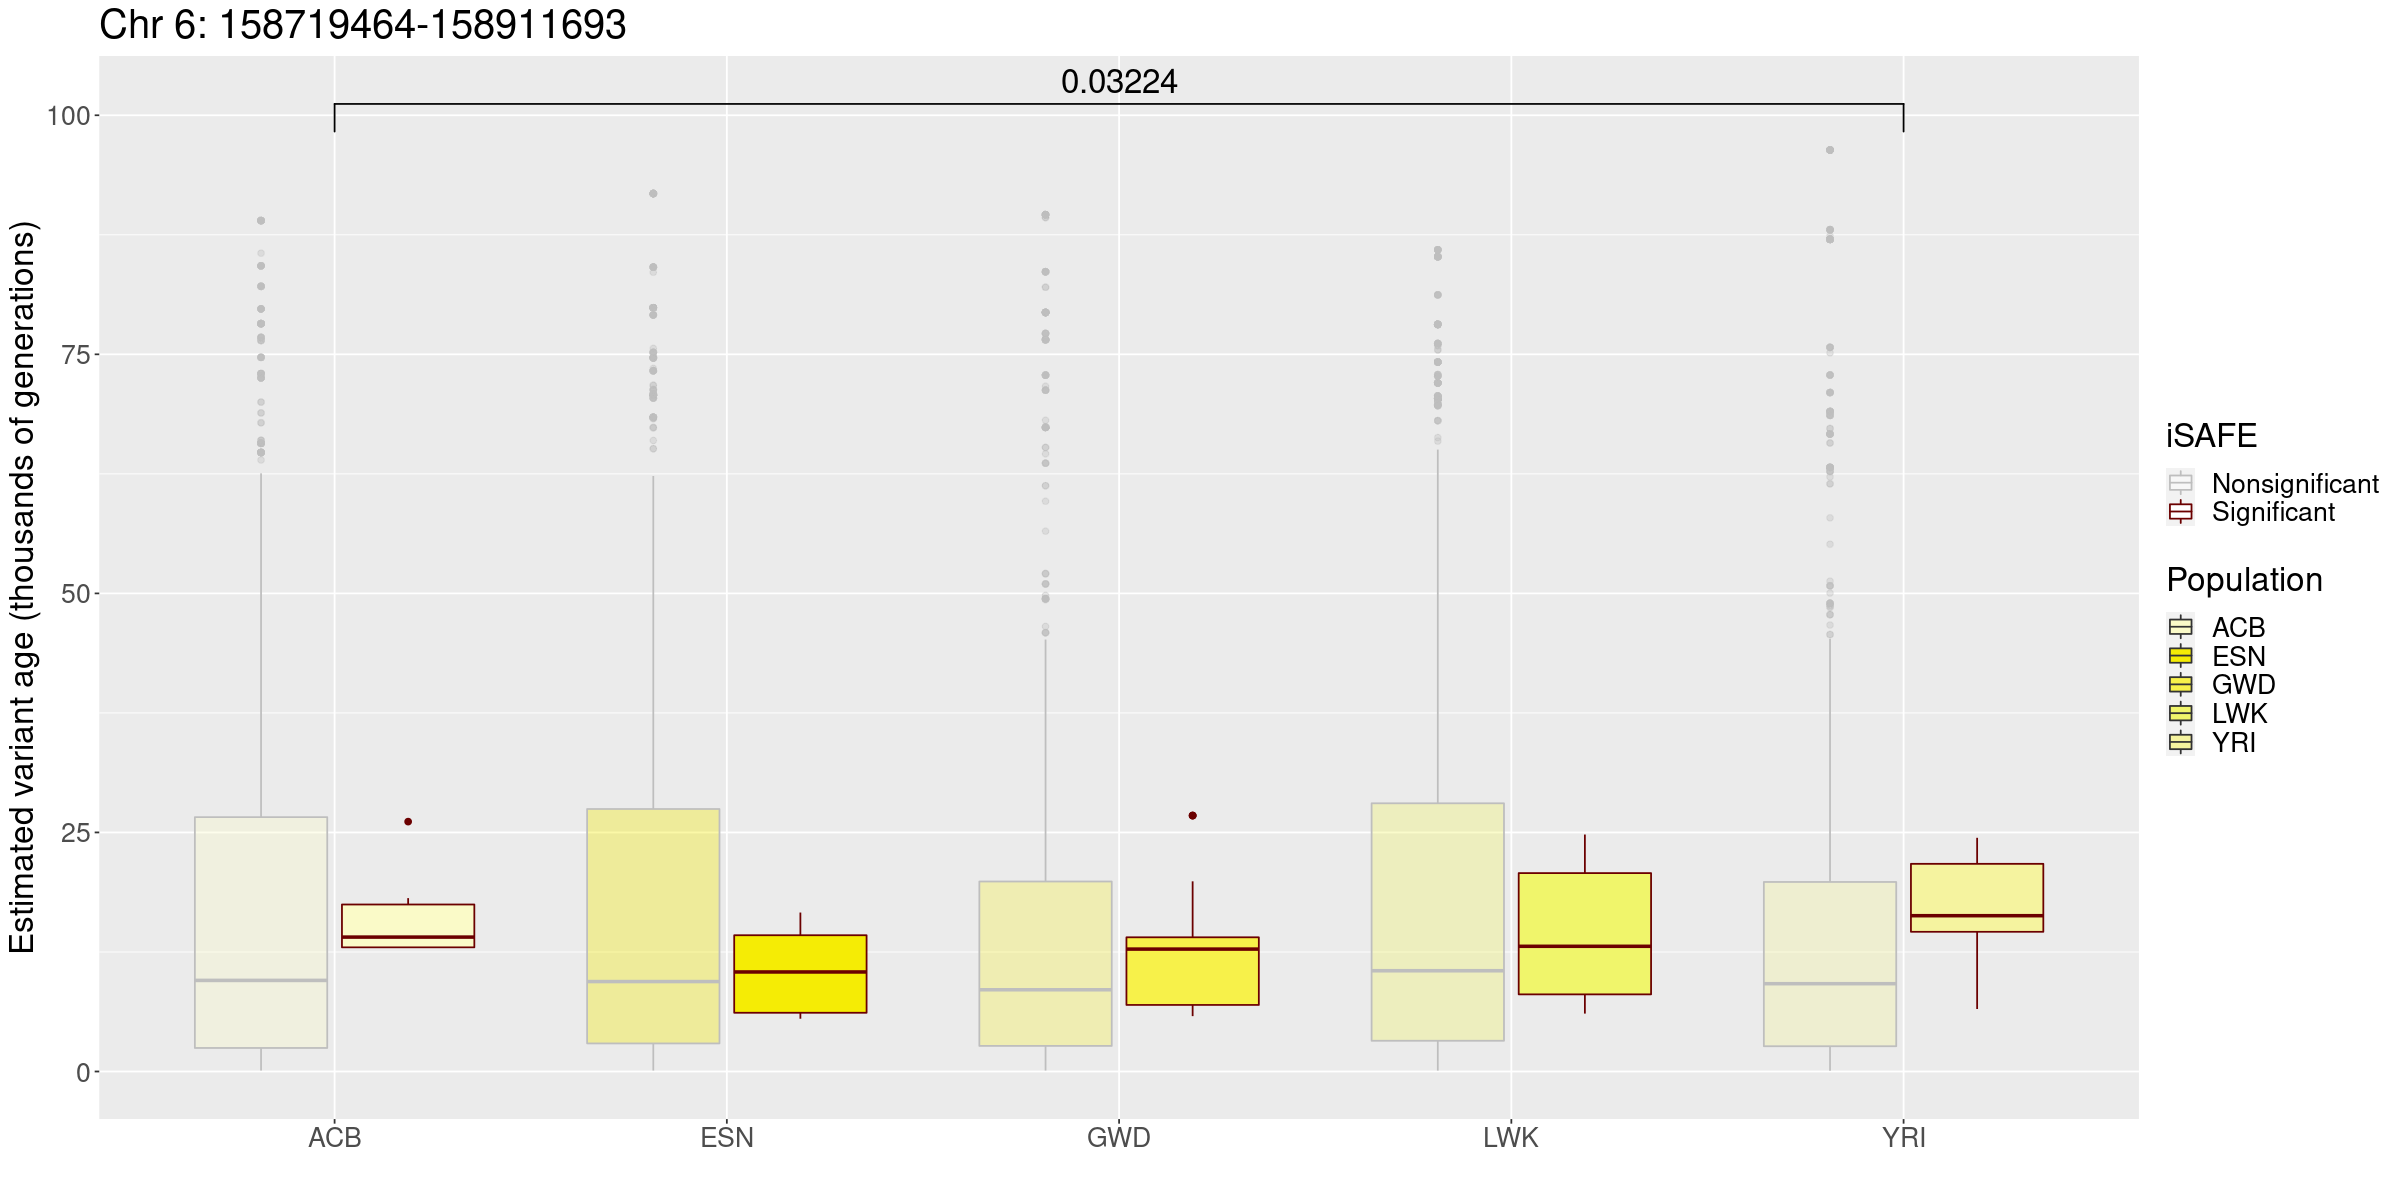

In [43]:
diferencia_edats(6,158719464,158911693, AMR = FALSE)  

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


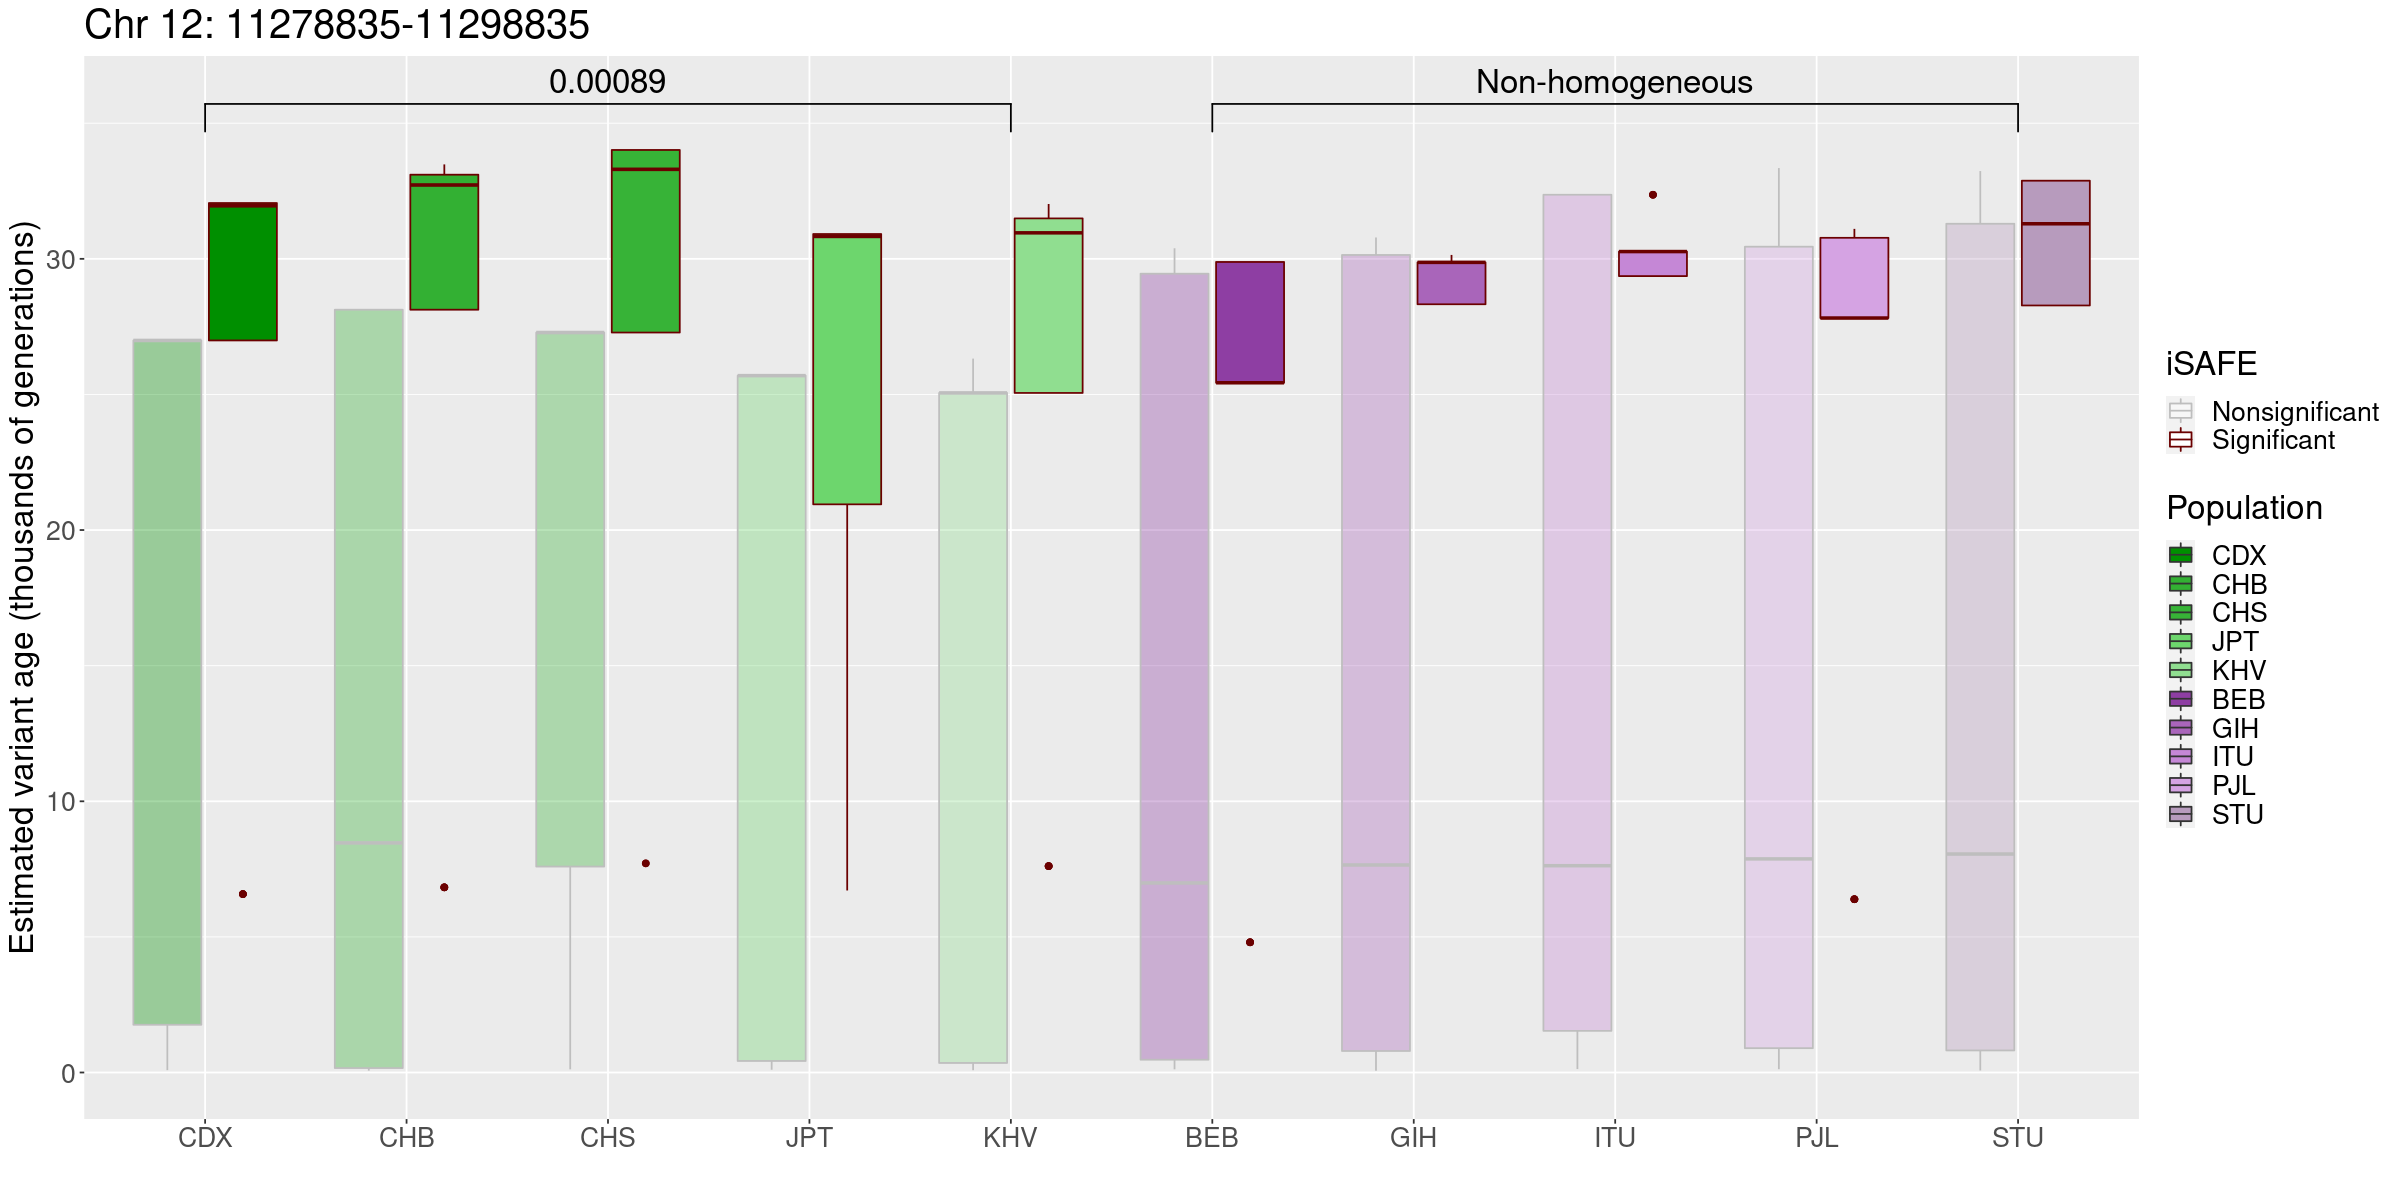

In [42]:
diferencia_edats(12, 11278835, 11298835, AMR = FALSE) #PRR4,TAS2R14,PRH1,TAS2R30,AC018630.6

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


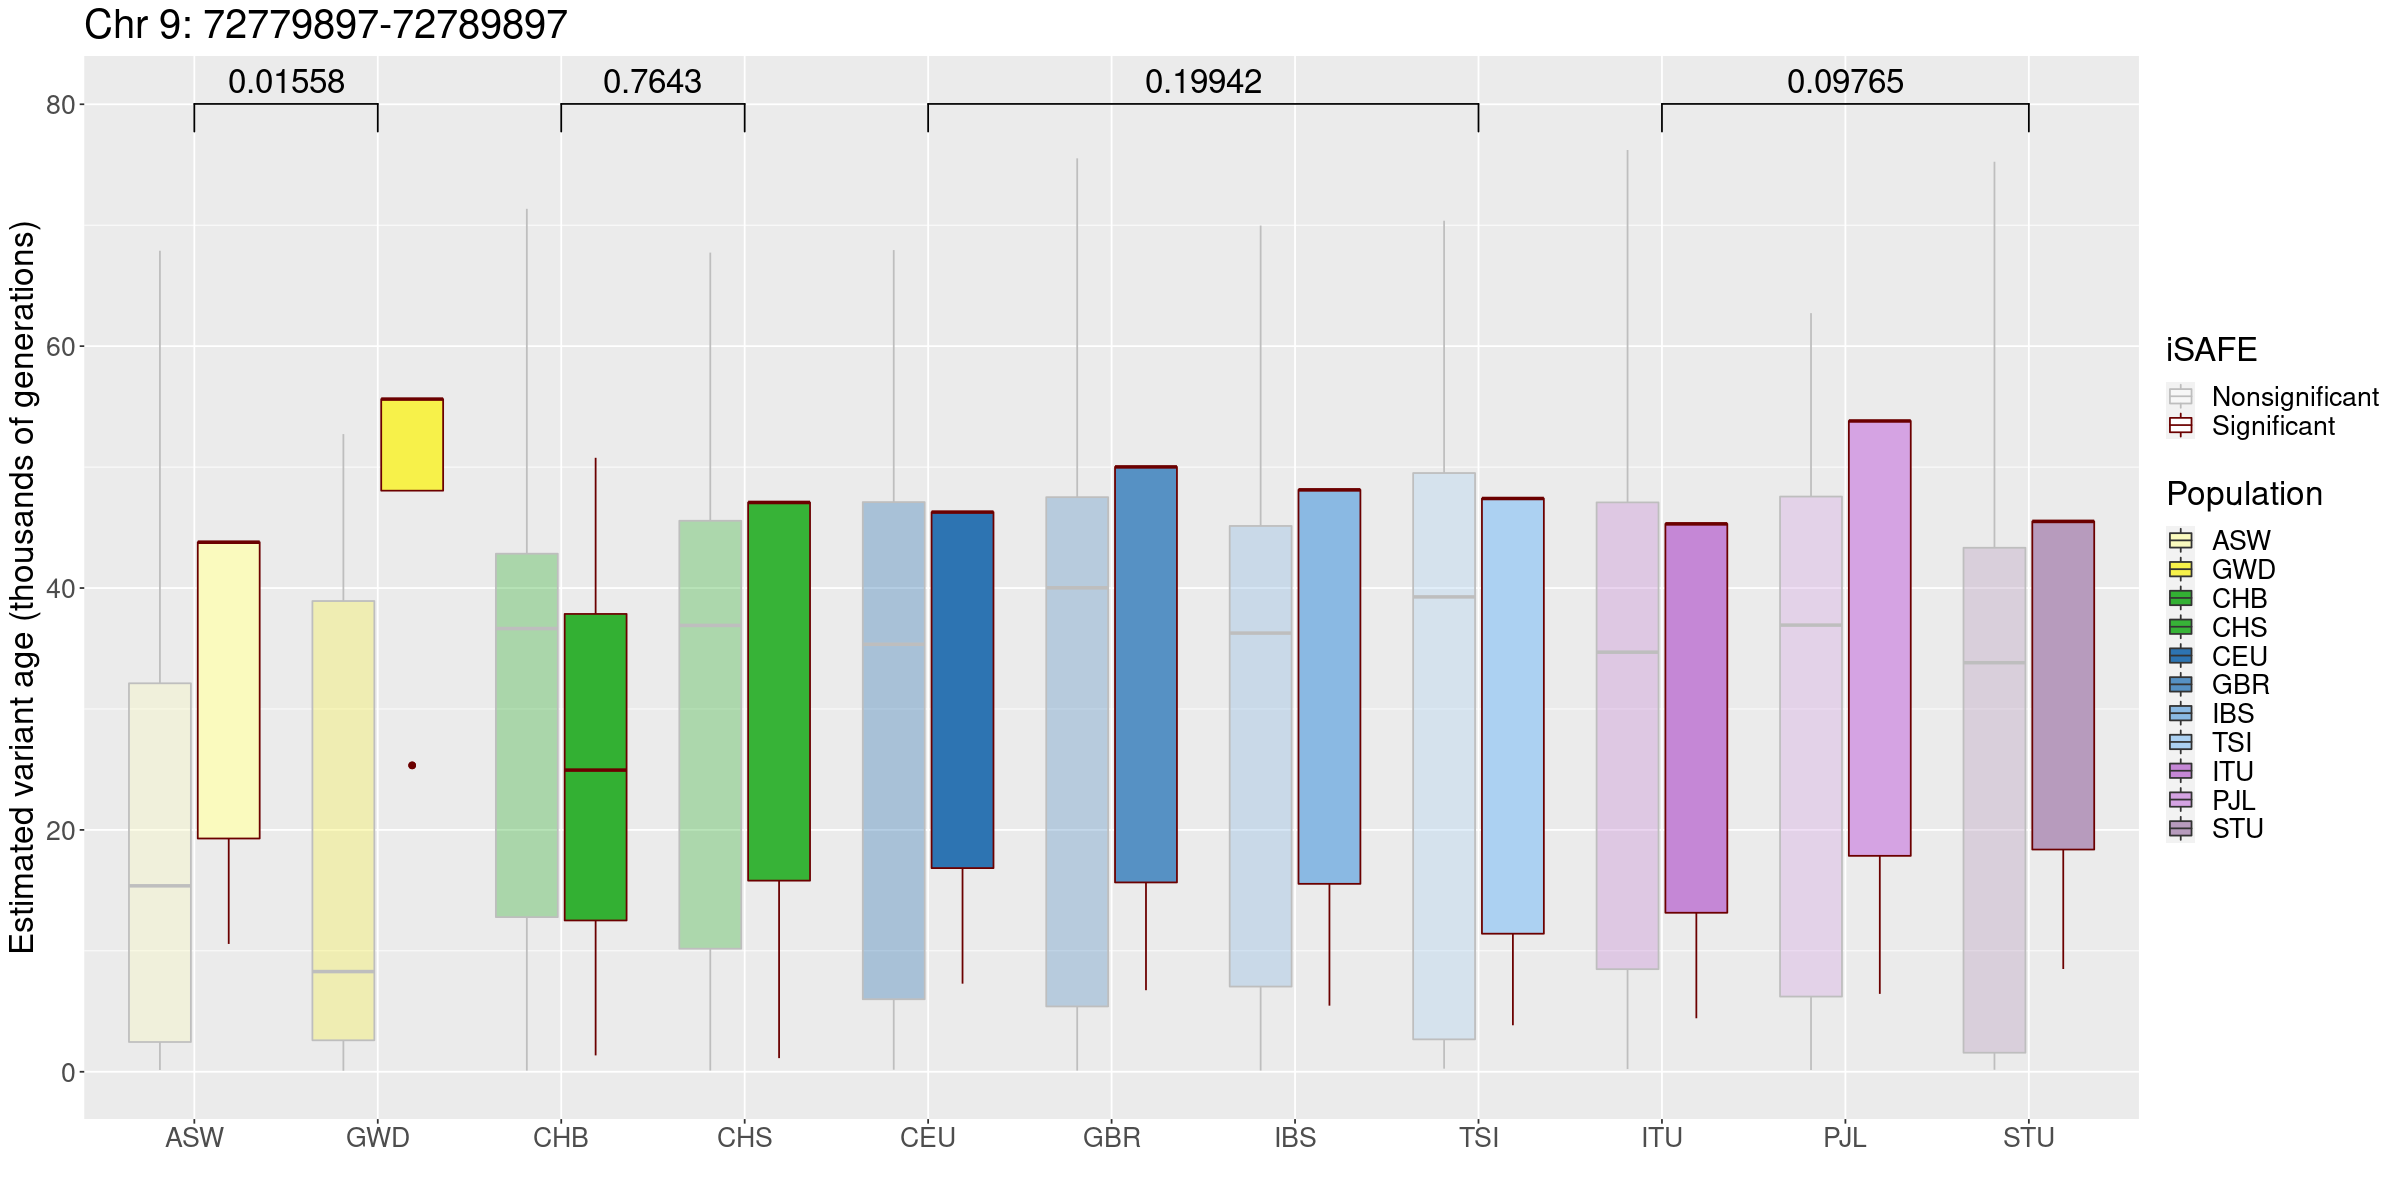

In [41]:
diferencia_edats(9, 72779897, 72789897, AMR = FALSE) 

In [24]:
head(fread('/home/anoguera/Data/relate_ages/allele_ages_chr19.csv', nrows = 6))

CHR,BP,ID,lower_age,upper_age,ancestral/derived,upstream,downstream,DAF,pvalue,pop
<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>
19,93762,19:93762:T:C,0.000,162.117,T/C,A,T,1,NA,YRI
19,103768,rs2854663:103768:C:A,0.000,162.117,C/A,A,A,1,NA,YRI
19,241965,rs138699675:241965:A:G,202.482,303.513,A/G,C,T,8,NA,YRI
19,242058,rs140622195:242058:G:A,225.513,1414.510,G/A,G,G,2,NA,YRI
19,242674,19:242674:T:A,773.742,22950.800,T/A,A,G,2,NA,YRI
19,251610,19:251610:C:A,773.742,22950.800,C/A,C,T,2,NA,YRI


Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


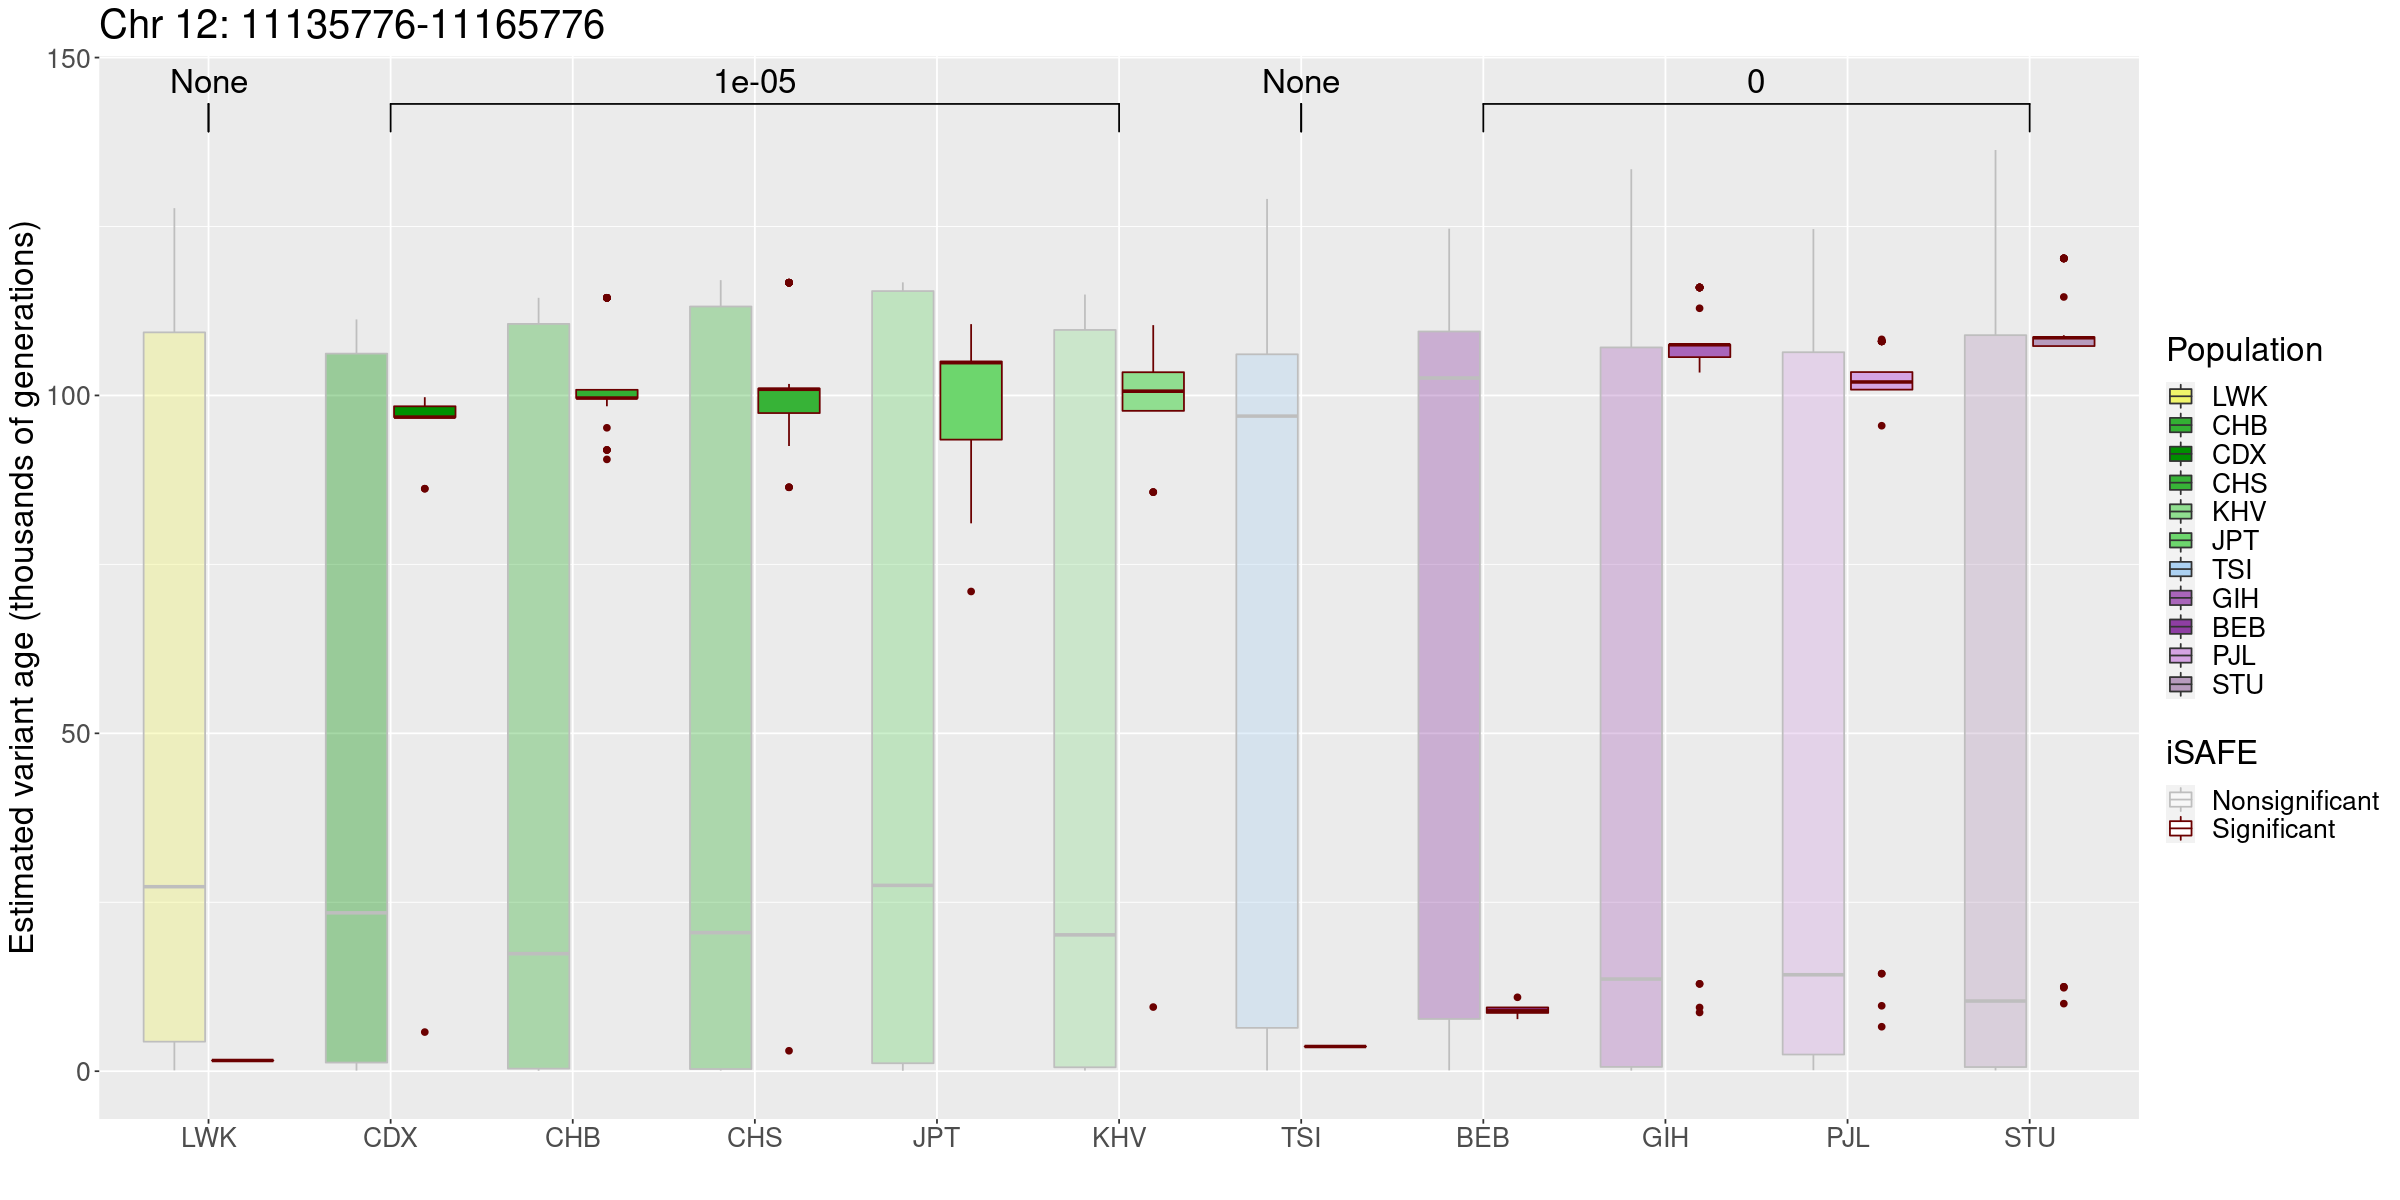

In [40]:
diferencia_edats(12,11135776,11165776,AMR = FALSE) #PRR4, TAS2R50, TAS2R14, PRH1, AC018630.6, TAS2R20 (el que dona significatiu per bitter taste a edats tan antigues

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


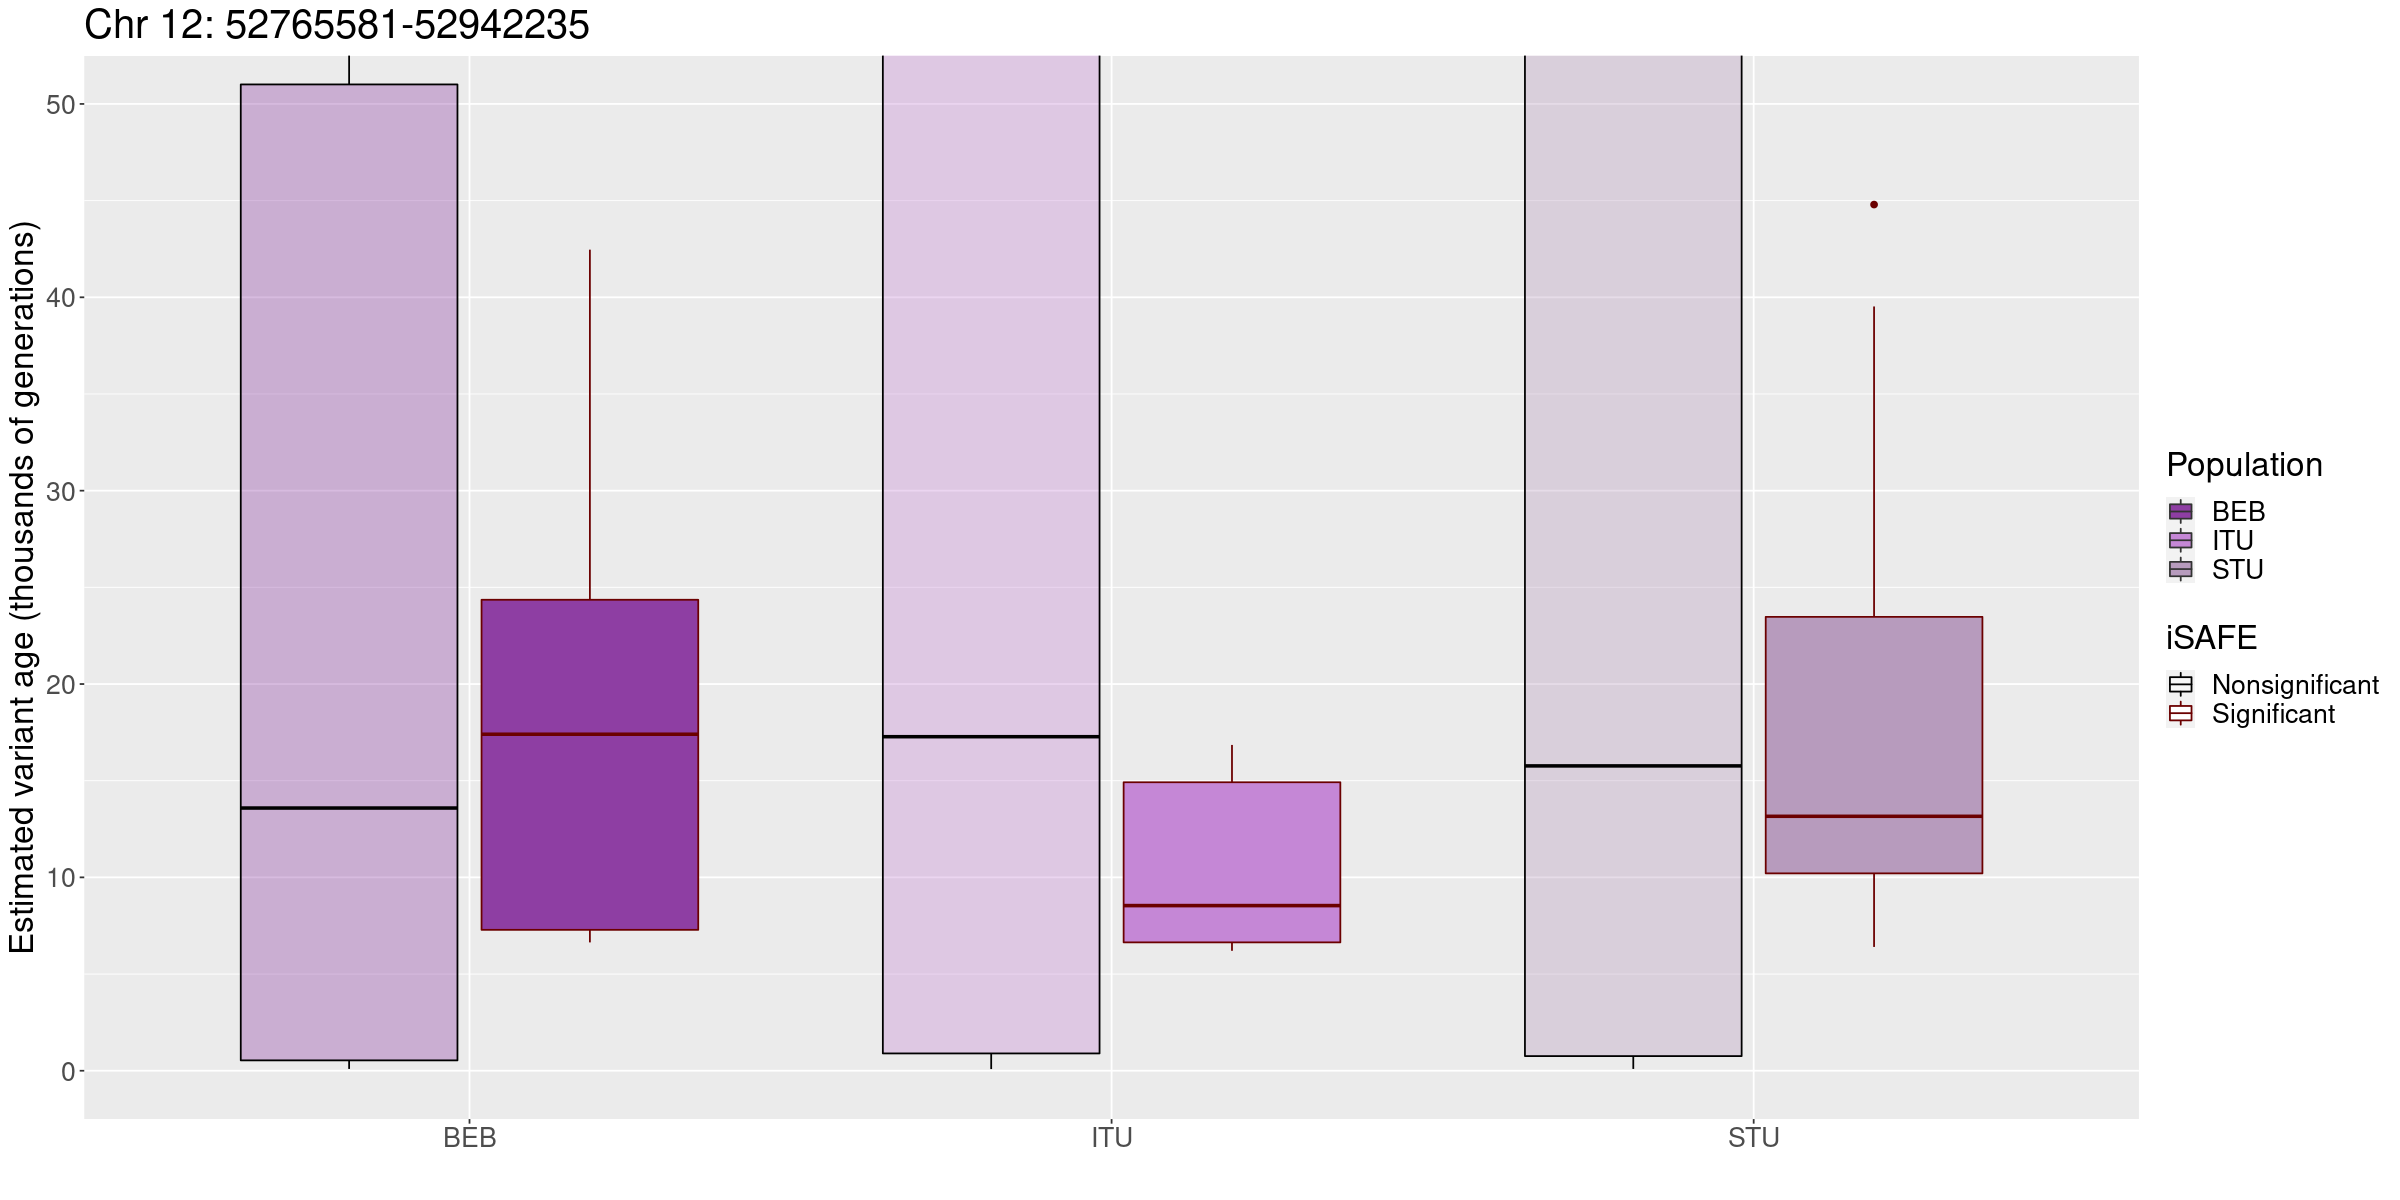

In [9]:
diferencia_edats5(12,52765581,52942235,AMR = FALSE) + coord_cartesian(ylim = c(0, 50)) #El cluster de gens de queratina

## Comprovació lactasa

In [30]:
graficLCT <- diferencia_edats(2,135792491,136822774,AMR = FALSE)  #LCT

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


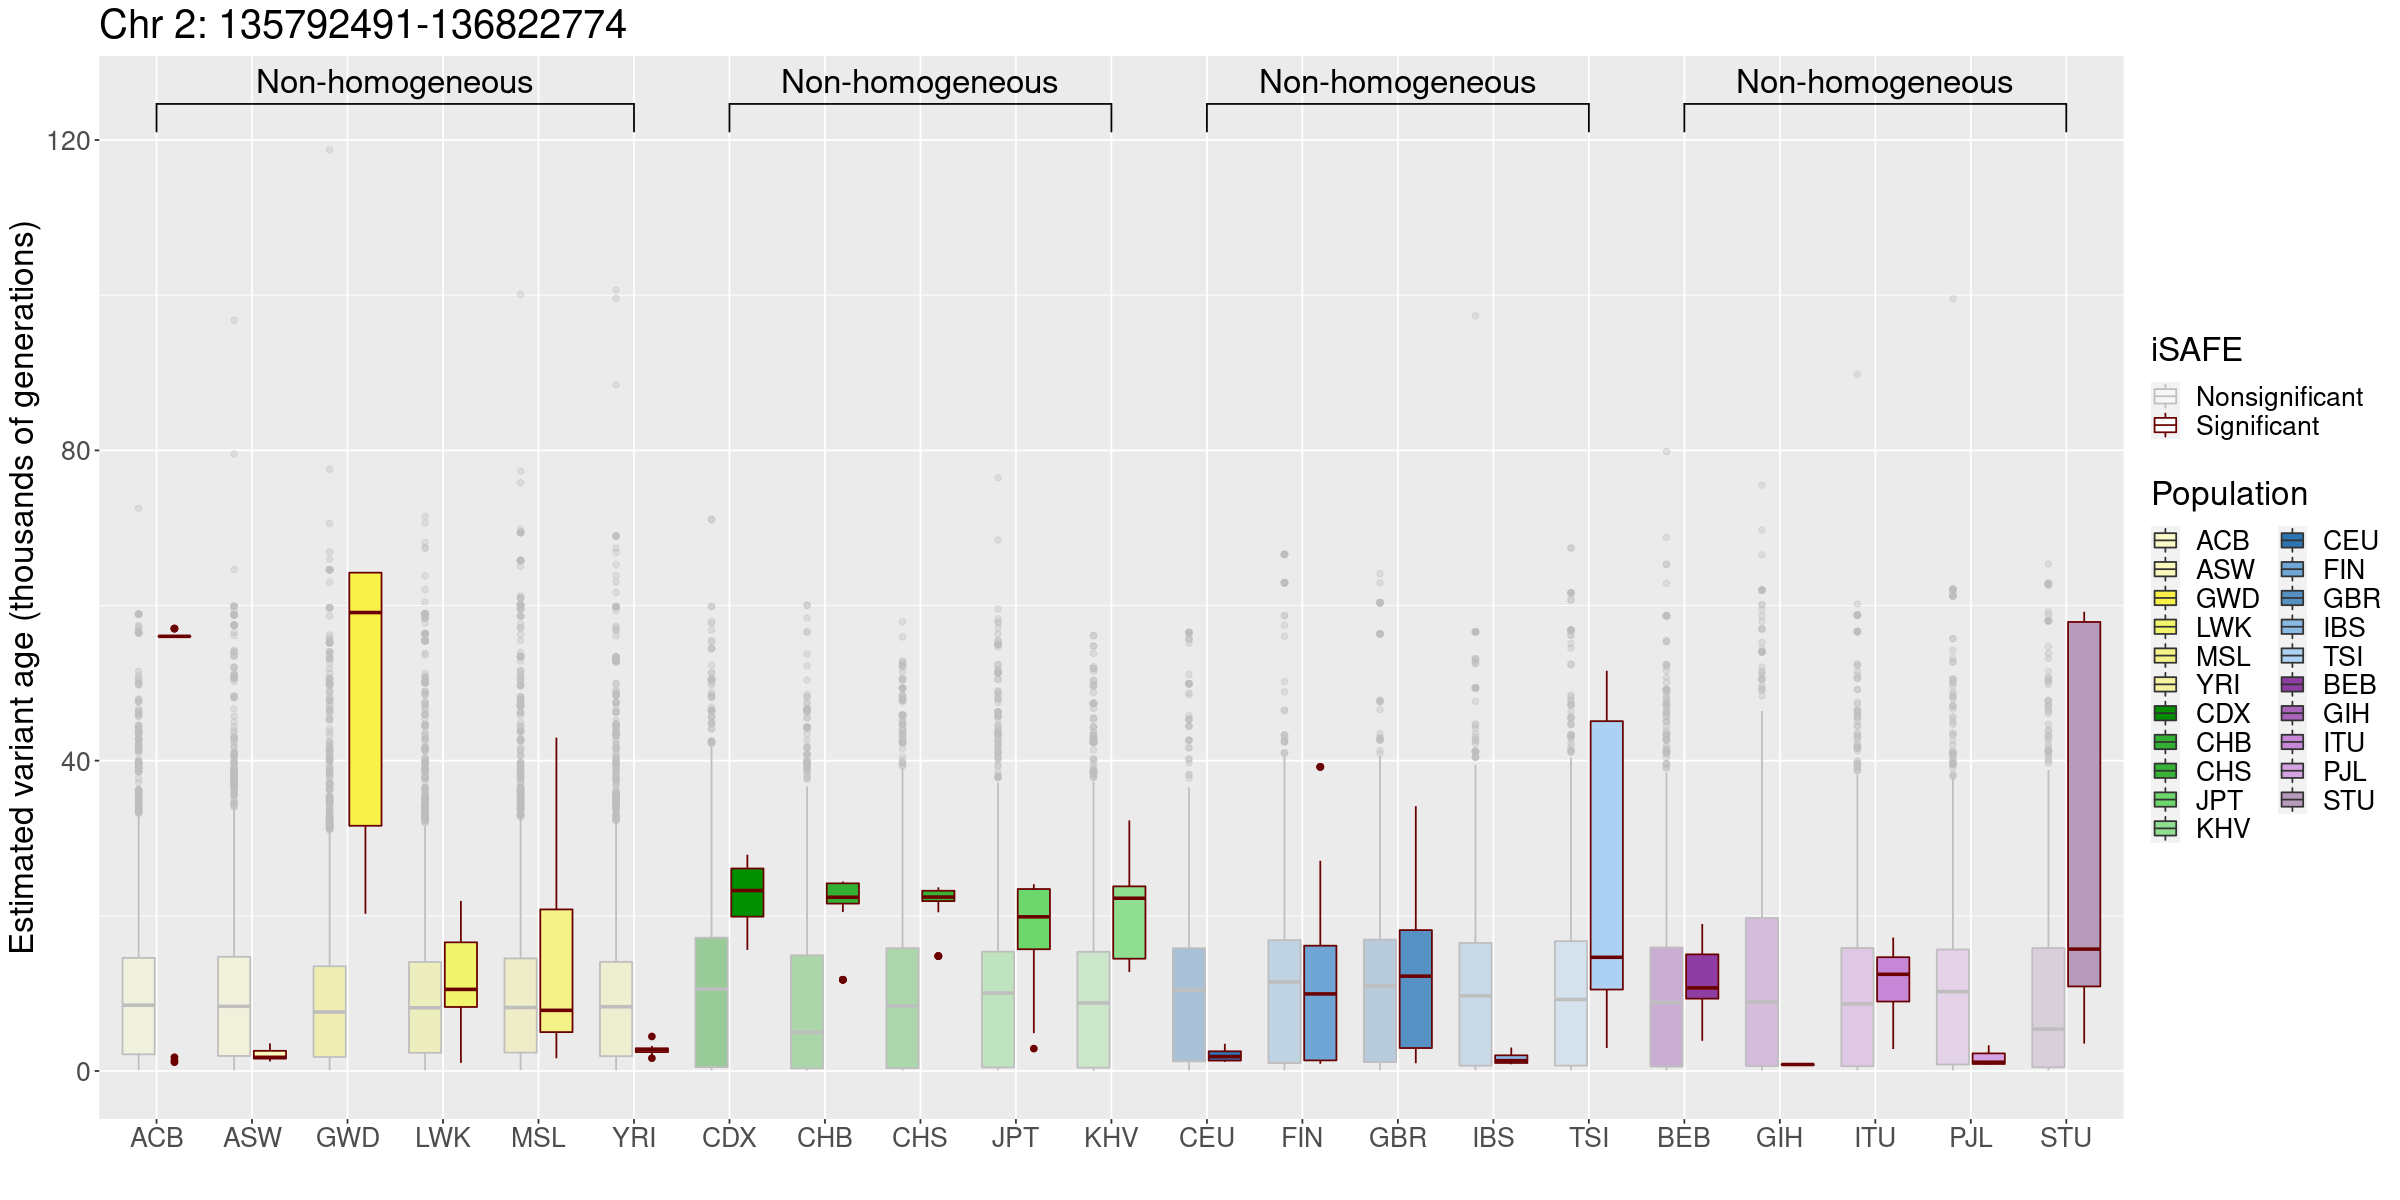

In [31]:
graficLCT

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


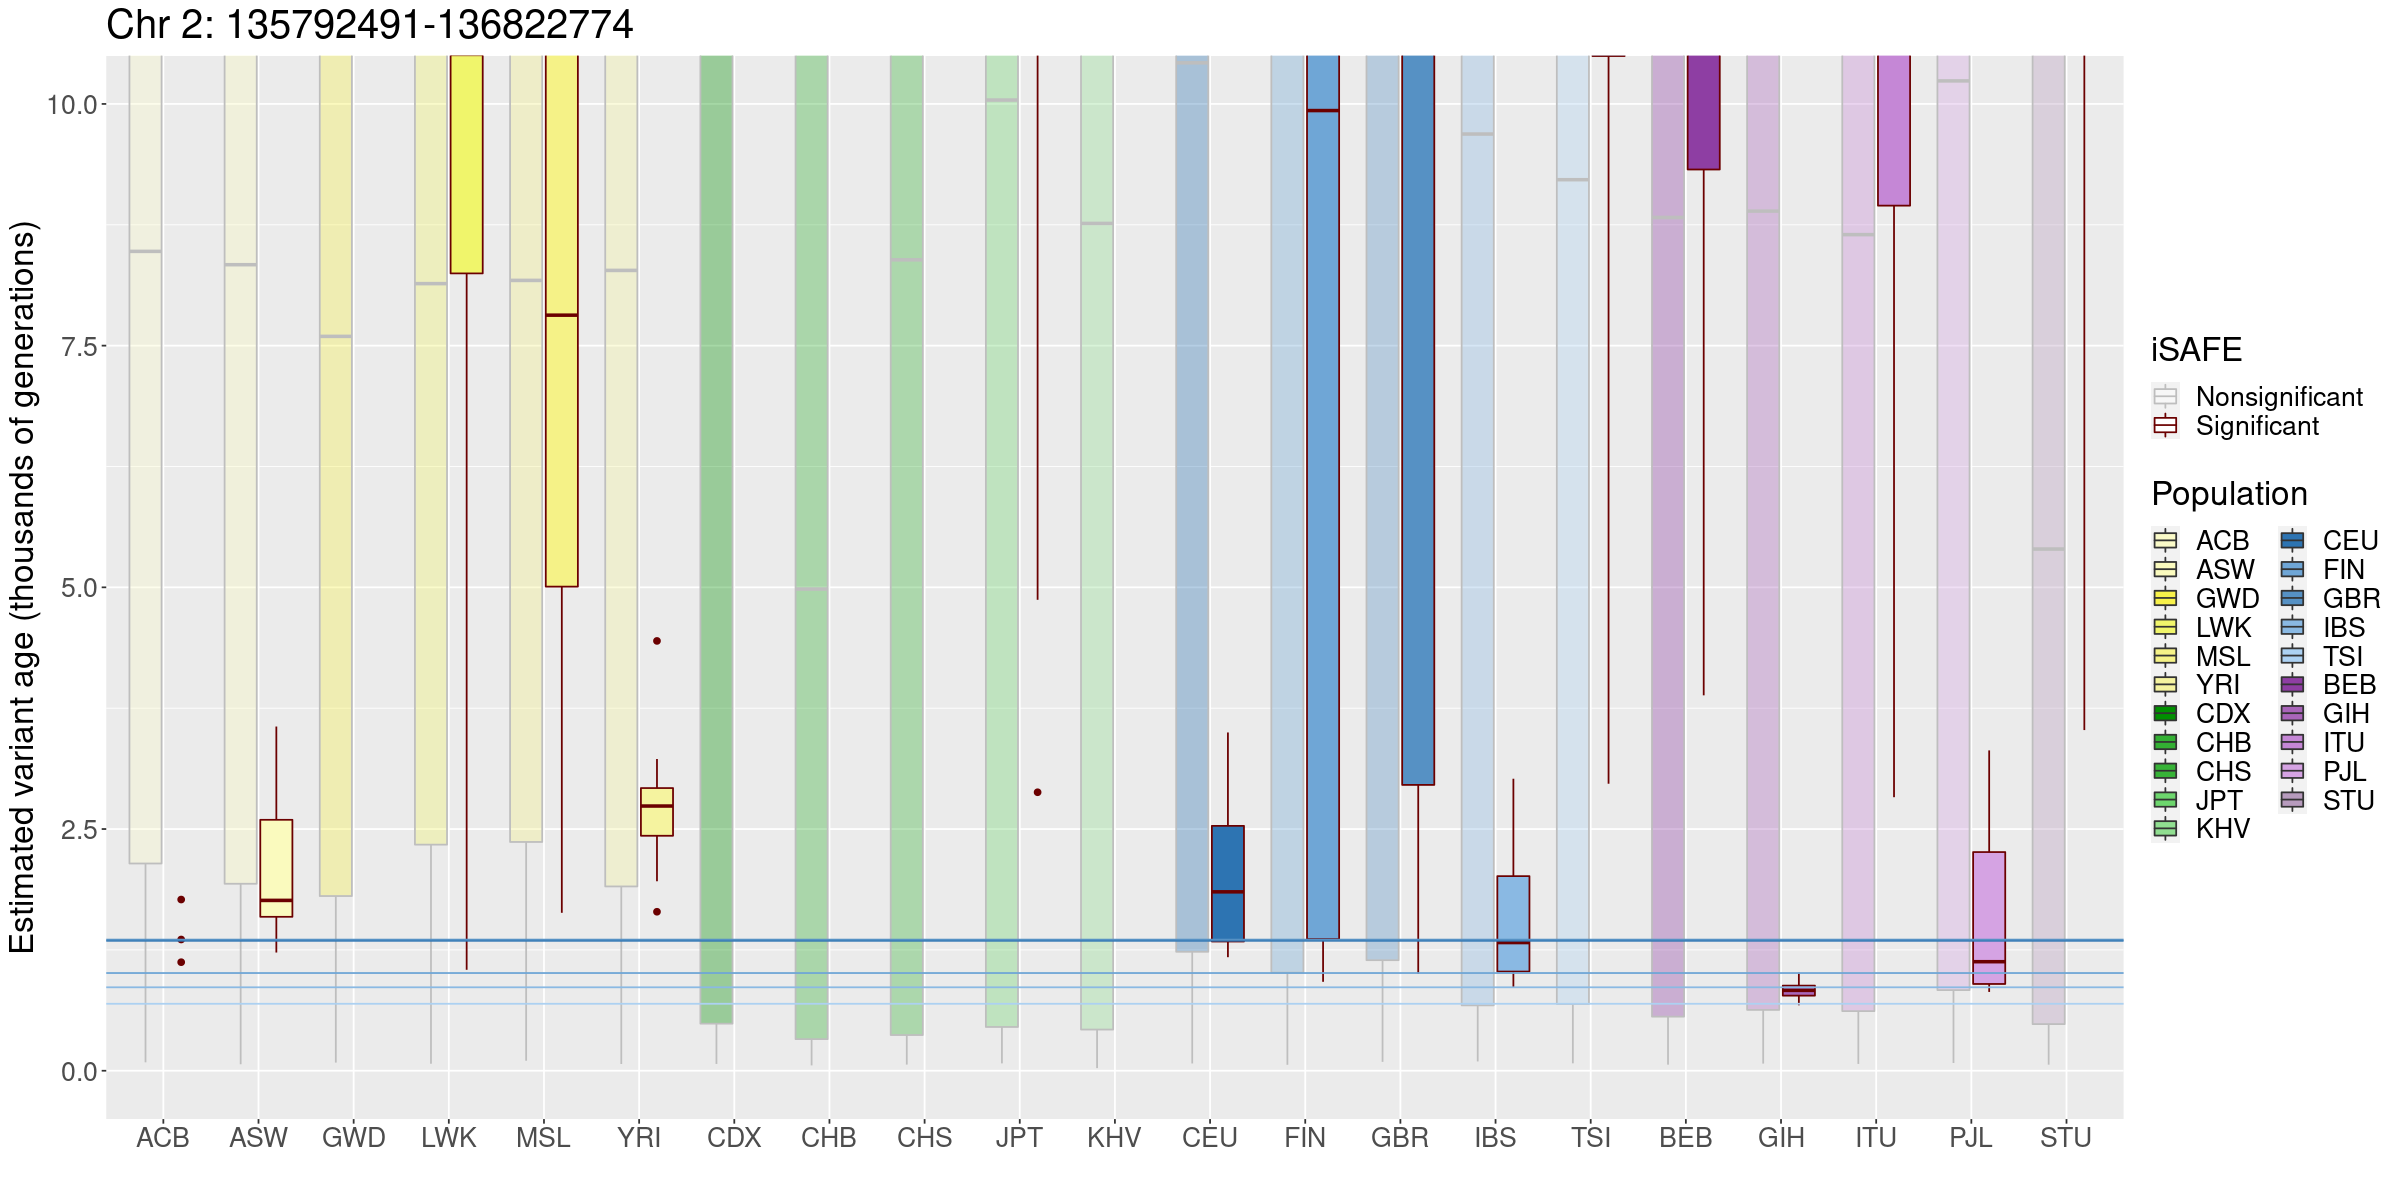

In [37]:
graficLCT + geom_hline(yintercept=relate_LCT$age/1000, color = popPal[relate_LCT$pop]) + coord_cartesian(ylim = c(0, 10))

In [38]:
graficLCT5 <- diferencia_edats5(2,135792491,136822774,AMR = FALSE)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


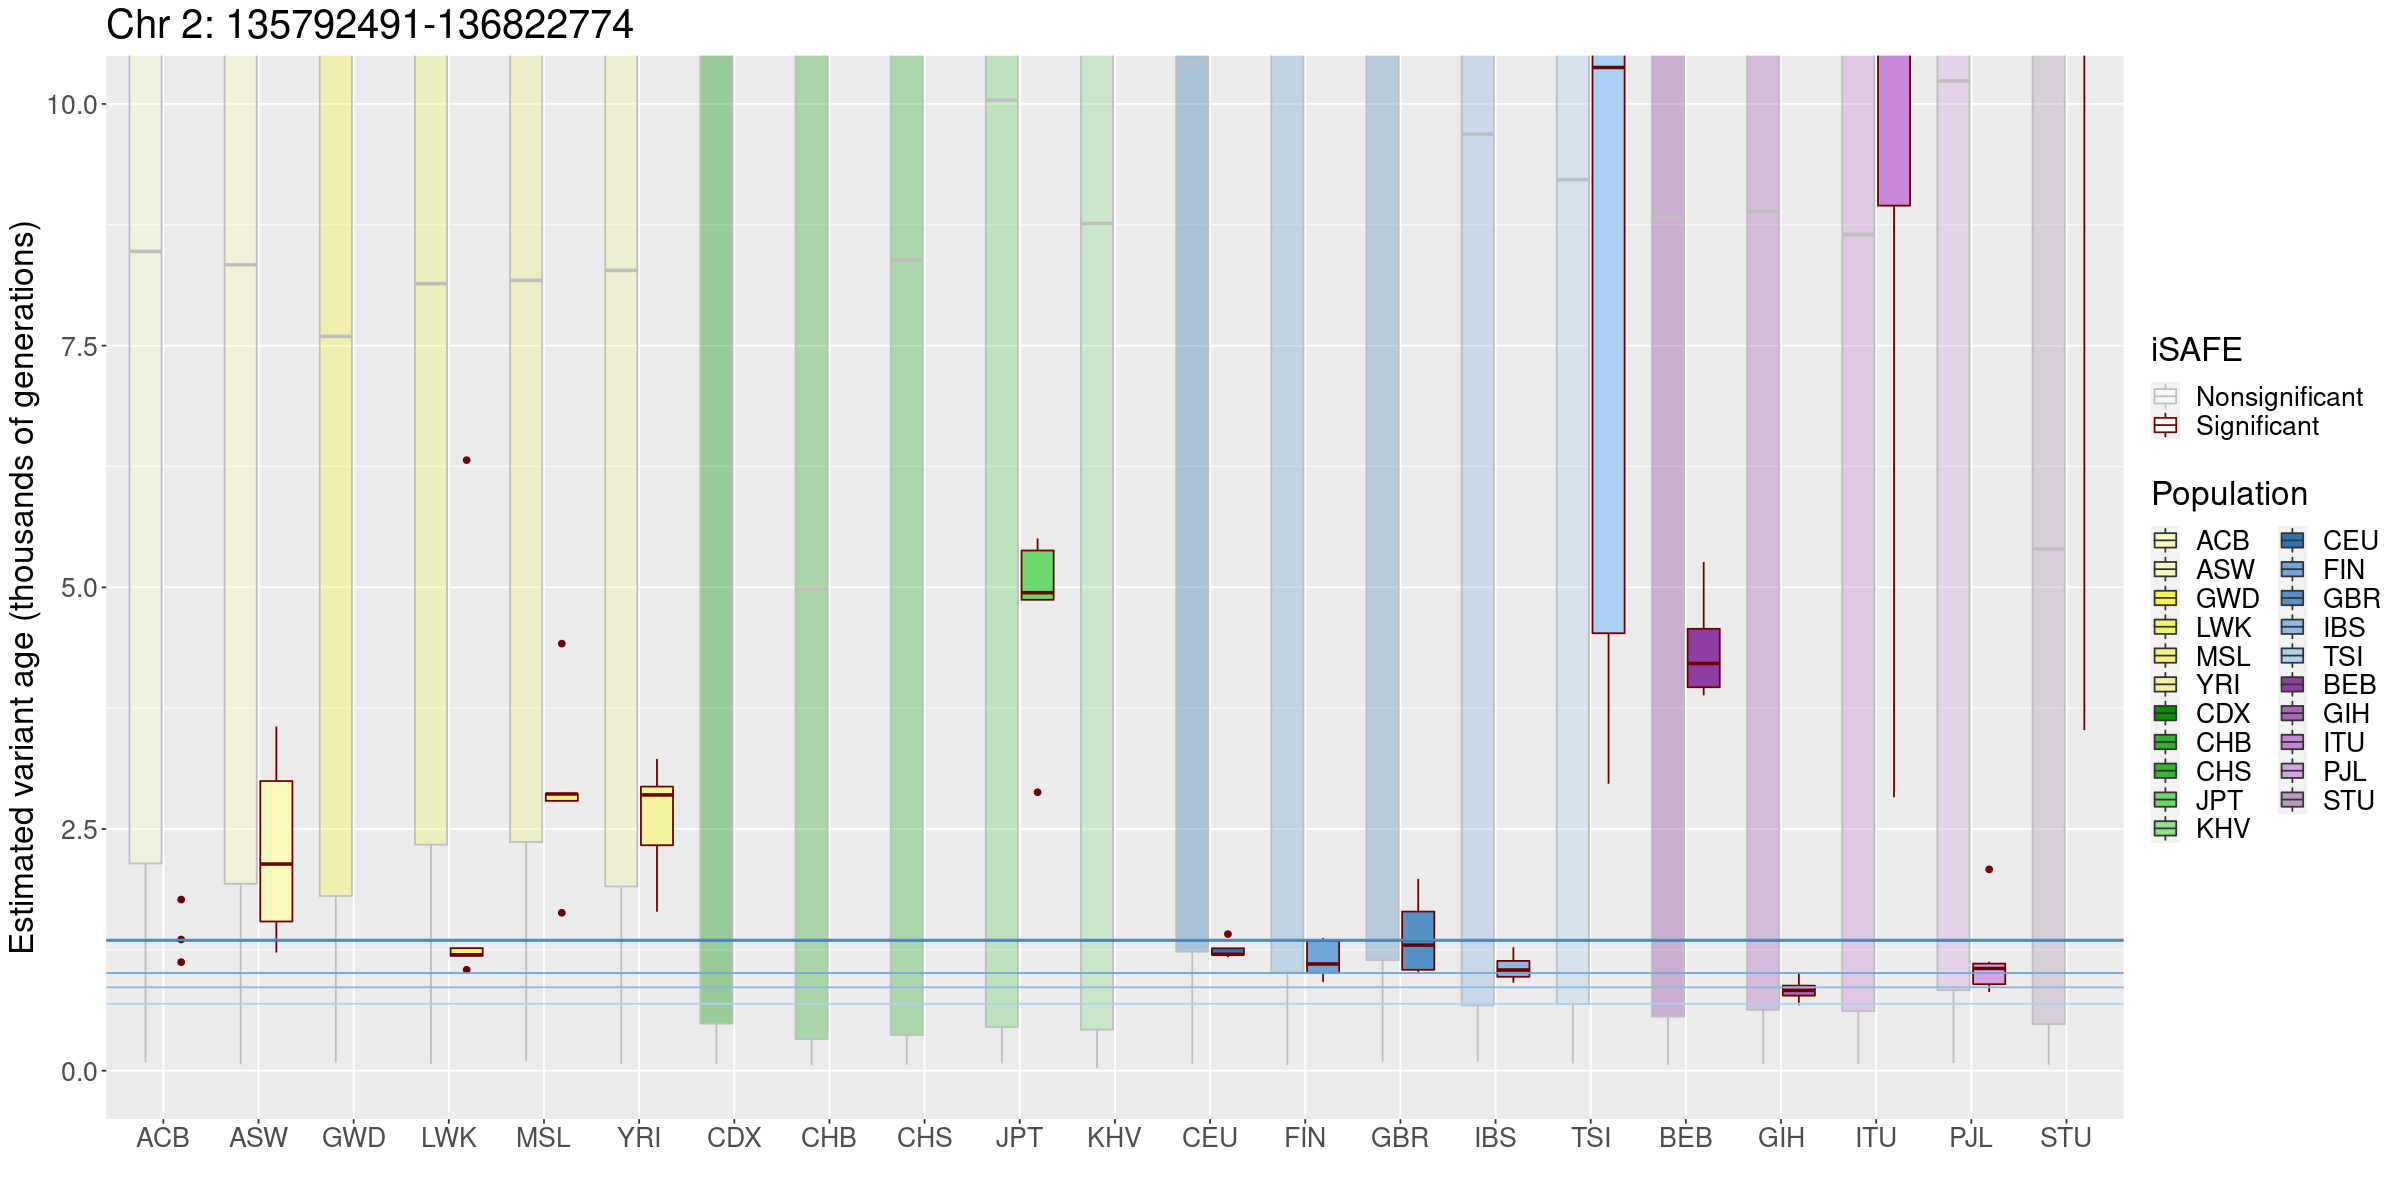

In [39]:
graficLCT5 + geom_hline(yintercept=relate_LCT$age/1000, color = popPal[relate_LCT$pop]) + coord_cartesian(ylim = c(0, 10))

In [33]:
isafe_LCT <- sqlToDf(2,135792491,136822774, 'isafe') %>% select(rsid, physicalPos, TSI, CEU, FIN, GBR, IBS) %>% filter(rsid == 'rs4988235' | rsid == 'rs182549')

In [34]:
isafe_LCT

rsid,physicalPos,TSI,CEU,FIN,GBR,IBS
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs4988235,136608646,0.07822,0.70406,0.55091,0.62351,0.45215
rs182549,136616754,0.07463,0.70406,0.55091,0.62351,0.45215


In [35]:
relate_LCT <- fread("/home/anoguera/Data/relate_ages/allele_ages_chr2.csv") %>% filter(BP == 136608646)

In [36]:
relate_LCT <- relate_LCT %>% filter(pop %in% EURpops) %>% mutate(age = (lower_age + upper_age) * 0.5)
relate_LCT

CHR,BP,ID,lower_age,upper_age,ancestral/derived,upstream,downstream,DAF,pvalue,pop,age
<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>
2,136608646,rs4988235:136608646:G:A,1154.830,1533.330,G/A,G,C,144,-6.31939,CEU,1344.0800
2,136608646,rs4988235:136608646:G:A,627.012,758.797,G/A,G,C,19,-1.23669,TSI,692.9045
2,136608646,rs4988235:136608646:G:A,877.473,1143.550,G/A,G,C,117,-7.84912,FIN,1010.5115
2,136608646,rs4988235:136608646:G:A,1111.740,1601.280,G/A,G,C,129,-6.57882,GBR,1356.5100
2,136608646,rs4988235:136608646:G:A,809.564,916.805,G/A,G,C,97,-6.51366,IBS,863.1845


## Comprovació EDAR

In [22]:
graficEDAR <- diferencia_edats(2, 109450405, 109606617,AMR = TRUE)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


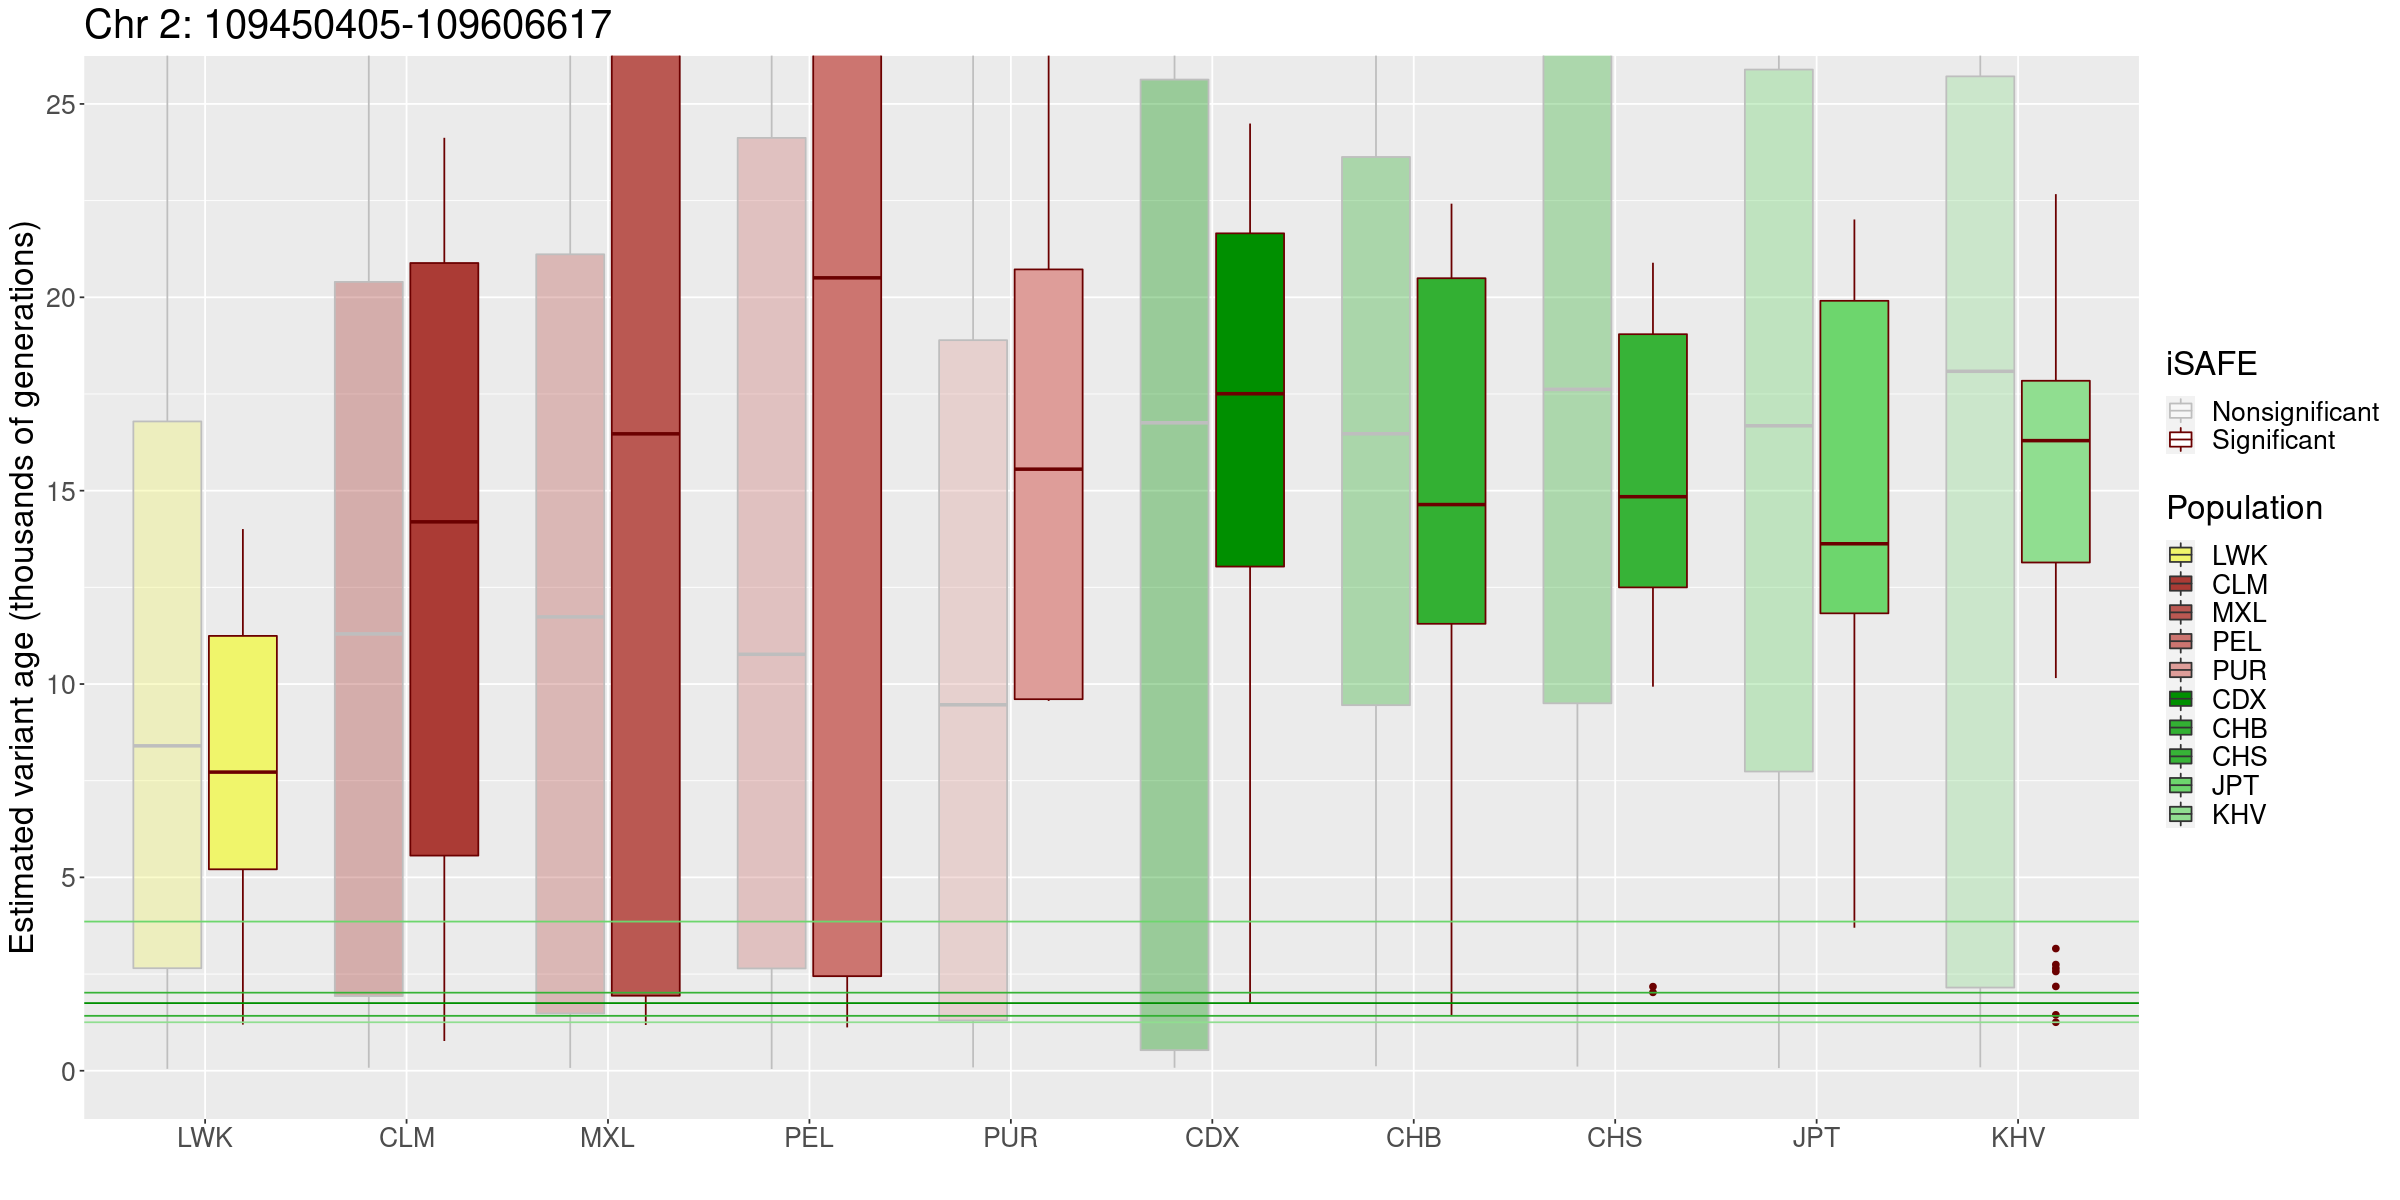

In [27]:
graficEDAR + geom_hline(yintercept=relate_EDAR$age/1000, color = popPal[relate_EDAR$pop]) + coord_cartesian(ylim = c(0, 25))

In [28]:
graficEDAR5 <- diferencia_edats5(2, 109450405, 109606617,AMR = TRUE)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


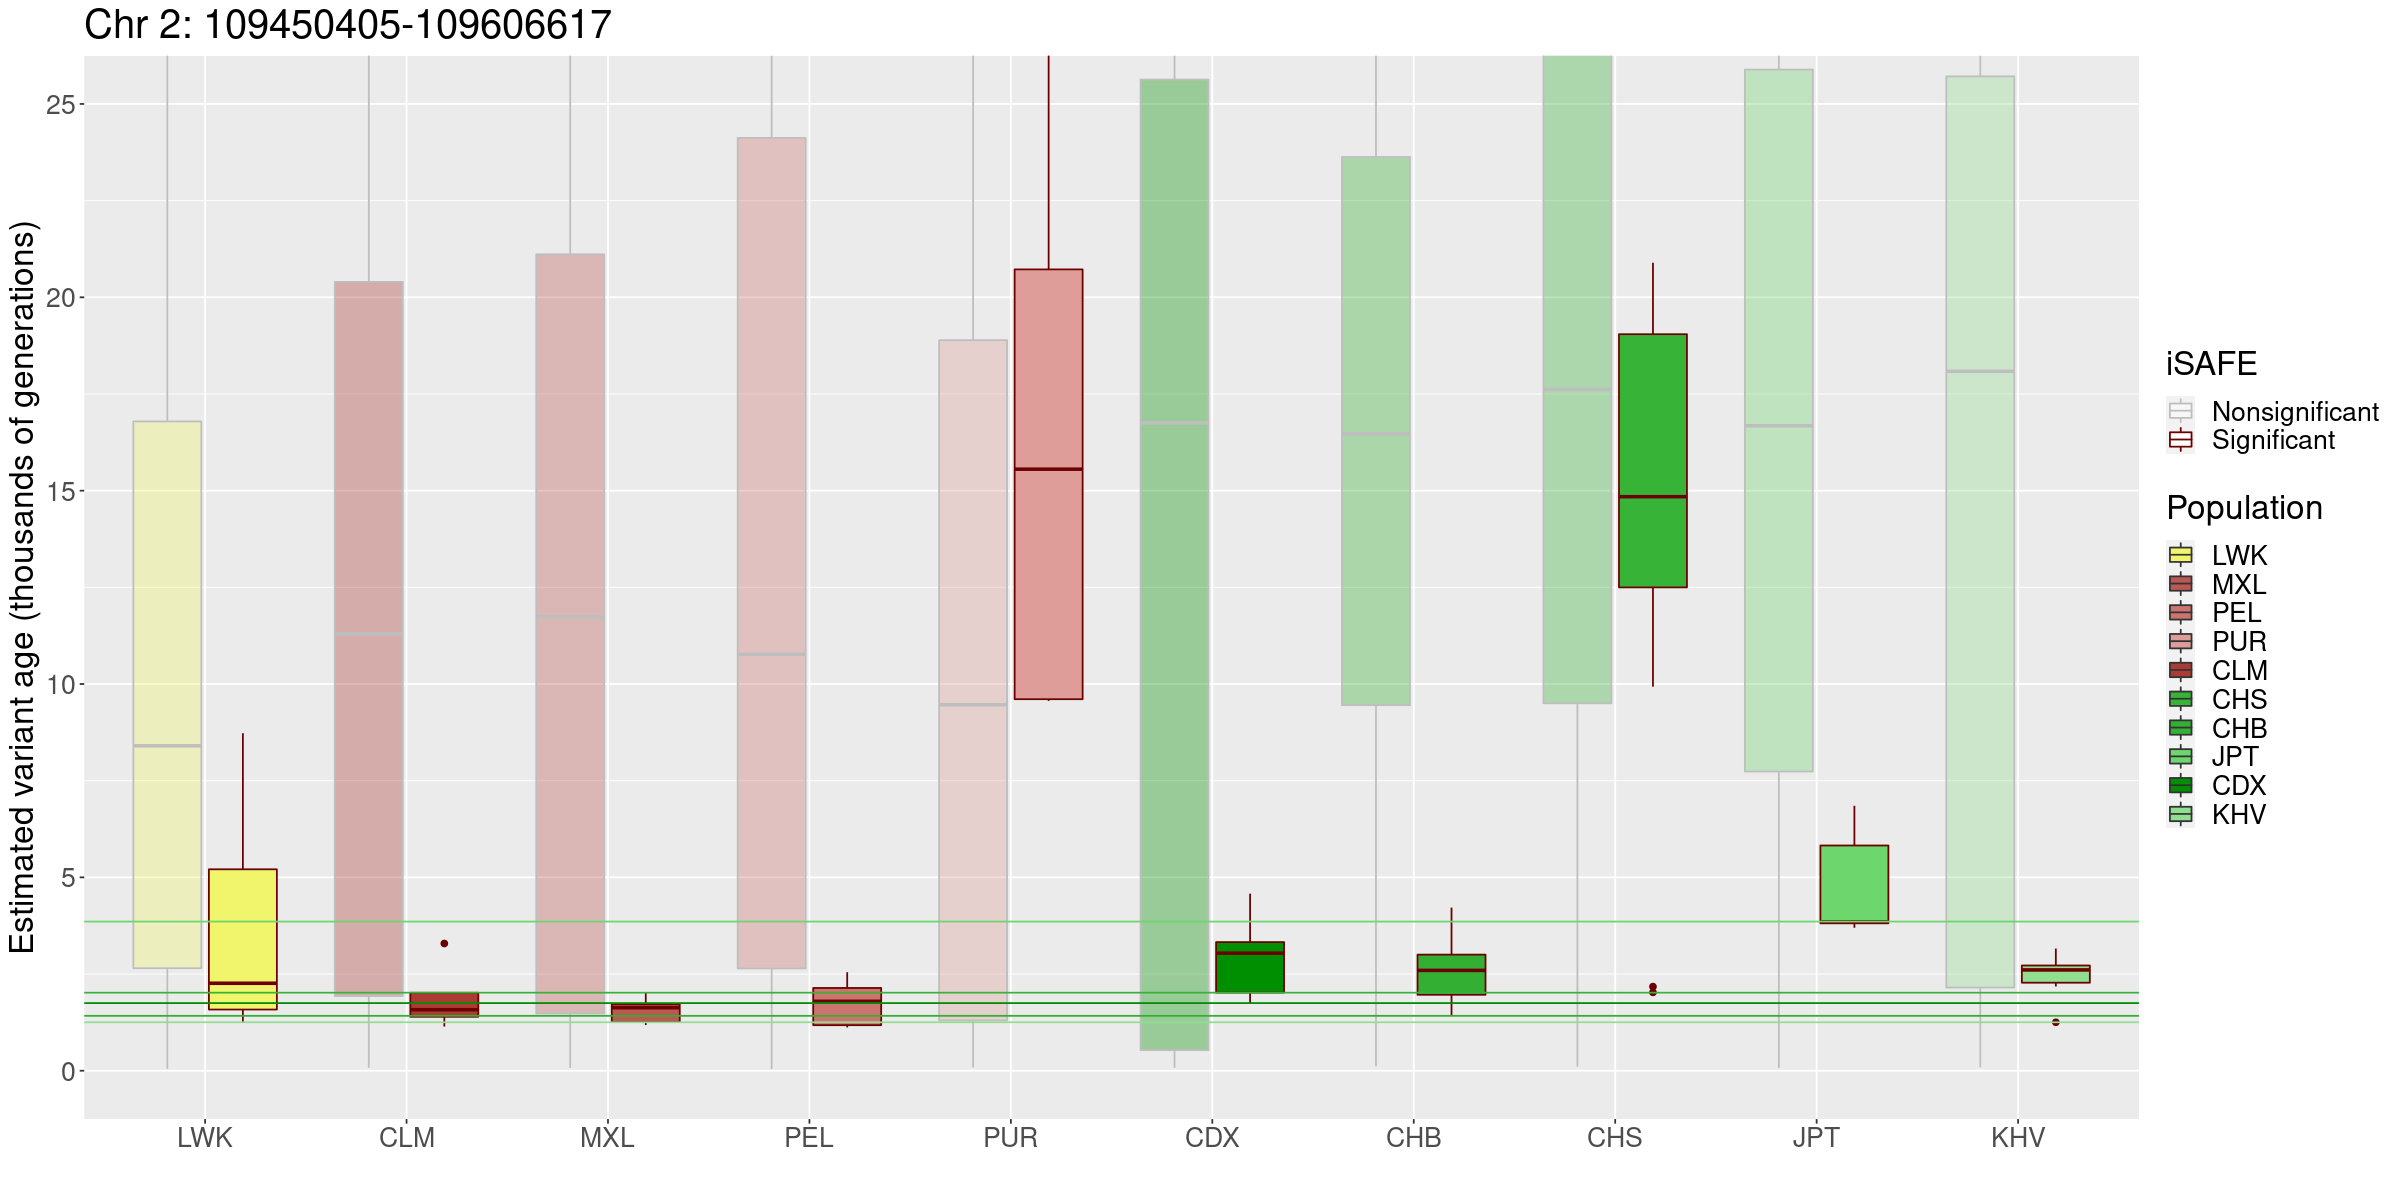

In [29]:
graficEDAR5 + geom_hline(yintercept=relate_EDAR$age/1000,  color = popPal[relate_EDAR$pop]) + coord_cartesian(ylim = c(0, 25))

In [23]:
isafe_EDAR <- sqlToDf(2,109450405, 109606617, 'isafe') %>% select(rsid, physicalPos, CDX, CHB, CHS, JPT, KHV) %>% filter(rsid == 'rs3827760' | rsid == 'rs146567337')

In [24]:
isafe_EDAR

rsid,physicalPos,CDX,CHB,CHS,JPT,KHV
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs146567337,109513572,0.00000,0.00000,0.00000,0.00000,0.00000
rs3827760,109513601,0.48446,0.53607,0.35323,0.32578,0.43013


In [25]:
relate_EDAR <- fread("/home/anoguera/Data/relate_ages/allele_ages_chr2.csv") %>% filter(BP == 109513601)

In [26]:
relate_EDAR <- relate_EDAR %>% filter(pop %in% EASpops) %>% mutate(age = (lower_age + upper_age) * 0.5)
relate_EDAR

CHR,BP,ID,lower_age,upper_age,ancestral/derived,upstream,downstream,DAF,pvalue,pop,age
<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>
2,109513601,rs3827760:109513601:A:G,1196.51,1642.22,A/G,A,C,191,-6.42814,CHB,1419.365
2,109513601,rs3827760:109513601:A:G,2081.32,5633.50,A/G,A,C,165,-2.13698,JPT,3857.410
2,109513601,rs3827760:109513601:A:G,1489.27,2547.98,A/G,A,C,188,-4.83820,CHS,2018.625
2,109513601,rs3827760:109513601:A:G,1344.03,2154.55,A/G,A,C,165,-6.32074,CDX,1749.290
2,109513601,rs3827760:109513601:A:G,1087.56,1419.65,A/G,A,C,161,-5.93757,KHV,1253.605


## Comprovació SLC24A5 

In [13]:
graficSLC24A5 <- diferencia_edats(15,48371224,48510654,AMR = FALSE) #SLC12A1,CTXN2,MYEF2,SLC24A5  (en teoria és en europeus i sud-asiàtics però només hi ha dades per sud-asiàtics)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


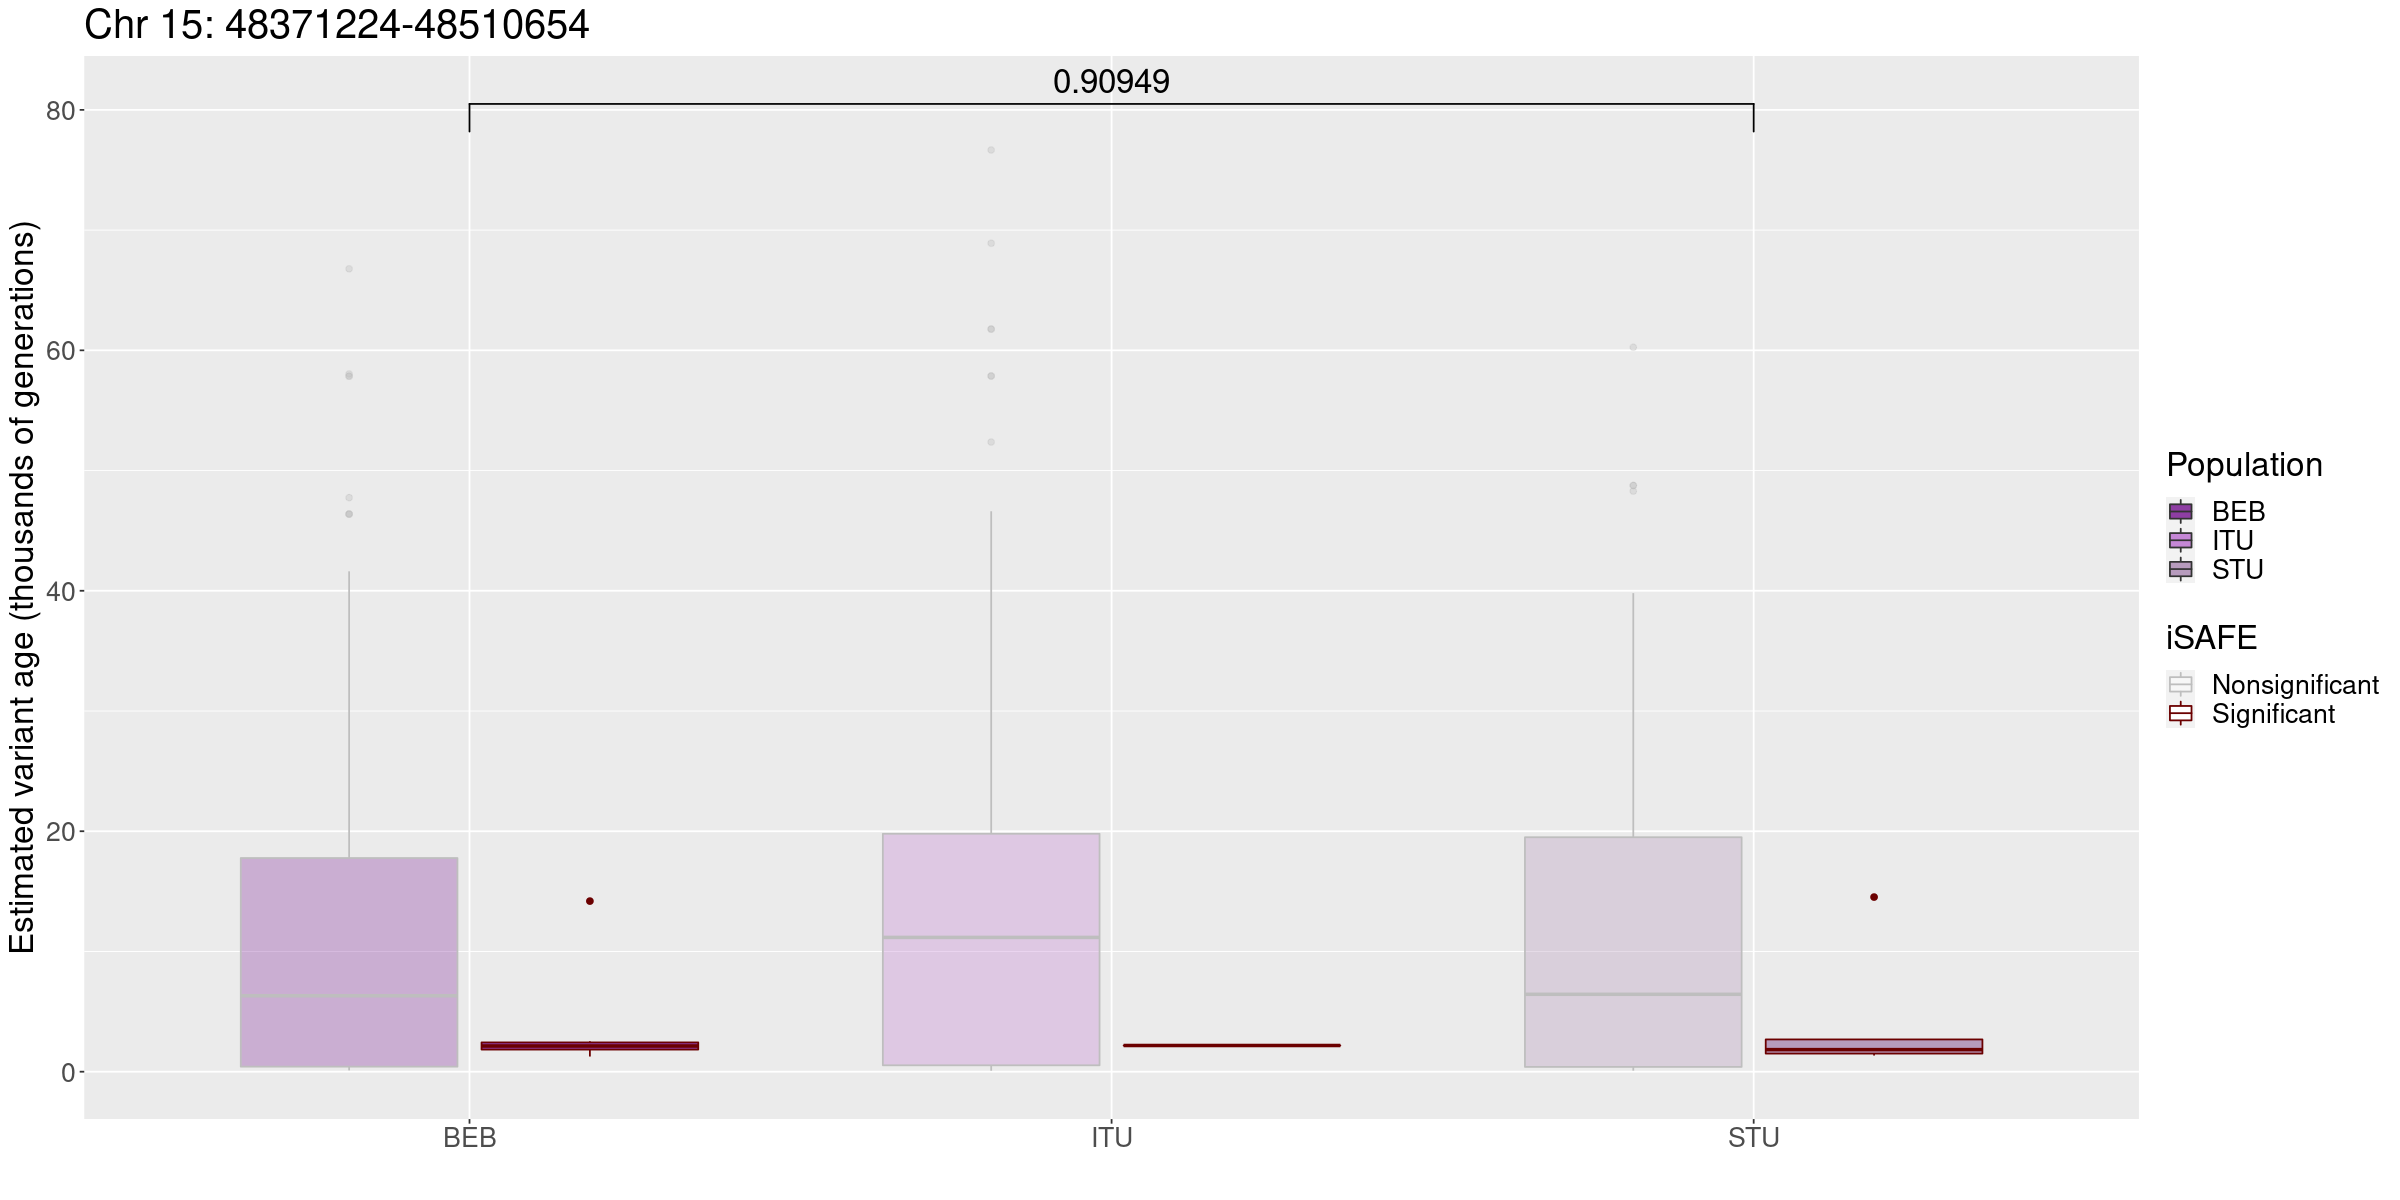

In [14]:
graficSLC24A5

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


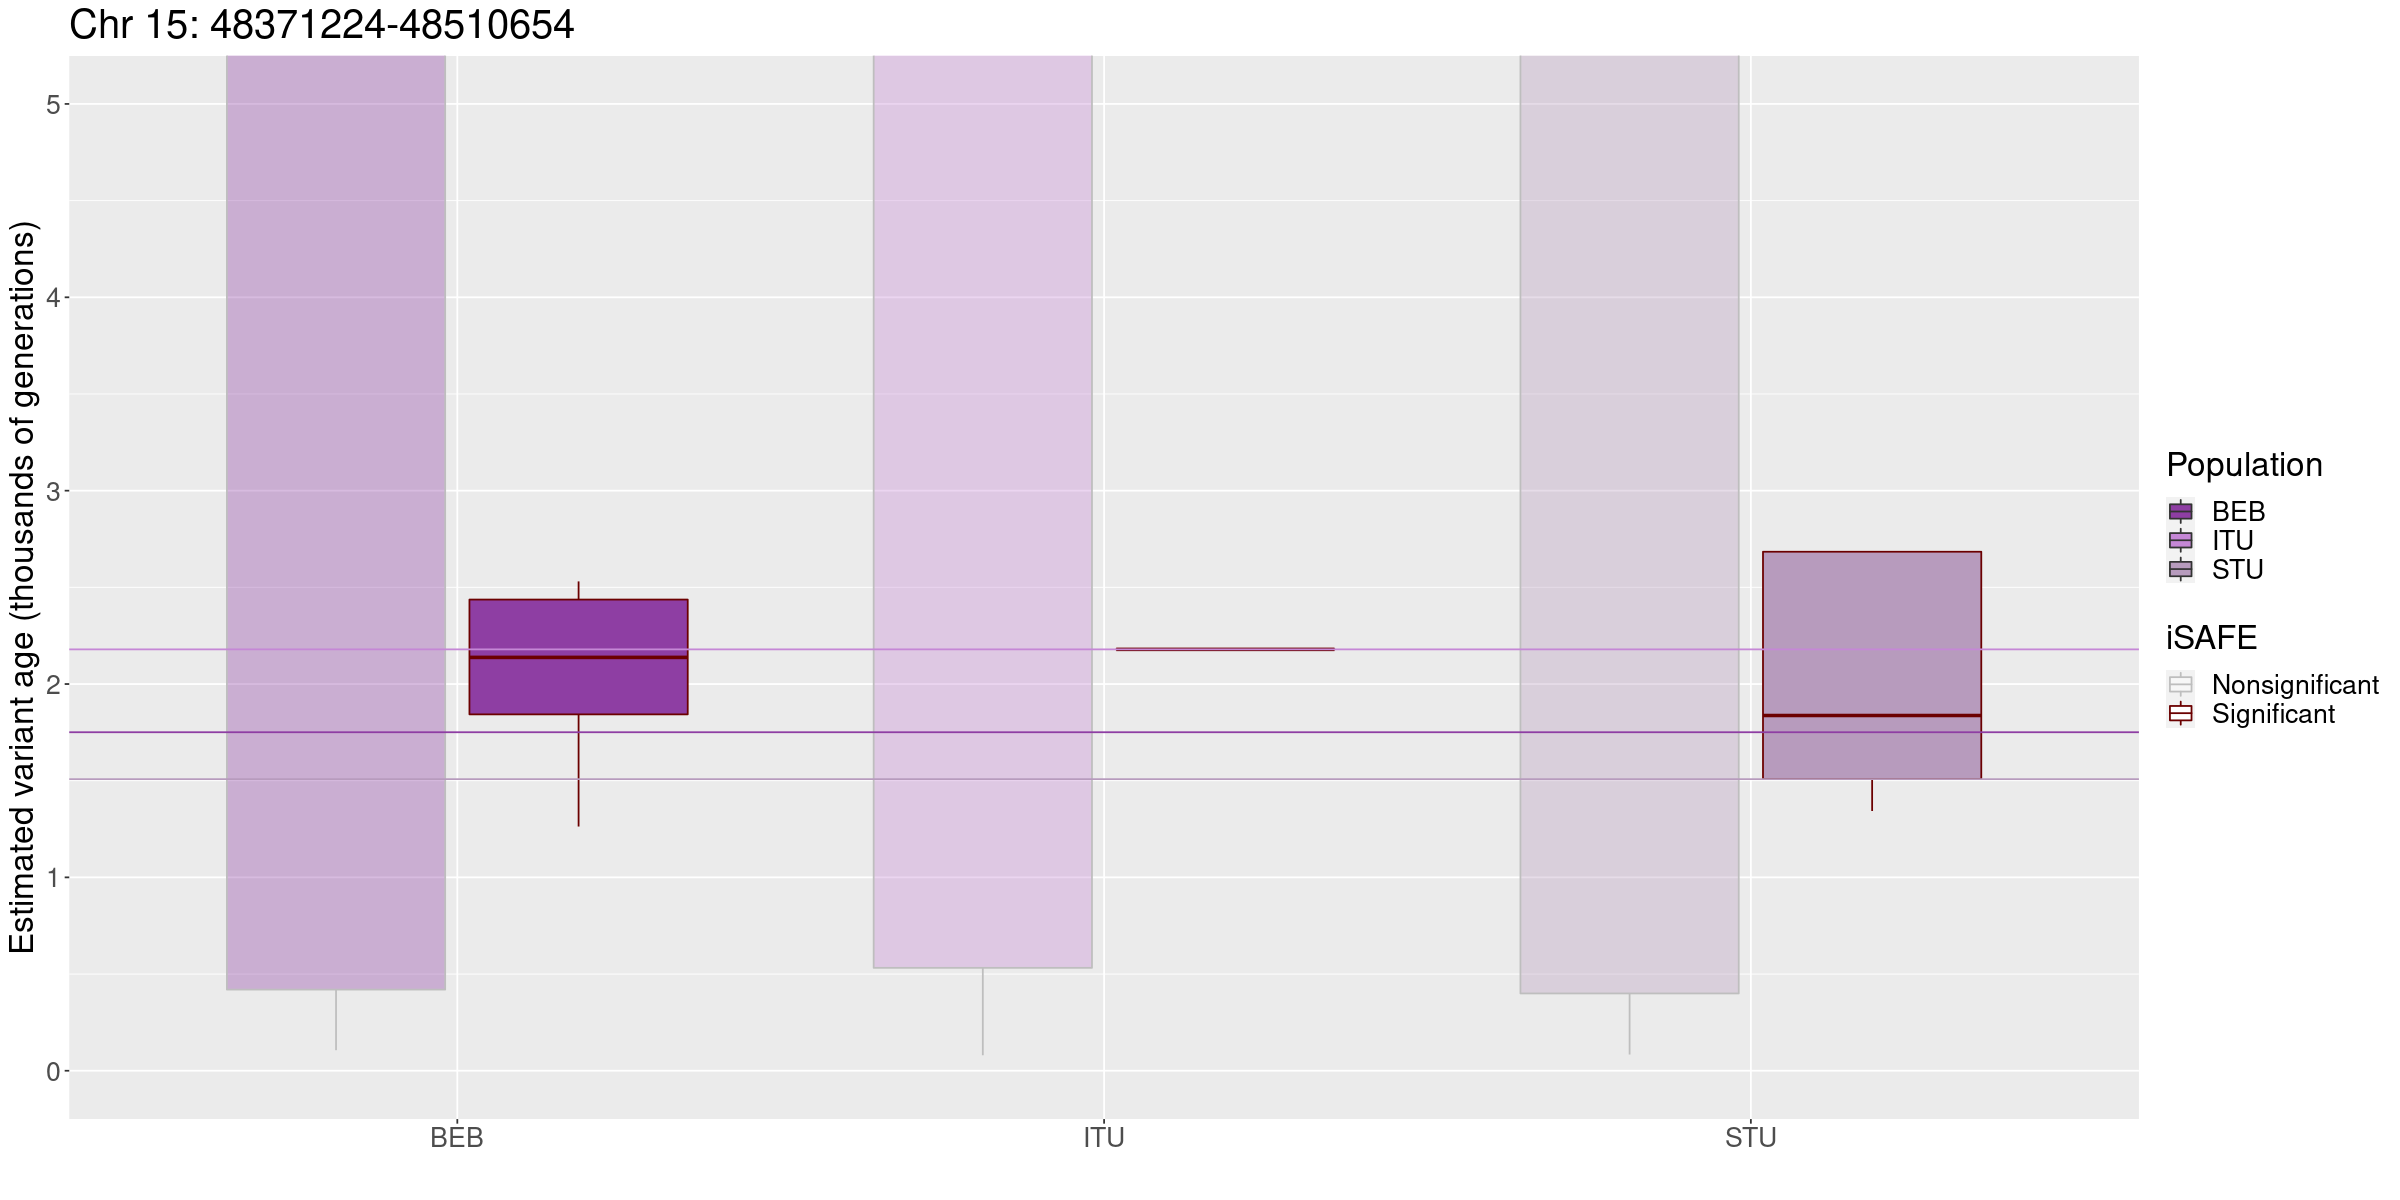

In [20]:
graficSLC24A5 + geom_hline(yintercept=relateSLC24A5$age/1000, color = popPal[relateSLC24A5$pop]) + coord_cartesian(ylim = c(0, 5))

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


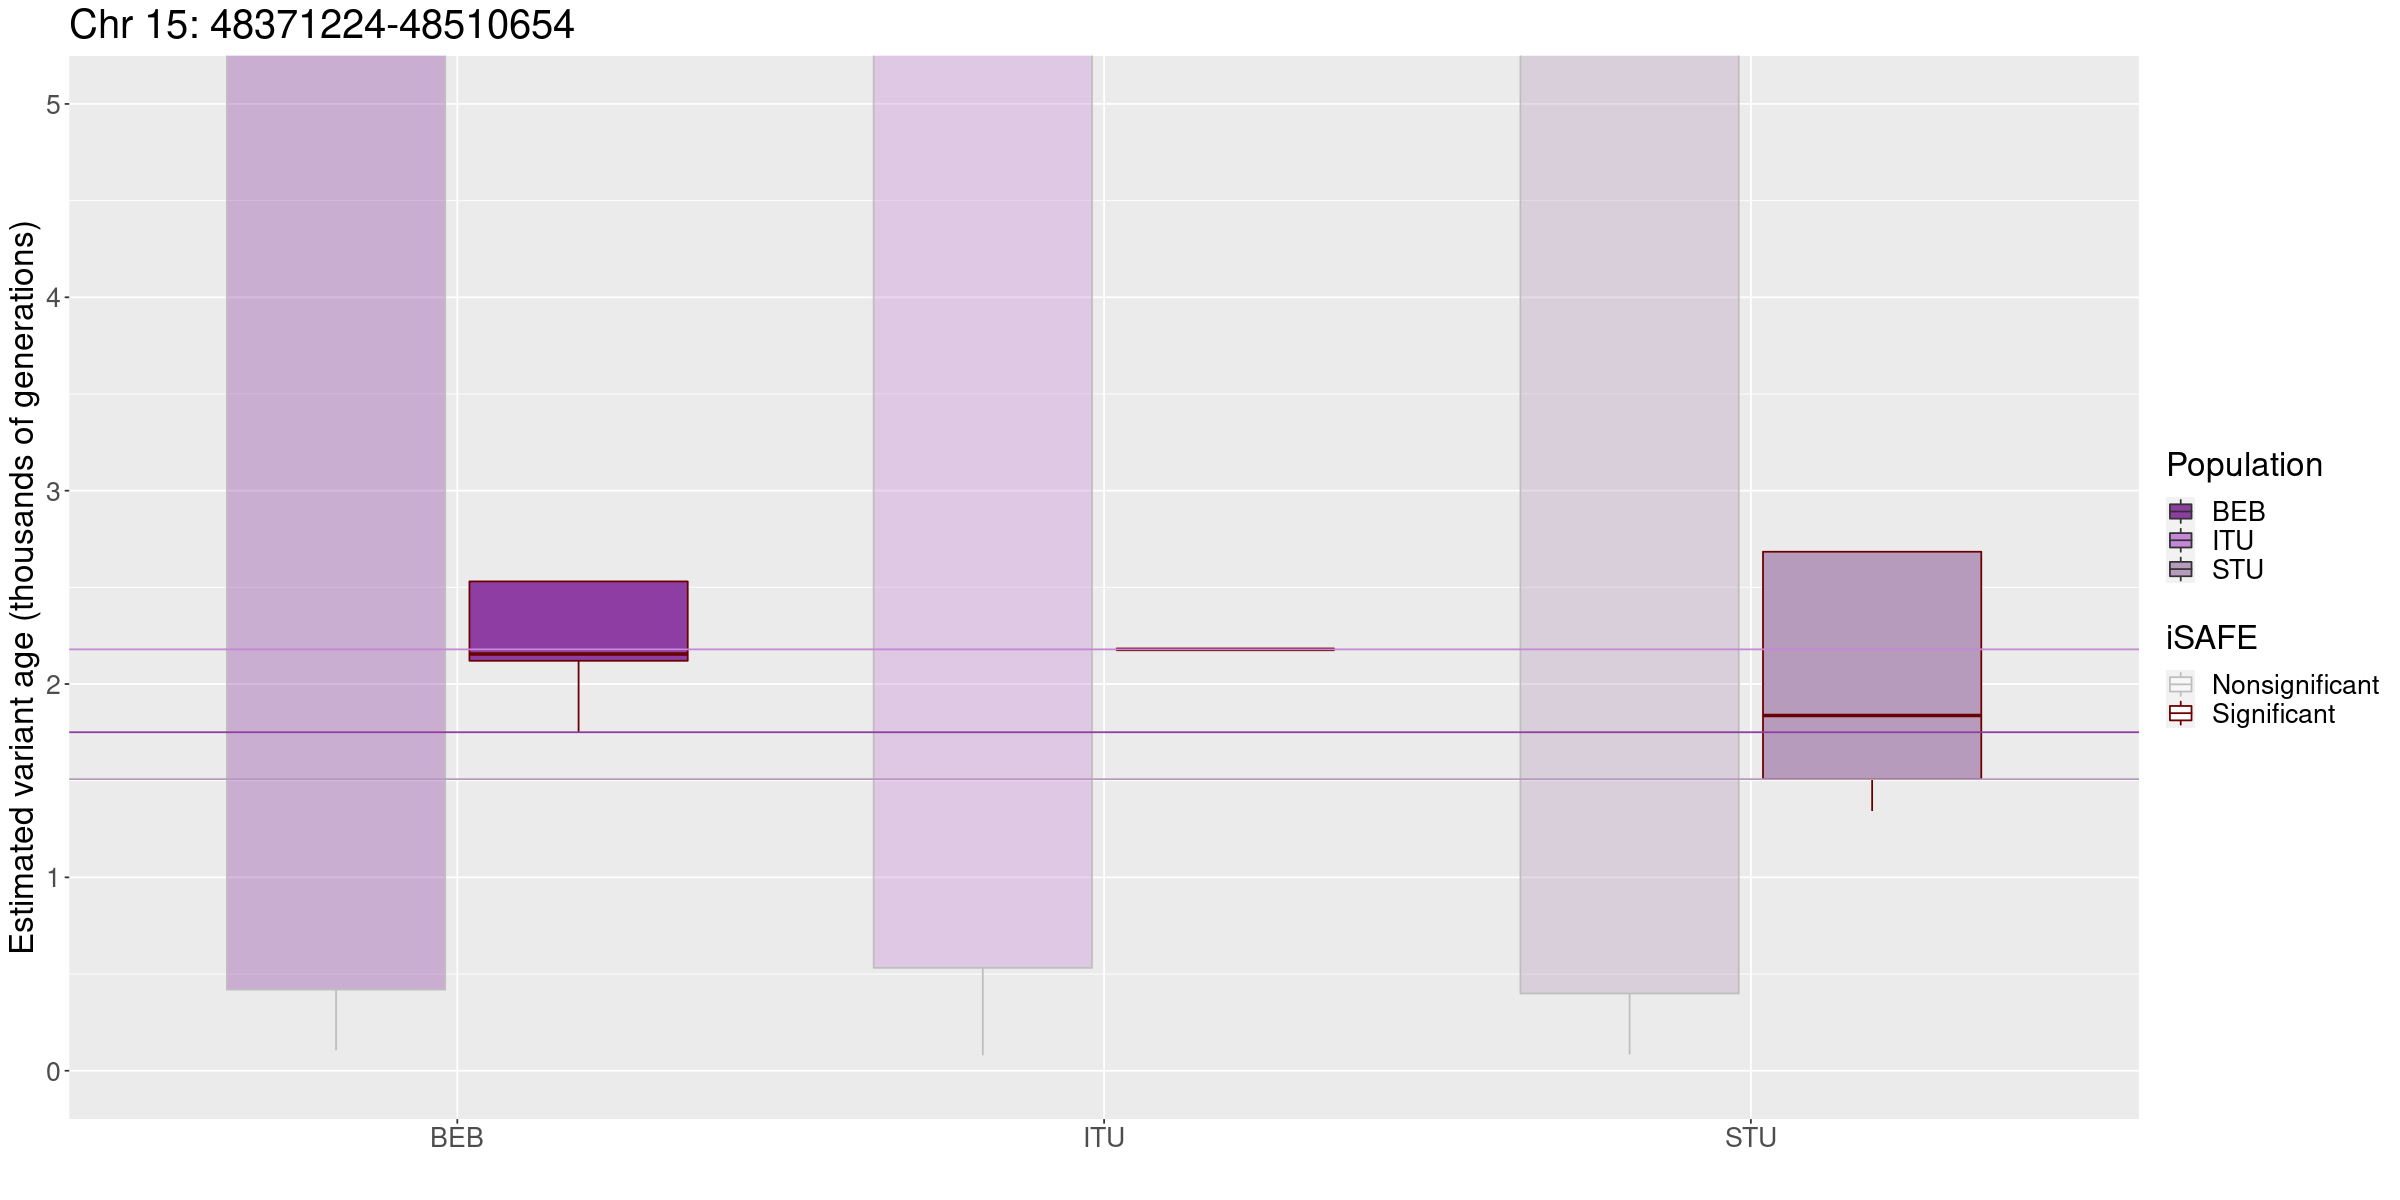

In [21]:
diferencia_edats5(15,48371224,48510654,AMR = FALSE) + geom_hline(yintercept=relateSLC24A5$age/1000, color = popPal[relateSLC24A5$pop]) + coord_cartesian(ylim = c(0, 5))

In [16]:
isafeSLC24A5 <- sqlToDf(15,48371224,48510654, 'isafe') %>% select(physicalPos, rsid, BEB, ITU, STU) %>% filter(rsid == 'rs1426654')

In [17]:
isafeSLC24A5

physicalPos,rsid,BEB,ITU,STU
<int>,<chr>,<dbl>,<dbl>,<dbl>
48426484,rs1426654,0.13059,0.10019,0.11362


In [18]:
relateSLC24A5 <- fread("/home/anoguera/Data/relate_ages/allele_ages_chr15.csv") %>% filter(BP == 48426484)

In [19]:
relateSLC24A5 <- relateSLC24A5 %>% filter(pop %in% c('BEB','ITU','STU')) %>% mutate(age = (lower_age + upper_age) * 0.5)
relateSLC24A5

CHR,BP,ID,lower_age,upper_age,ancestral/derived,upstream,downstream,DAF,pvalue,pop,age
<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>
15,48426484,rs1426654:48426484:A:G,1461.87,2039.67,G/A,C,C,91,-2.67387,BEB,1750.770
15,48426484,rs1426654:48426484:A:G,1311.83,1704.44,G/A,C,C,99,-2.21317,STU,1508.135
15,48426484,rs1426654:48426484:A:G,1721.35,2637.00,G/A,C,C,132,-2.58048,ITU,2179.175


## Comprovació col·lagen (3 regions)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


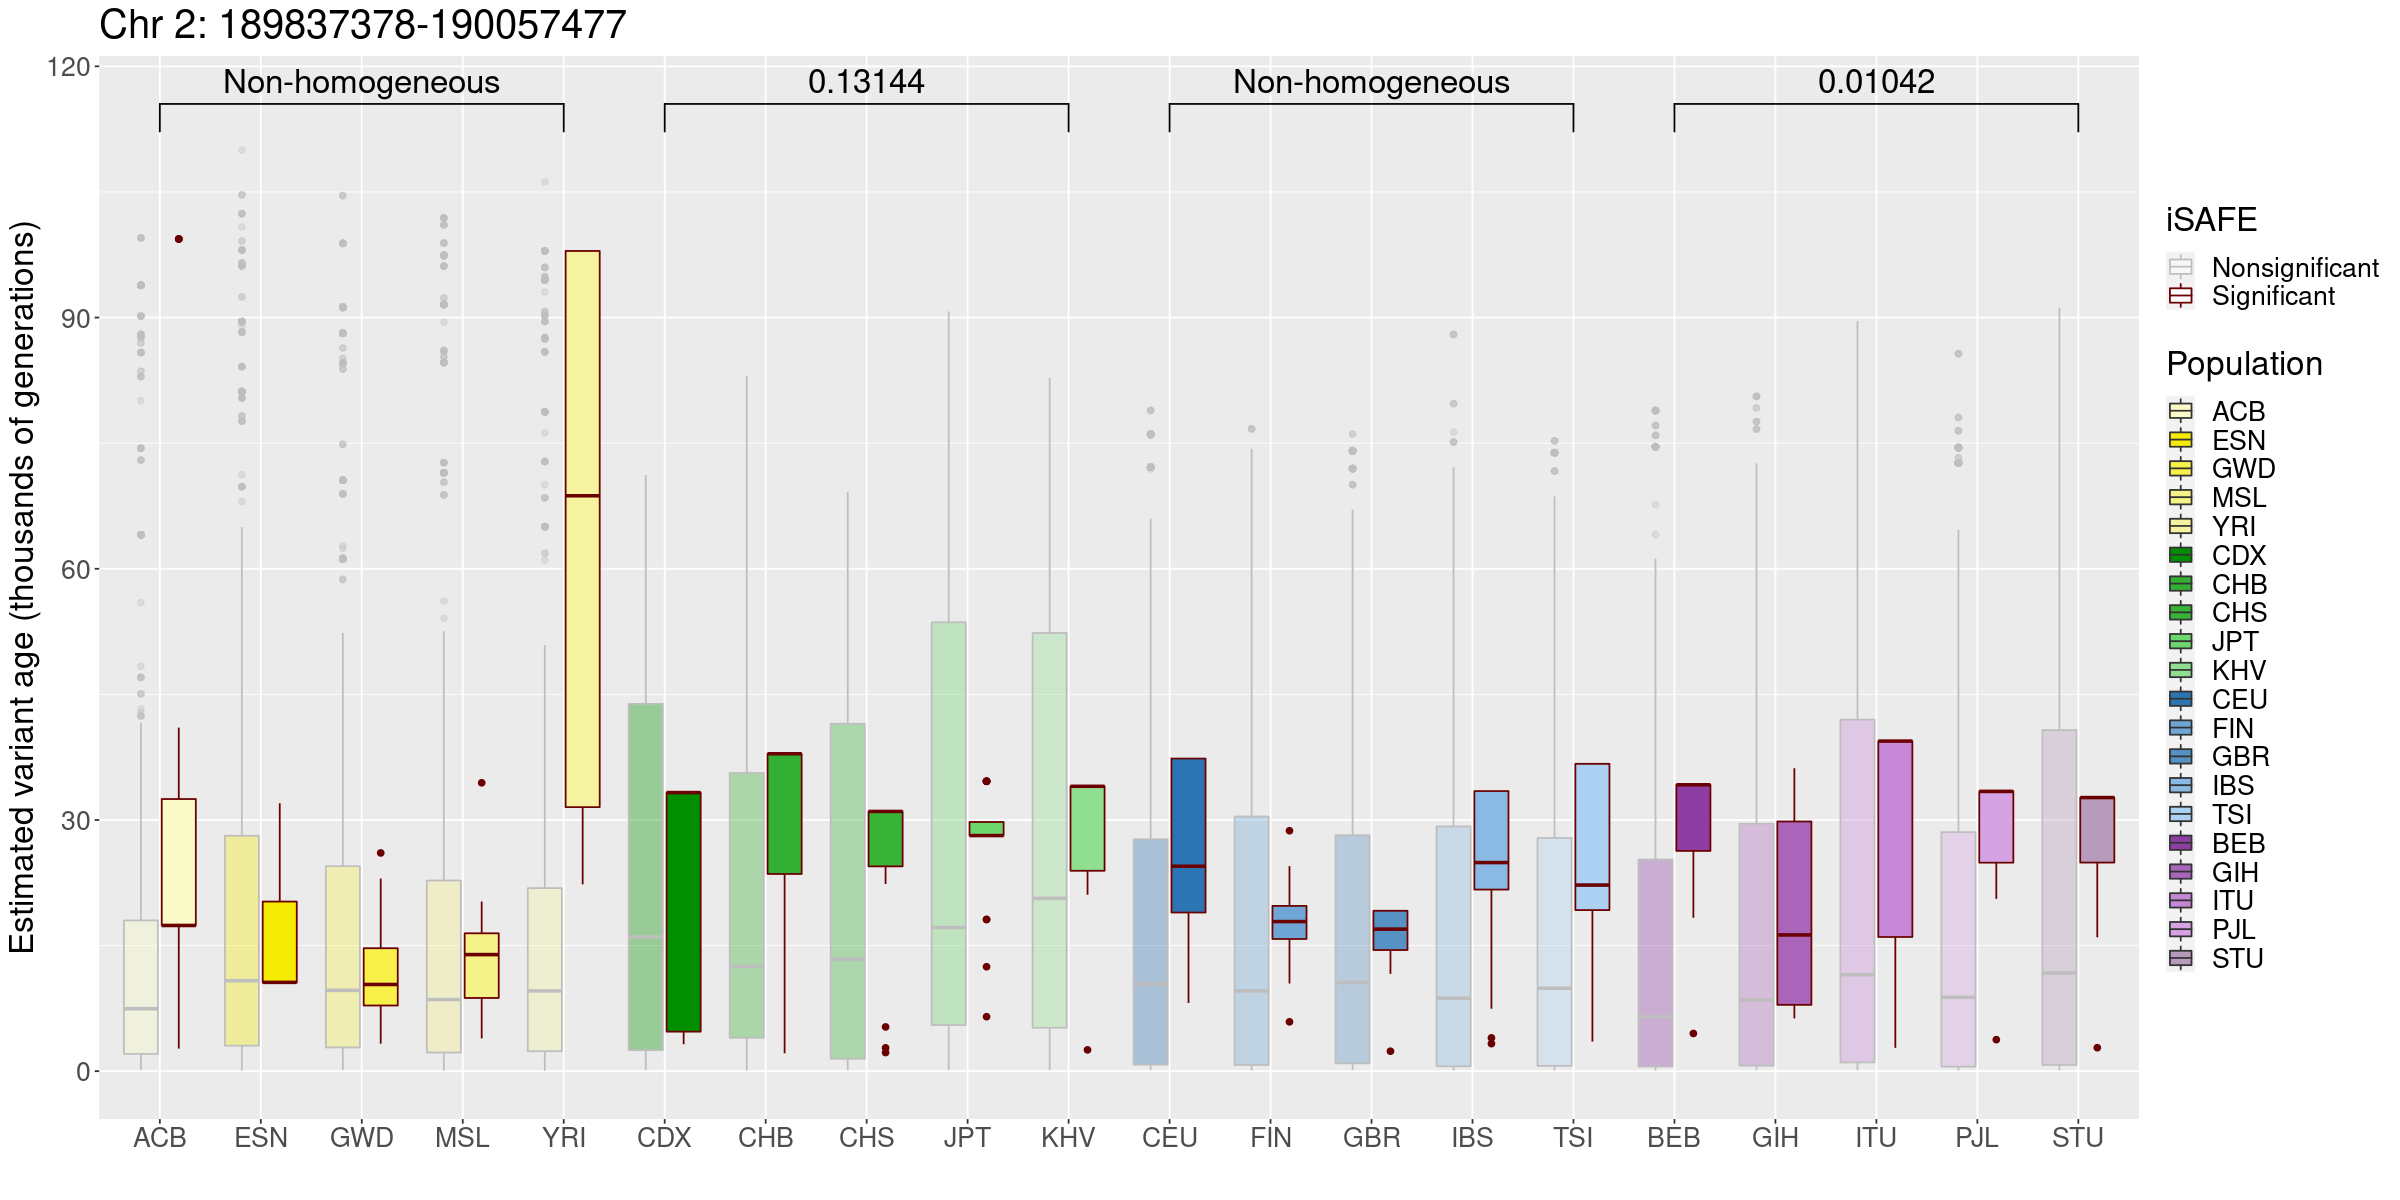

In [10]:
diferencia_edats(2,189837378,190057477,AMR = FALSE)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


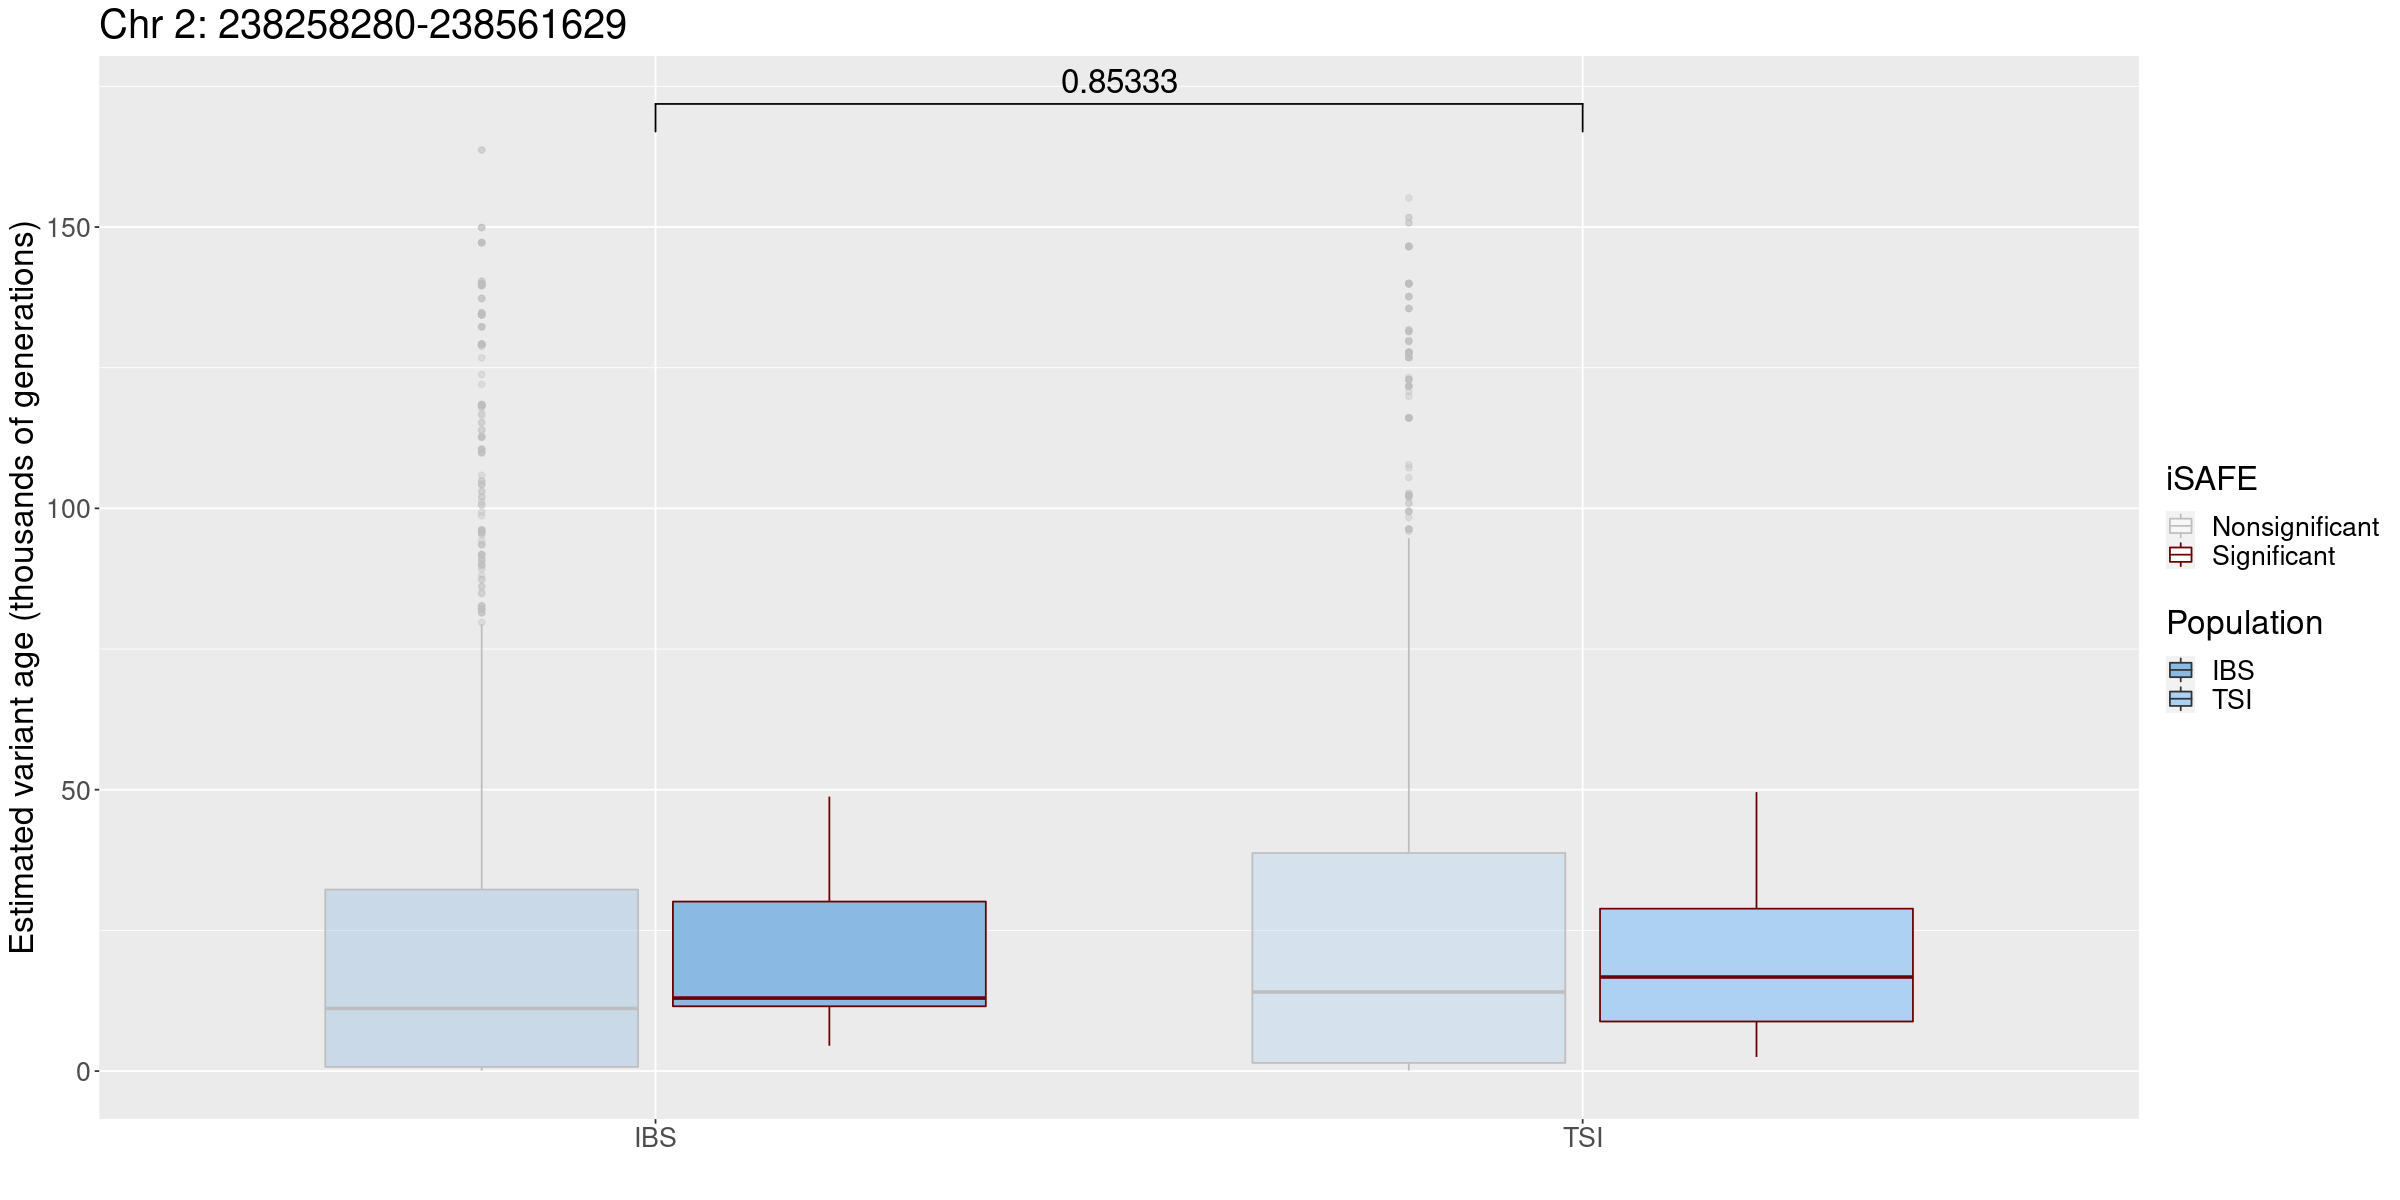

In [11]:
diferencia_edats5(2,238258280,238561629,AMR = FALSE)

Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”
Warning message in data.frame(x = c(min(comp[1], comp[2]), min(comp[1], comp[2]), :
“row names were found from a short variable and have been discarded”


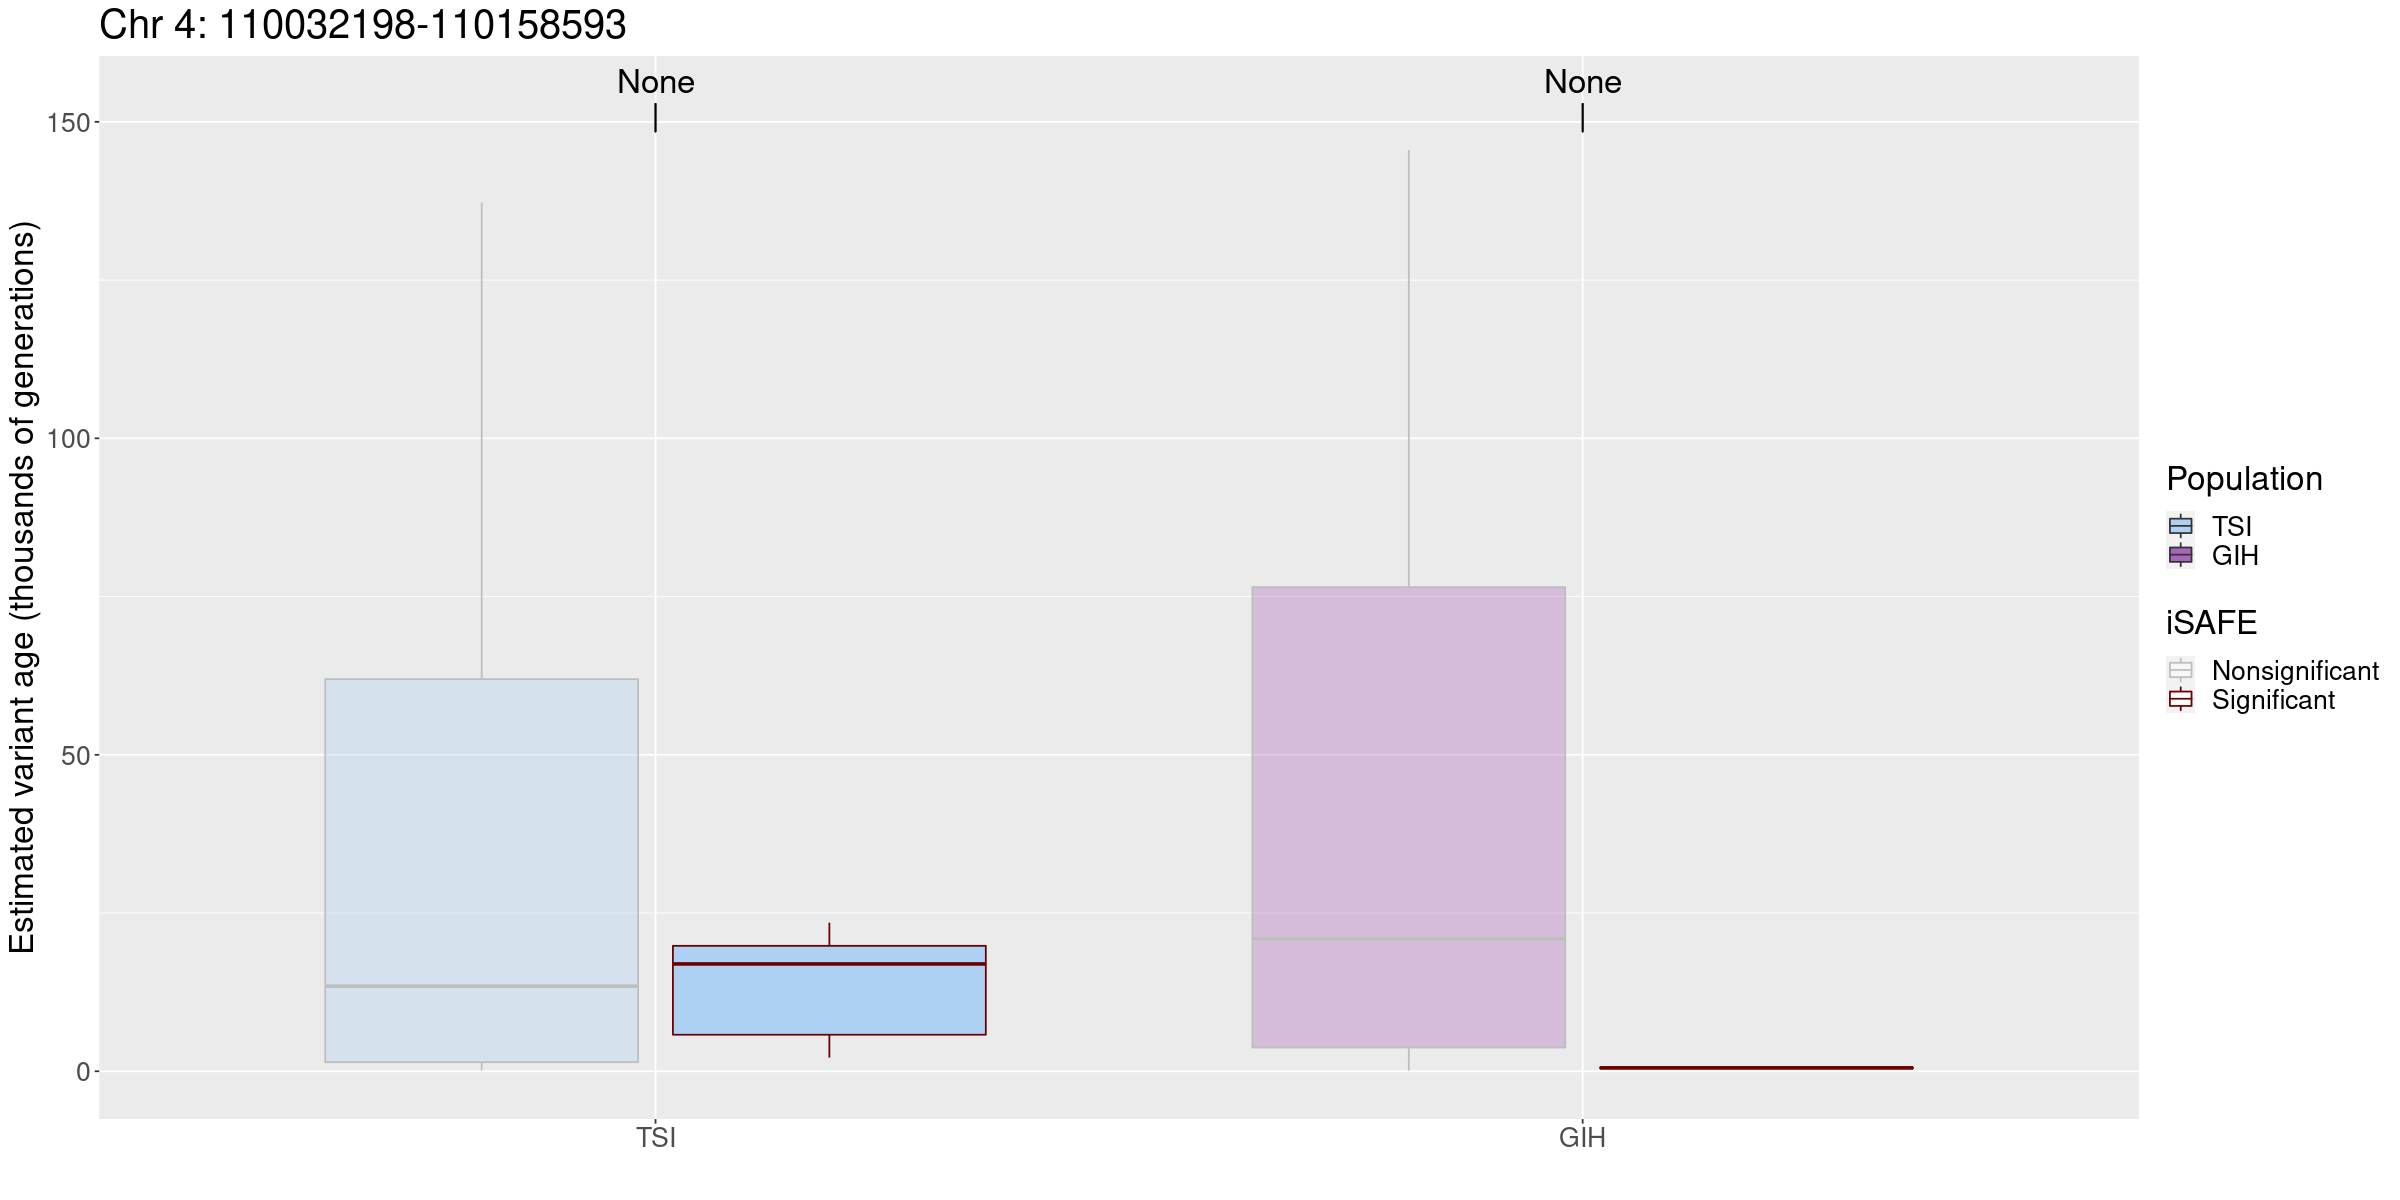

In [12]:
diferencia_edats5(4,110032198,110158593,AMR = FALSE)

## Codi per 5 variants superiors

In [9]:
###Gràfic per plotejar una regió concreta on es mira si l'edat estimada de les variants amb iSAFE significatiu és coherent entre les poblacions d'una mteapoblació AMB KRUSKAL-WILLIS i RELATE

diferencia_edats5 <- function(chr, inici, final, pop_color = popPal, 
                             AFR = AFRpops, EAS = EASpops, EUR = EURpops, SAS = SASpops, AMR = TRUE) {
    library(ggsignif)
    #Obtinc la regió necessària de la taula isafe
    isafe <- sqlToDf(chr, inici, final, 'isafe')
    #Si AMR == FALSE vol dir que s'ha d'eliminar la informació de les poblacions americanes
    if (AMR == FALSE) {
        isafe <- isafe[, -c("CLM", "MXL", "PEL", "PUR")]
    }    
    #Faig el pivot longer a isafe per tenir un registre per cada població i variant, filtro els NA i classifico per si la variant és significant o no. 
    isafe <- isafe %>%
        pivot_longer(cols = c('ACB':'YRI'), names_to = 'pop', values_to='isafe') %>%
        filter(!is.na(isafe)) %>% mutate(grup = case_when(isafe >= 0.1 ~ 'Significant', TRUE ~ 'Nonsignificant'))
    #Això serveix per conseguir un vector amb les poblacions que tenen alguna variant significatica en iSAFE per aquesta regió
    pop_significatiu <- unique(isafe %>% filter(grup == 'Significant') %>% pull(pop))
    #Si no hi ha cap població significativa, s'acaba ja i no es pot representar res
    if (length(pop_significatiu) == 0) {
        return('This region cannot be represented, as no populations have variants with a significant iSAFE value')
    }
    #Filtro la taula per quedar-me només amb la informació de poblacions amb variants significatives i afegeixo a quina metapoblació pertanyen i la columna rsid_pop
    isafe <- isafe %>% filter(pop %in% pop_significatiu) %>% mutate(metapop = case_when(pop %in% AFR ~ 'AFR',
                                                                                        pop %in% EUR ~ 'EUR',
                                                                                        pop %in% EAS ~ 'EAS',
                                                                                        pop %in% SAS ~ 'SAS',
                                                                                        TRUE ~ 'AMR'),
                                                                    rsid_pop = paste(rsid, pop, sep=':'))
    #Obro la taula de les edats del cromosoma en qüestió i filtro per la regió i perquè la població sigui a pop_significatiu
    allele_ages <- fread(paste0("/home/anoguera/Data/relate_ages/allele_ages_chr", chr, '.csv')) %>% filter(BP >= inici & BP <= final) %>% select(BP, pop, lower_age, upper_age, pvalue)
    #Ara ajunto les dues taules en el merged
    merged <- merge(isafe, allele_ages, by.x = c('physicalPos', 'pop'), by.y = c('BP', 'pop'))
    #Una vegada fet el merge, em quedo amb les 15 variants més significatives per iSAFE (no ho faig abans perquè potser perdríem les variants significatives per no estar a la taula d'edats)
    #Creo una taula on hi hagi les files corresponents als 15 valors significatius d'iSAFE més alts en cada població. SI n'hi ha menys de 15, es guarden els que hi hagi. Si hi ha empats, se'n queda > 15
    isafe15 <- merged %>% select(grup, pop, isafe, rsid_pop) %>% filter(grup == 'Significant') %>% group_by(pop) %>% slice_max(isafe, n=5)
    #Ara de la taula principal, elimino les files que siguin significants  no estiguin a isafe15 
    merged <- merged %>% filter(grup == 'Nonsignificant' | rsid_pop %in% isafe15$rsid_pop)
    #En cas que no hi hagi cap variant significativa en tota la població després de tot, diem que no es pot representar la població
    pop_significatiu <- unique(merged %>% filter(grup == 'Significant') %>% pull(pop))
    if (length(pop_significatiu) == 0) {
        return('This region cannot be represented, as no populations have an estimated allele age for variants with a significant iSAFE value')
    }
    #Em quedo només amb les poblacions que tinguin variants significatives al final i calculo l'edat estimada de la variant, que és la mitjana de les edats superior i inferior (per mutacions neutres??)
    merged <- merged %>% filter(pop %in% pop_significatiu) %>% mutate(age = 0.5*(lower_age + upper_age))
    #Faig una taula on posar (després) el resultat del test Kruskal-Wallis per metapoblació i la primera i última població de la metapop per representar-ho
    kruskal <- merged %>% filter(grup == 'Significant') %>% group_by(metapop) %>% arrange(pop) %>%
        summarise(primer = unique(pop)[1], ultim = unique(pop)[n_distinct(pop)], .groups = 'keep')
    #Aqui guardaré els p_valors de l'anàlisi kruskal-wallis de cada població que es pugui. No puc filtrar els iSAFE < 0.1 de la taula principal perquè els necessito pel gràfic
    p_vals <- c('AFR' = NA, 'EUR' = NA, 'EAS' = NA, 'SAS' = NA, 'AMR' = NA)
    for (i in 1:5) {
        merged_temp_temp <- merged  %>% filter(grup == 'Significant' & metapop == names(p_vals)[i])
        #Si no hi ha valors per aquesta metapoblació, es queda el NA
        if (nrow(merged_temp_temp) == 0) {
            next
        }
        #Si no es pot fer cap anàlisi, es posa un None
        if (n_distinct(merged_temp_temp$pop) == 1 | n_distinct(merged_temp_temp$rsid) == 1) {
            p_vals[i] <- 'None'
            next
        }
        #Per poder fer el test de Kruskal-Wallis, fa falta fer un test d'homogeneitat i que no hi hagin diferències significatives entre les variàncies de les diferents poblacions
        #Faig un test de Levene amb la mediana perquè és no paramètric i no passa res perquè no segueixi una distribució normal i accedeixo al seu p-valor
        p_valor_levene <- levene.test(y = merged_temp_temp$age, group = merged_temp_temp$pop, location = "median")[["p.value"]]
        if (is.na(p_valor_levene)) {
            p_vals[i] <- 'None'
            next
        } else if (p_valor_levene < 0.05) {
            p_vals[i] <- 'Non-homogeneous'
            next
        }
        #Si es fa l'anàlisi, es guarda el p_valor al vector
        p_vals[i] <- round(kruskal.test(age ~ pop, data = merged_temp_temp)[['p.value']], digits = 5)
    }
    #Afegeixo els p_valors a la taula kruskal
    kruskal <- kruskal %>% mutate(p_valor = p_vals[metapop])
    #Faig la llista de comparacions que s'ha de donar al geom_signiff
    comparisons_list <- list()
    for (n in 1:nrow(kruskal)) {
        comparisons_list[[n]] <- c(kruskal$primer[n], kruskal$ultim[n])
    }
    annotations_vector <- kruskal$p_valor
    #Faig això per tenir a pop_color només les poblacions que es representaran, i ordenades per metapoblació
    pops <- unique(merged %>% arrange(metapop) %>% pull(pop))
    pop_color <- pop_color[pops]
    #Faig el gràfic. onvertir la x en factor després d'ordenar per pop i per metapop serveix per tenir les poblacions ordenades per metapoblació
    #i per la representació de geom_signif, perquè tenim la primer i última població de cada metapop alfabèticament
    #print(merged_temp %>% filter(grup == 'Significant') %>% group_by(pop) %>% summarise(n = n(), .groups = 'keep'))
    options(repr.plot.width = 20, repr.plot.height = 10, warn = 1)
    grafic <- merged %>% arrange(pop) %>% arrange(metapop) %>%
        ggplot(mapping = aes(x=factor(pop, levels=unique(pop)), y=age/1000, fill=pop, color = grup, alpha = grup, by = metapop)) +
        geom_boxplot() + scale_color_manual(values = c('grey','#6b0000'), name= 'iSAFE') + scale_alpha_manual(values = c(0.35, 1), name= 'iSAFE') +
        scale_fill_manual(values = pop_color, breaks = names(pop_color), name = 'Population') +
        labs(x='', y='Estimated variant age (thousands of generations)', title = paste0('Chr ', chr, ': ', inici, '-', final)) +
        geom_signif(comparisons = comparisons_list, annotations = annotations_vector, textsize = 7, color = 'black', alpha = 1) + theme(text = element_text(size = 20))
    return(grafic)
}

## 